# Google Drive import

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Preliminaries operations


In [ ]:
# import needed python libraries

%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold, RandomizedSearchCV
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.svm import LinearSVC
from sklearn.model_selection import validation_curve
from sklearn.model_selection import cross_validate
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score, adjusted_rand_score, rand_score

# read data
ddos_data = pd.read_csv("drive/MyDrive/ddos_dataset.csv", sep=",", dtype={'SimillarHTTP': str})
ddos_data.rename(columns=lambda x: x.strip(), inplace=True)
columns = ddos_data.columns

# set Flow ID
ddos_data["Flow ID"] = ( ddos_data['Source IP'].astype(str) + ' - ' +
                         ddos_data['Source Port'].astype(str) + ' - ' +
                         ddos_data['Destination IP'].astype(str) + ' - ' +
                         ddos_data['Destination Port'].astype(str) + ' - ' +
                         ddos_data['Timestamp'].astype(str) )
ddos_data = ddos_data.set_index("Flow ID")

#  categorical SimillarHTTP
ddos_data['SimillarHTTP'] = ddos_data['SimillarHTTP'].astype(str).str.strip()
ddos_data['SimillarHTTP'] = pd.Categorical(ddos_data['SimillarHTTP']).codes

# delete rubbish
ddos_data.drop("Unnamed: 0", axis=1, inplace=True)

# delete varancie null
variance = ddos_data.var(numeric_only=True)
zero_variance = variance[variance == 0].index
ddos_data.drop(zero_variance, axis=1, inplace=True)

# one-hot encode Protocol
mask_udp = ddos_data['Protocol'] == 0
mask_tcp = ddos_data['Protocol'] == 6
mask_hopopt = ddos_data['Protocol'] == 17
ddos_data['Protocol 0'] = mask_udp.astype(int)
ddos_data['Protocol 6'] = mask_tcp.astype(int)
ddos_data['Protocol 17'] = mask_hopopt.astype(int)

# encode Port
frequencies = ddos_data['Destination Port'].value_counts()
ddos_data['Destination Port Freq'] = ddos_data['Destination Port'].map(frequencies)
frequencies = ddos_data['Source Port'].value_counts()
ddos_data['Source Port Freq'] = ddos_data['Source Port'].map(frequencies)

# delete features
ddos_data.drop(
    columns=["Destination IP", "Source IP", "Source Port", "Destination Port", "Timestamp", "Protocol"],
    axis=1,
    inplace=True)


# features selected in the first section
columns_to_remove = ['Active Max', 'Active Min', 'Average Packet Size', 'Avg Bwd Segment Size', 'Avg Fwd Segment Size', 'Bwd IAT Mean', 'Bwd IAT Std', 'Bwd Packet Length Mean', 'Bwd Packet Length Std', 'Flow Duration', 'Flow IAT Max', 'Flow IAT Min', 'Flow IAT Std', 'Flow Packets/s', 'Fwd Header Length', 'Fwd IAT Max', 'Fwd IAT Mean', 'Fwd IAT Std', 'Fwd IAT Total', 'Fwd Packet Length Mean', 'Fwd Packet Length Min', 'Idle Max', 'Idle Mean', 'Min Packet Length', 'Packet Length Mean', 'Packet Length Std', 'Packet Length Variance', 'Protocol 17', 'Protocol 6', 'Subflow Bwd Bytes', 'Subflow Bwd Packets', 'Subflow Fwd Bytes', 'Subflow Fwd Packets', 'Total Backward Packets', 'Total Length of Bwd Packets', 'Total Length of Fwd Packets']
ddos_data = ddos_data.drop(columns=columns_to_remove)
ddos_data.columns

# Stratify the dataset by having 70% of the data in the traning set and 30% in the test set

ddos_data_temp = ddos_data.copy()
labels = pd.Categorical(ddos_data_temp['label']).codes

X = ddos_data_temp.drop(columns=['label']).to_numpy()
y = ddos_data_temp[['label']]

# Standardize data
scaler = StandardScaler()
X_s = scaler.fit_transform(X)


#DBscan training

> Aggiungi citazione



In [ ]:
# DBSCAN
dbscan = DBSCAN(eps=0.77,min_samples=30)
cl_labels = dbscan.fit_predict(X_s)

# Calculate metrics
silhouette = silhouette_score(X_s, cl_labels)
ri = rand_score(np.ravel(y), cl_labels)
ari = adjusted_rand_score(np.ravel(y), cl_labels)

# Report the number and size of each cluster.
(unique, counts) = np.unique(cl_labels, return_counts=True)
print("Number of clusters (including noise): ", len(unique))
print("Size of each cluster: ", counts)

# Report unsupervised and supervised metrics.
print(f'Silhouette: {round(silhouette, 2)}')
print(f'RI: {round(ri, 2)}')
print(f'ARI: {round(ari, 2)}')

Number of clusters (including noise):  48
Size of each cluster:  [ 3187    91  2795    95    52   237   471    78    46  2059   330    90
   145    47   140   130    59   151   502   103   117   177   116    48
    53    73   813 17389    38   121 16976   740   580    65    38   129
    19   115  4134  2009   327   161    46  1380  1555  5236    49   927]
Silhouette: 0.54
RI: 0.83
ARI: 0.23


# Distribution of clusters in relation to the ground truth





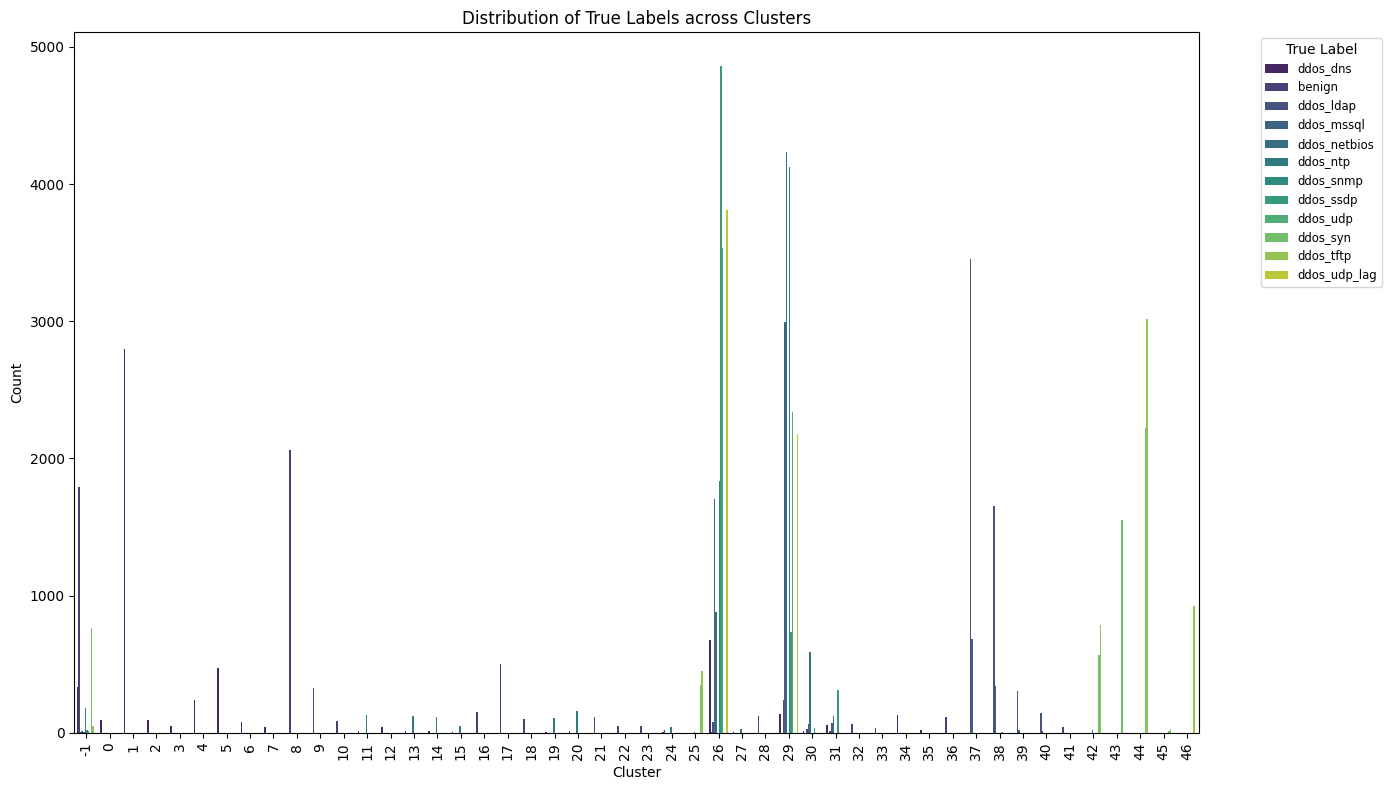

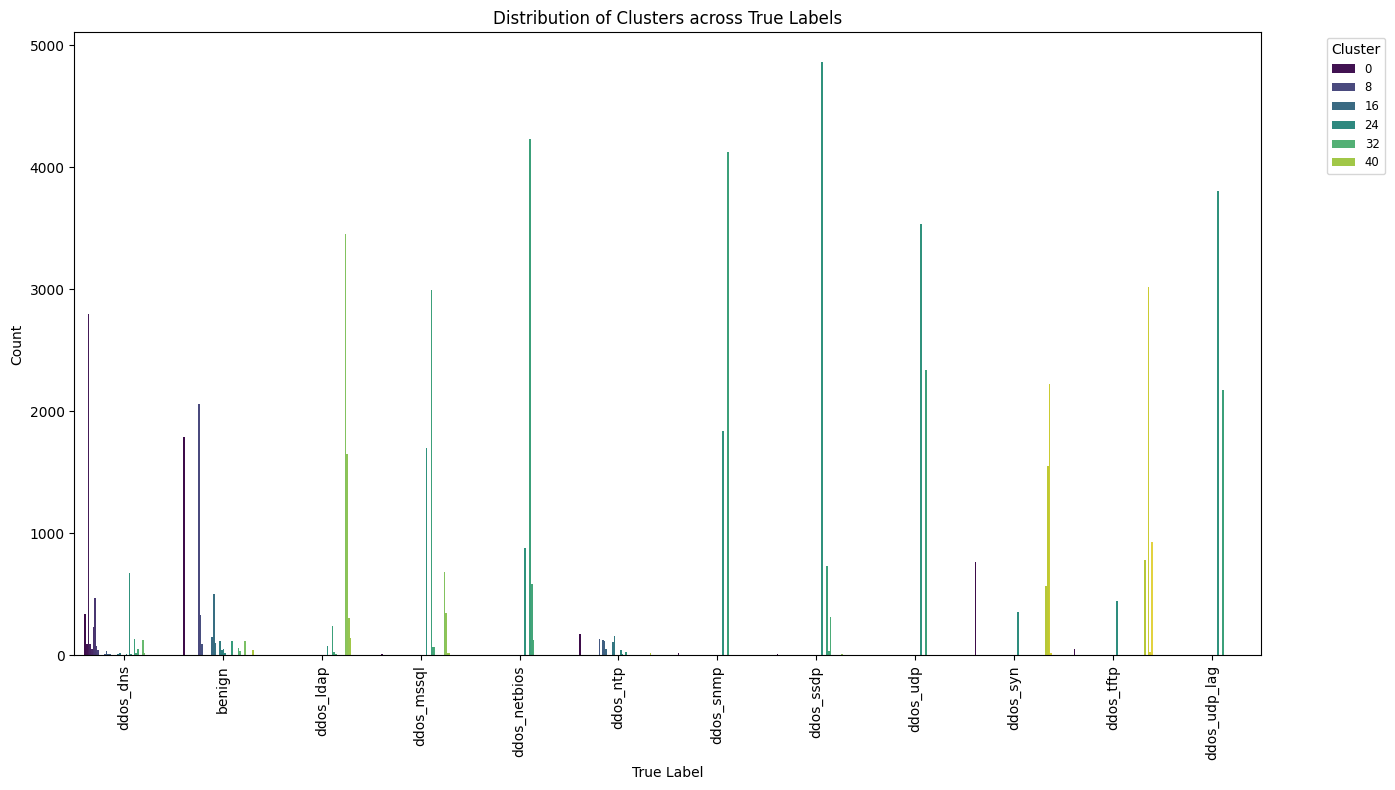

In [ ]:
# create a DataFrame to facilitate visualization.
df = pd.DataFrame({'True Label': y.to_numpy().flatten(), 'Cluster': cl_labels})

# distribution of GT label with respect to GT clusters
plt.figure(figsize=(14, 8))
sns.countplot(data=df, x='Cluster', hue='True Label', palette='viridis')
plt.title('Distribution of True Labels across Clusters')
plt.xlabel('Cluster')
plt.ylabel('Count')
plt.xticks(rotation=90)
plt.legend(title='True Label', bbox_to_anchor=(1.05, 1), loc='upper left', fontsize='small')
plt.tight_layout()
plt.show()



# distribution of clusters with respect to GT labels
plt.figure(figsize=(14, 8))
sns.countplot(data=df, x='True Label', hue='Cluster', palette='viridis')
plt.title('Distribution of Clusters across True Labels')
plt.xlabel('True Label')
plt.ylabel('Count')
plt.xticks(rotation=90)
plt.legend(title='Cluster', bbox_to_anchor=(1.05, 1), loc='upper left', fontsize='small')
plt.tight_layout()
plt.show()




<ipython-input-5-005f22e991d2>:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='True Label', data=cluster_data, order=all_labels, palette='viridis', ax=axes[idx])
<ipython-input-5-005f22e991d2>:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='True Label', data=cluster_data, order=all_labels, palette='viridis', ax=axes[idx])
<ipython-input-5-005f22e991d2>:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='True Label', data=cluster_data, order=all_labels, palette='viridis', ax=axes[idx])
<ipython-input-5-005f22e991d2>:20: Futur

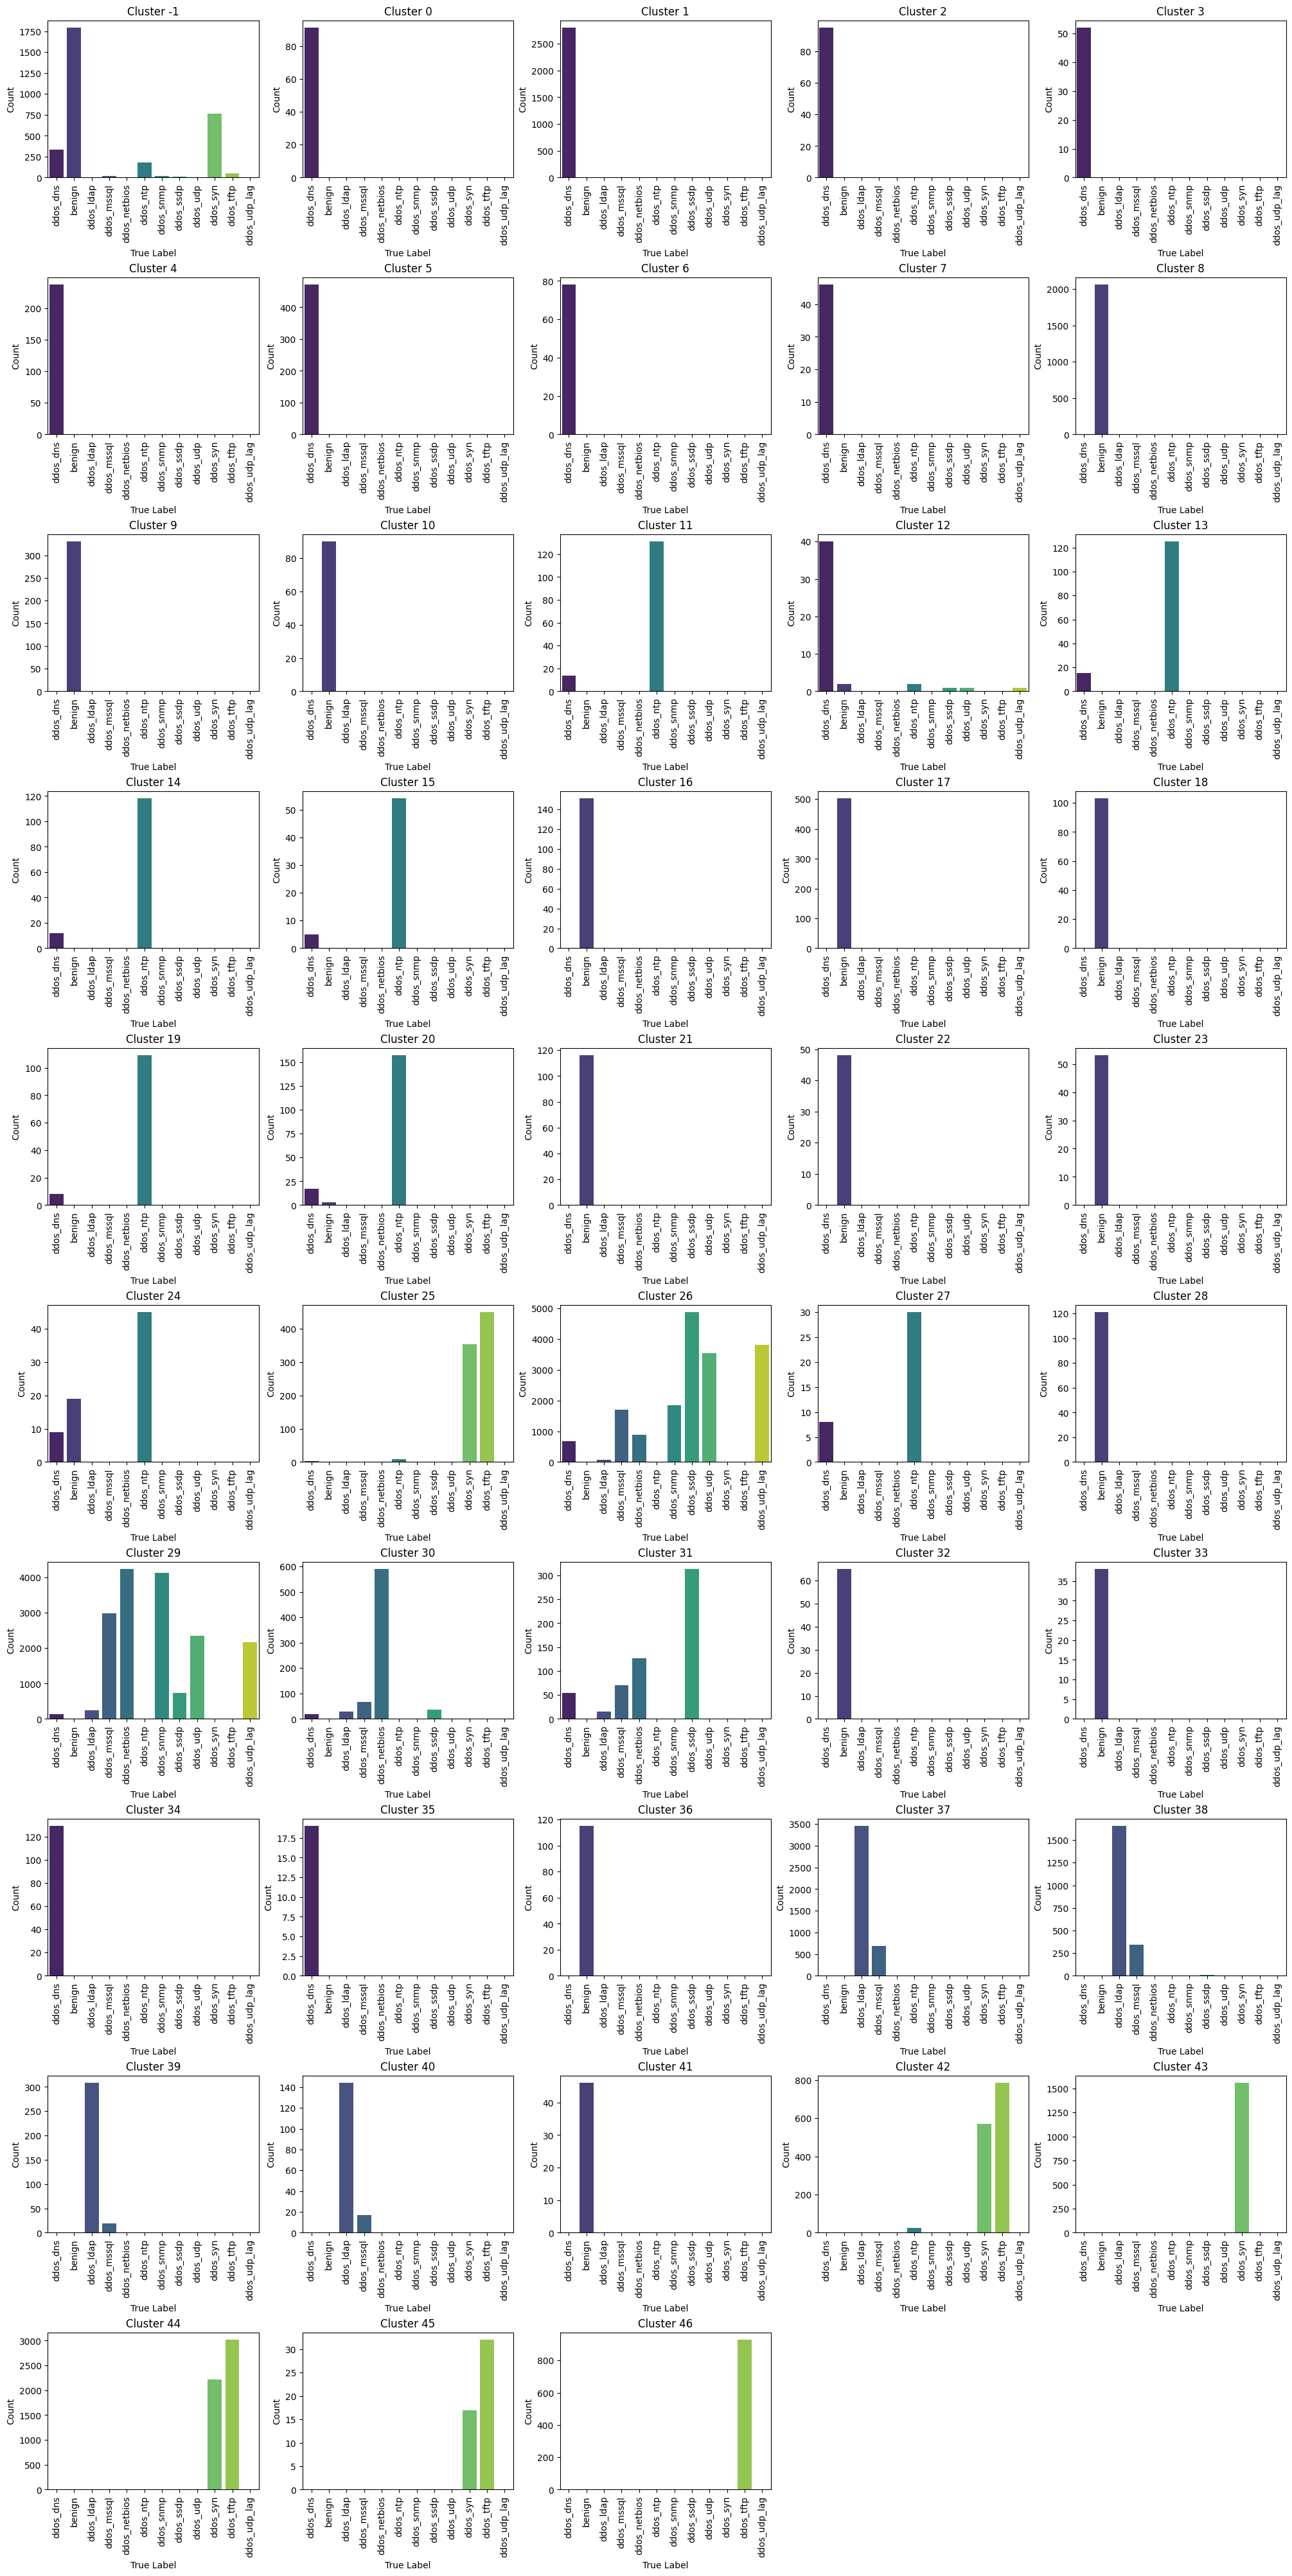

In [ ]:
# Create DataFrame with cluster labels and true labels
df = pd.DataFrame({'True Label': y.to_numpy().flatten(), 'Cluster': cl_labels})

# Plot separate boxplots for each cluster in subplots
all_labels = ddos_data_temp['label'].unique()
clusters = sorted(df['Cluster'].unique())

# Calculate the number of rows needed for the subplots
num_clusters = len(clusters)
num_cols = 5
num_rows = (num_clusters + num_cols - 1) // num_cols
num_rows = max(1, num_rows)

# Create subplots
fig, axes = plt.subplots(num_rows, num_cols, figsize=(20, 4 * num_rows), constrained_layout=True)
axes = axes.flatten()

for idx, cluster in enumerate(clusters):
    cluster_data = df[df['Cluster'] == cluster]
    sns.countplot(x='True Label', data=cluster_data, order=all_labels, palette='viridis', ax=axes[idx])
    axes[idx].set_title(f'Cluster {cluster}')
    axes[idx].set_xlabel('True Label')
    axes[idx].set_ylabel('Count')
    axes[idx].tick_params(axis='x', rotation=90)

# Hide any unused subplots
for j in range(idx + 1, len(axes)):
    fig.delaxes(axes[j])
plt.show()

# Contingency table

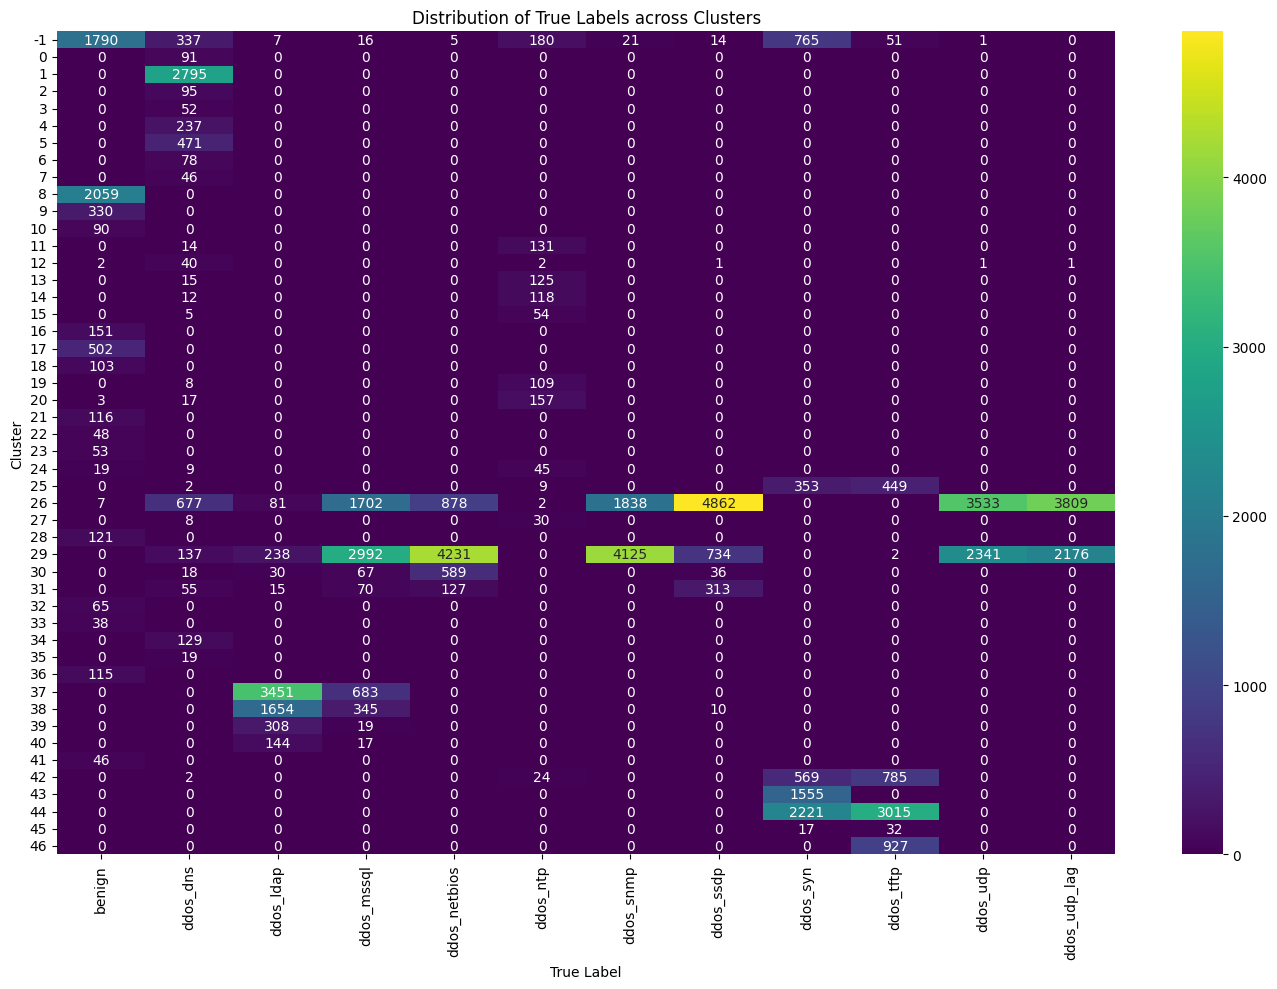

In [ ]:
df = pd.DataFrame({'True Label': y.to_numpy().flatten(), 'Cluster': cl_labels})

# Create a contingency table
contingency_table = pd.crosstab(df['Cluster'], df['True Label'])

# Plot
plt.figure(figsize=(14, 10))
sns.heatmap(contingency_table, annot=True, fmt="d", cmap="viridis", cbar=True)
plt.title('Distribution of True Labels across Clusters')
plt.xlabel('True Label')
plt.ylabel('Cluster')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()



# Cluster mapping



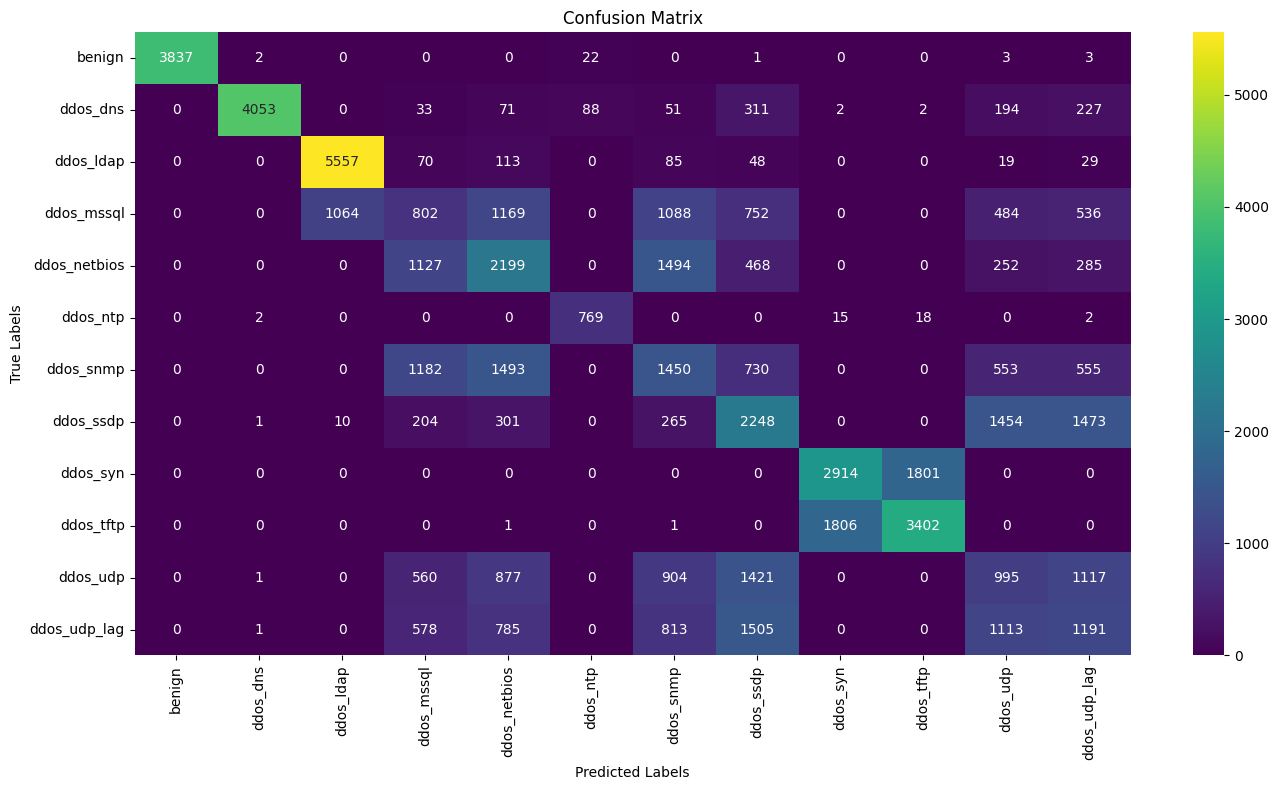

Classification Report:
               precision    recall  f1-score   support

      benign       1.00      0.99      1.00      3868
    ddos_dns       1.00      0.81      0.89      5032
   ddos_ldap       0.84      0.94      0.89      5921
  ddos_mssql       0.18      0.14      0.15      5895
ddos_netbios       0.31      0.38      0.34      5825
    ddos_ntp       0.87      0.95      0.91       806
   ddos_snmp       0.24      0.24      0.24      5963
   ddos_ssdp       0.30      0.38      0.33      5956
    ddos_syn       0.62      0.62      0.62      4715
   ddos_tftp       0.65      0.65      0.65      5210
    ddos_udp       0.20      0.17      0.18      5875
ddos_udp_lag       0.22      0.20      0.21      5986

    accuracy                           0.48     61052
   macro avg       0.53      0.54      0.53     61052
weighted avg       0.48      0.48      0.48     61052

Clusters to Label Mapping with Weights:
Cluster                                         Labels with Weights
 

In [ ]:
cl_labels_2 = cl_labels.copy()
# Find the indexes of the elements to be deleted
mask = np.where(cl_labels_2 == -1)

# Delete elements from the indexes found
cl_labels_new = np.delete(cl_labels_2, mask)
y_str_new = np.delete(y.to_numpy(), mask)

cl_labels_str = cl_labels_new.astype(str)


df = pd.DataFrame({'True Label': y_str_new.flatten(), 'Cluster': cl_labels_str})

# Identify clusters with a total frequency less than 0 (none)
cluster_counts = df['Cluster'].value_counts()
clusters_to_remove = cluster_counts[cluster_counts < 0].index

# Filter the DataFrame to remove these clusters
df = df[~df['Cluster'].isin(clusters_to_remove)]

# Create a contingency table
contingency_table = pd.crosstab(df['Cluster'], df['True Label'])

# Calculate relative frequencies
relative_frequencies = contingency_table.div(contingency_table.sum(axis=1), axis=0)

# Function to assign a label probabilistically based on the filtered weighted distribution
def assign_label_probabilistically(cluster):
    probabilities = relative_frequencies.loc[cluster].values
    labels = relative_frequencies.columns.values
    max_frequency = probabilities.max()

    # Filter labels with at least 60% of the maximum frequency
    filtered_indices = probabilities >= (0.6 * max_frequency)
    filtered_probabilities = probabilities[filtered_indices]
    filtered_labels = labels[filtered_indices]

    # Normalize filtered probabilities to sum to 1
    if filtered_probabilities.sum() > 0:
        filtered_probabilities /= filtered_probabilities.sum()

    return np.random.choice(filtered_labels, p=filtered_probabilities), filtered_labels, filtered_probabilities
#Assign labels probabilistically
predicted_labels = []
cluster_label_weights = []

for cluster in df['Cluster']:
    assigned_label, filtered_labels, filtered_probabilities = assign_label_probabilistically(cluster)
    predicted_labels.append(assigned_label)
    cluster_label_weights.append((cluster, list(zip(filtered_labels, filtered_probabilities))))

predicted_labels = np.array(predicted_labels)

# Filter y_str to remove the same clusters
y_filtered = df['True Label'].values

# Confusion matrix
conf_matrix = confusion_matrix(y_filtered, predicted_labels, labels=np.unique(y_str_new))

plt.figure(figsize=(14, 8))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="viridis", xticklabels=np.unique(y_str_new), yticklabels=np.unique(y_str_new))
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

print("Classification Report:\n", classification_report(y_filtered, predicted_labels))

# Create a list to store cluster weights
cluster_label_weights = []

for cluster in np.unique(df['Cluster']):
    _, filtered_labels, filtered_probabilities = assign_label_probabilistically(cluster)
    cluster_label_weights.append((cluster, list(zip(filtered_labels, filtered_probabilities))))

# Create a table to display weights in percentage
weights_table_list = []

for cluster, weights in cluster_label_weights:
    weights_str = ', '.join([f"{label}: {weight:.2%}" for label, weight in weights])
    weights_table_list.append({"Cluster": cluster, "Labels with Weights": weights_str})

weights_table = pd.DataFrame(weights_table_list)

# Display the table
print("Clusters to Label Mapping with Weights:")
print(weights_table.to_string(index=False))




# ECDF of number of clusters assigned to each label

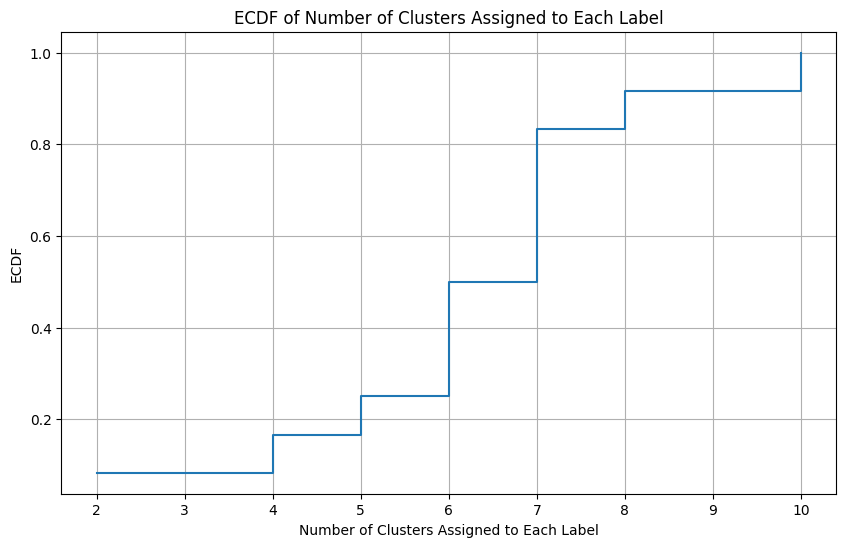

Number of Clusters Assigned to Each Label:
True Label
benign           6
ddos_dns        10
ddos_ldap        7
ddos_mssql       7
ddos_netbios     6
ddos_ntp         5
ddos_snmp        6
ddos_ssdp        8
ddos_syn         2
ddos_tftp        4
ddos_udp         7
ddos_udp_lag     7
Name: Predicted Label, dtype: int64


In [ ]:
df_results = pd.DataFrame({'True Label': y_filtered, 'Predicted Label': predicted_labels})

# Count the number of clusters assigned to each label
cluster_counts_per_label = df_results.groupby('True Label')['Predicted Label'].nunique()
sorted_counts = np.sort(cluster_counts_per_label.values)

# ECDF
ecdf_y = np.arange(1, len(sorted_counts) + 1) / len(sorted_counts)

plt.figure(figsize=(10, 6))
plt.step(sorted_counts, ecdf_y, where='post')
plt.xlabel('Number of Clusters Assigned to Each Label')
plt.ylabel('ECDF')
plt.title('ECDF of Number of Clusters Assigned to Each Label')
plt.grid(True)
plt.show()

print("Number of Clusters Assigned to Each Label:")
print(cluster_counts_per_label)

# Features importance

36


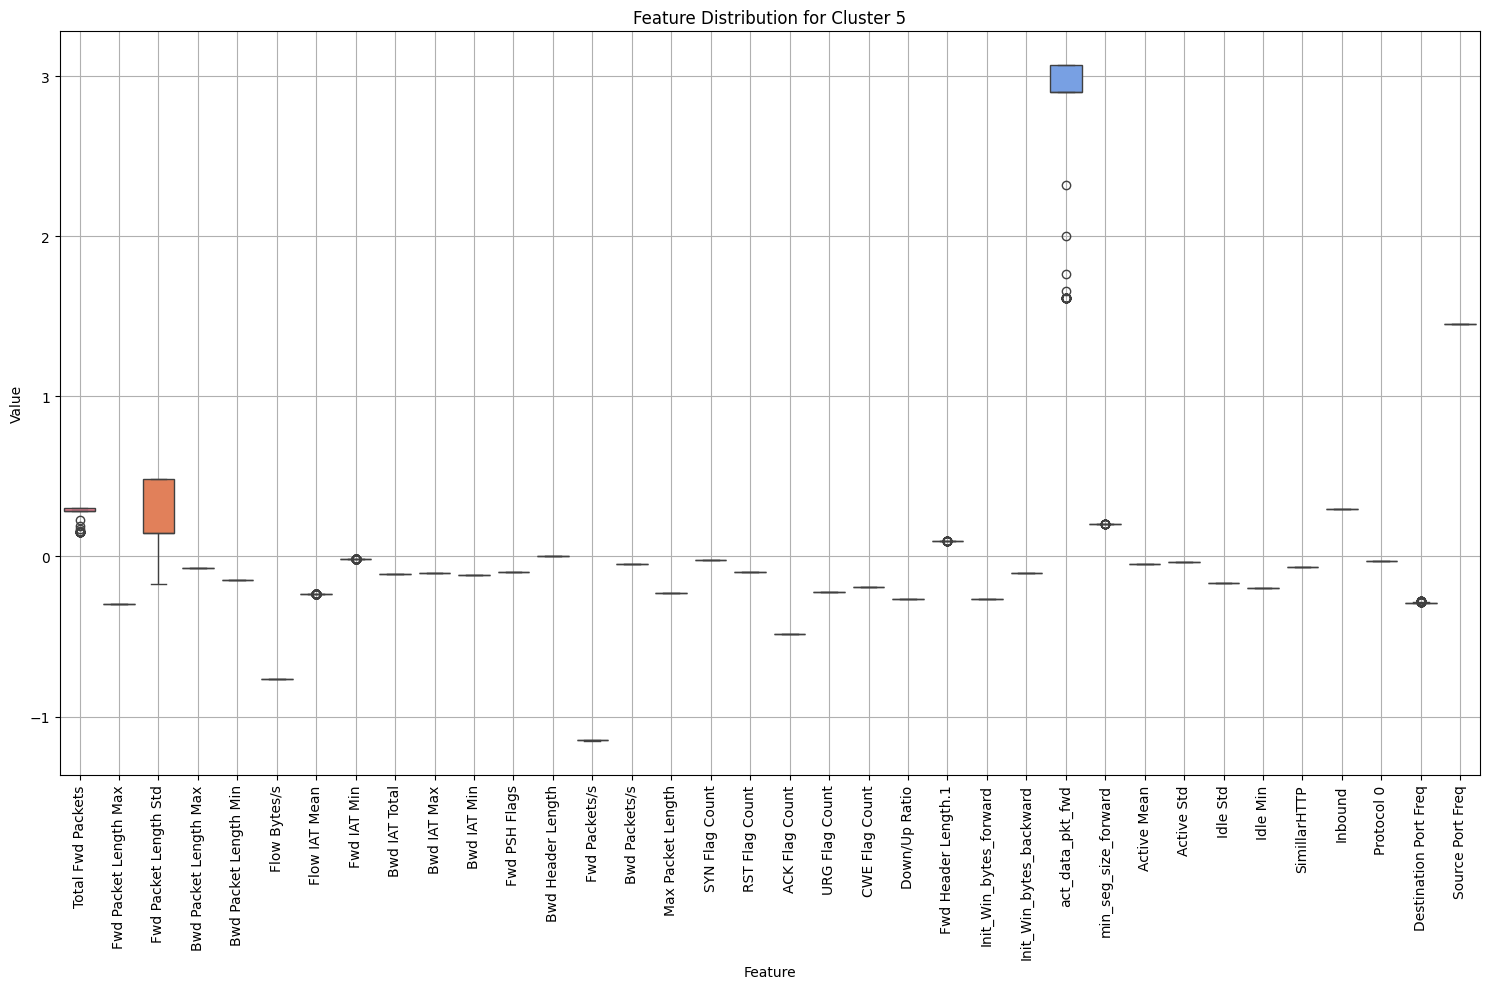

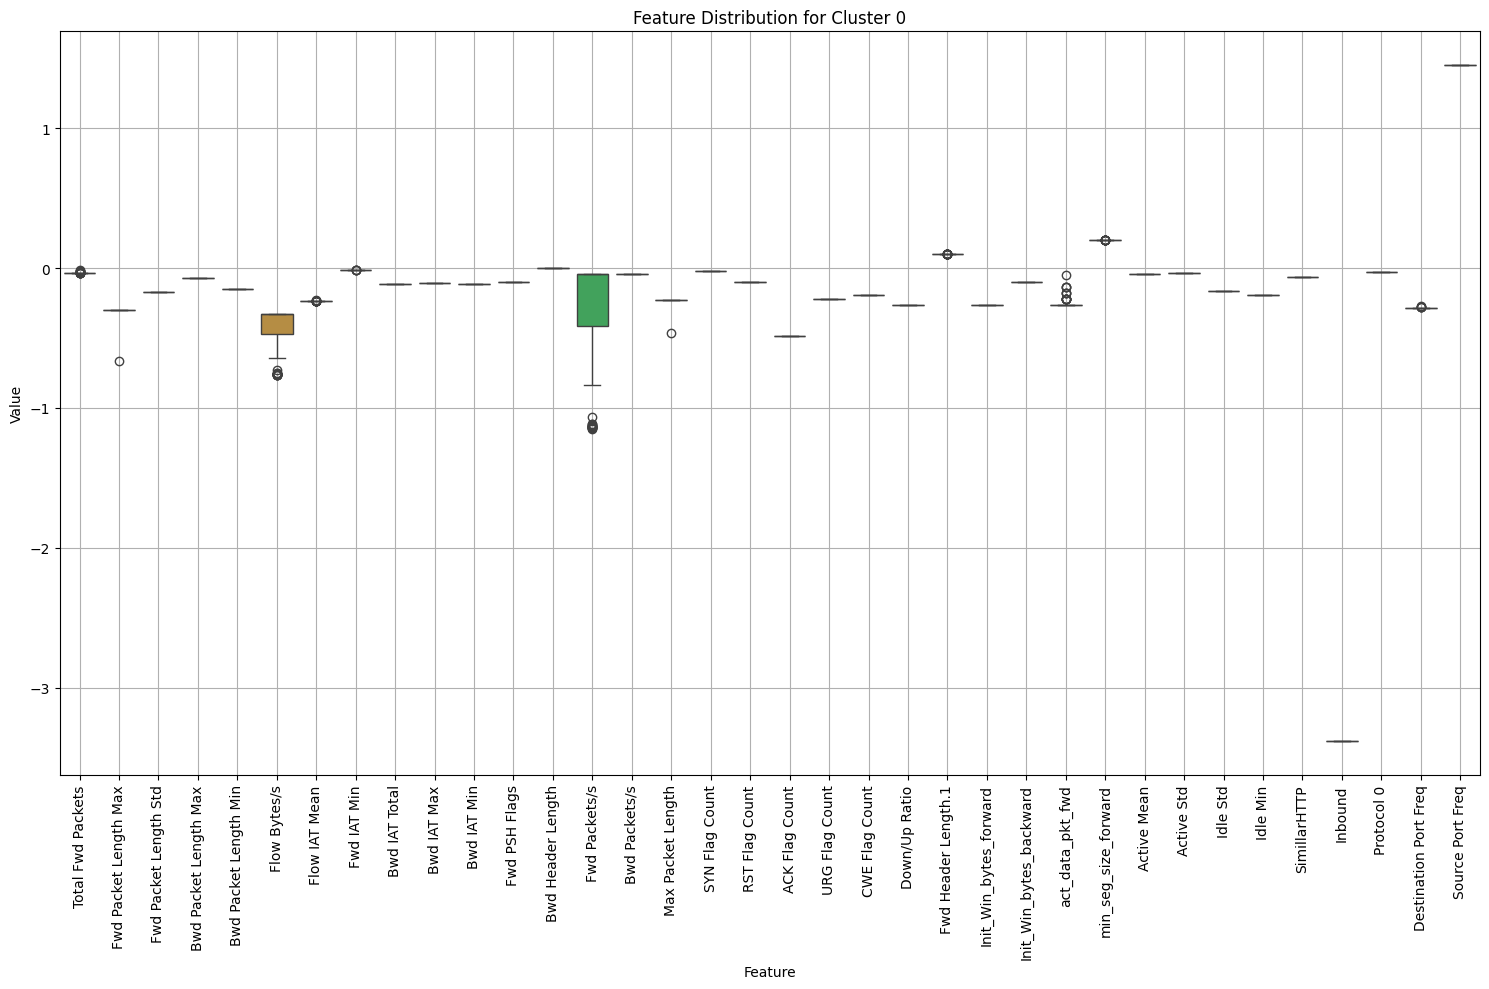

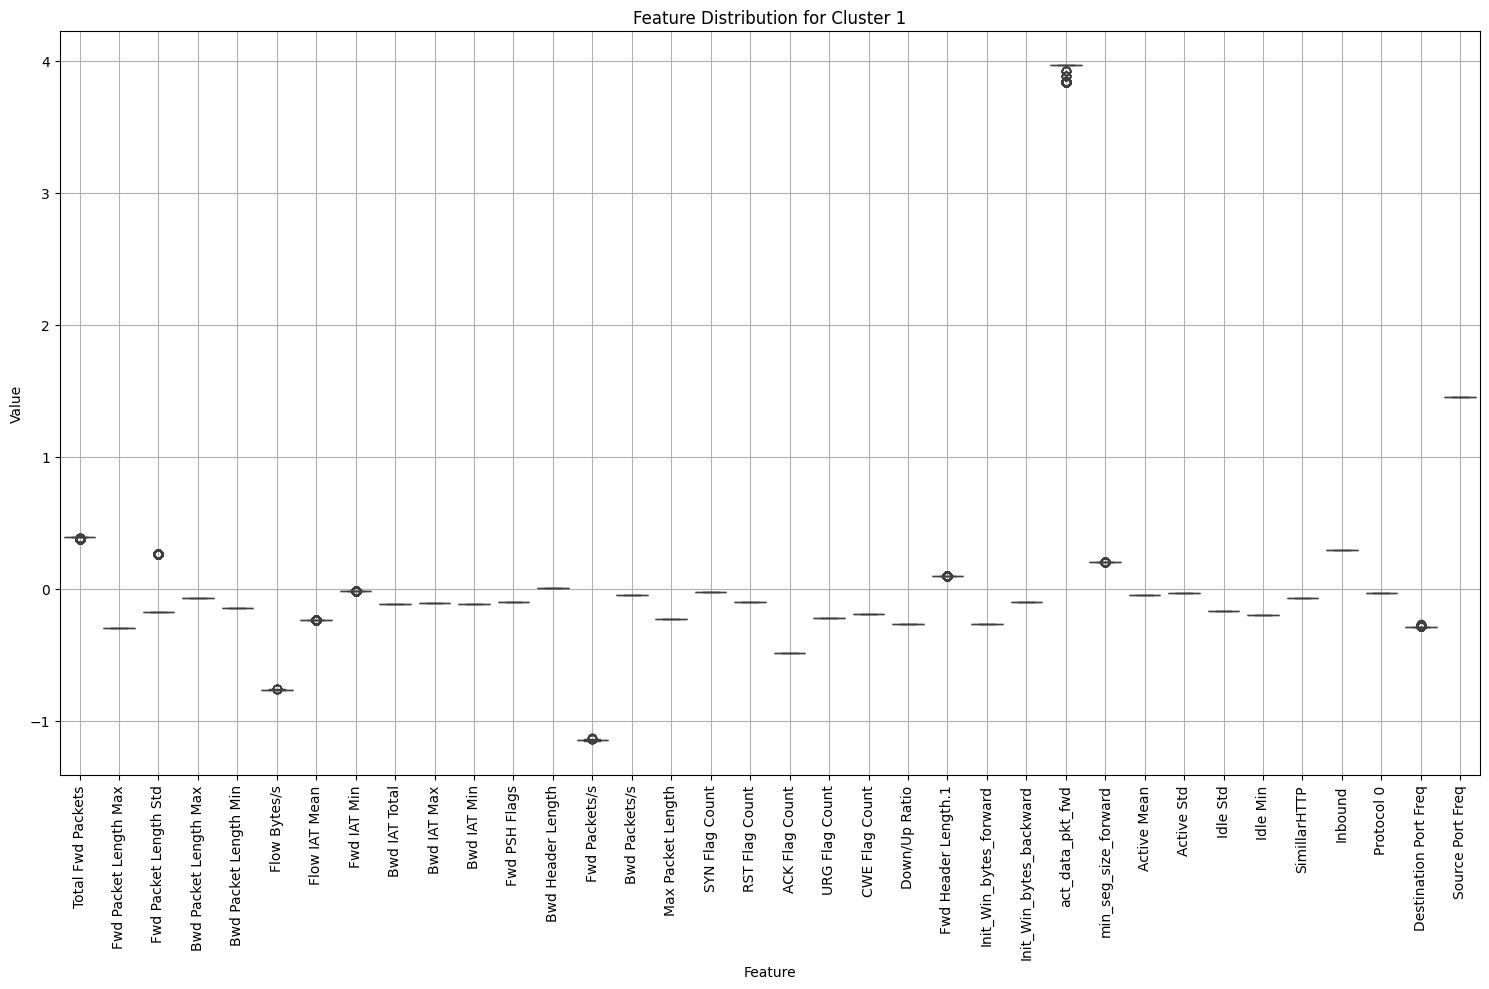

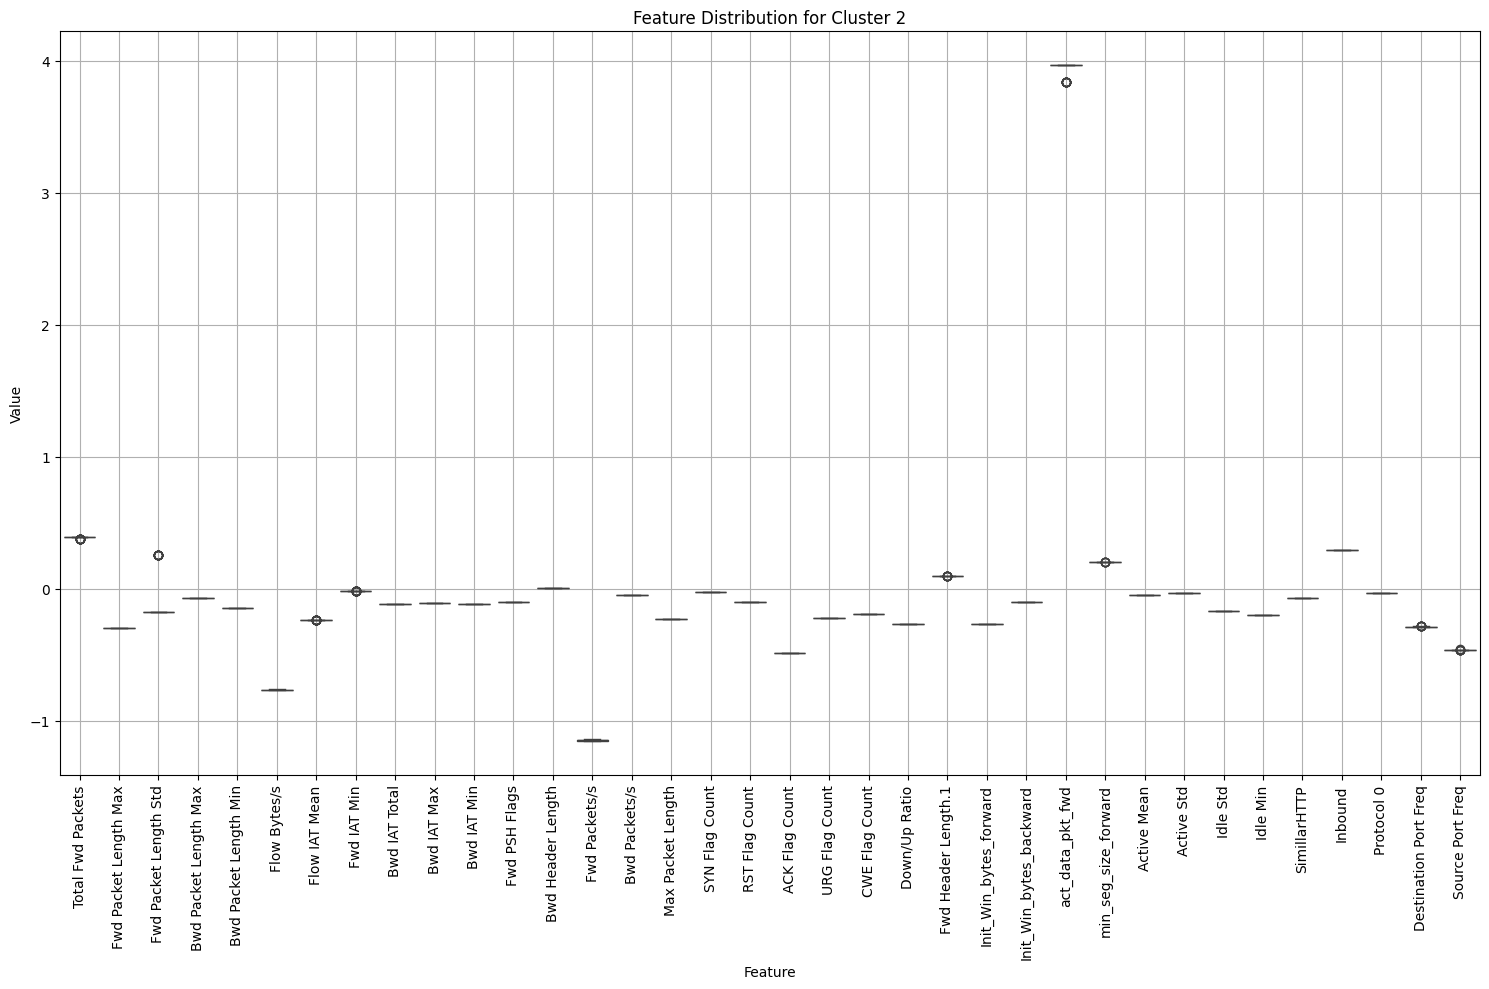

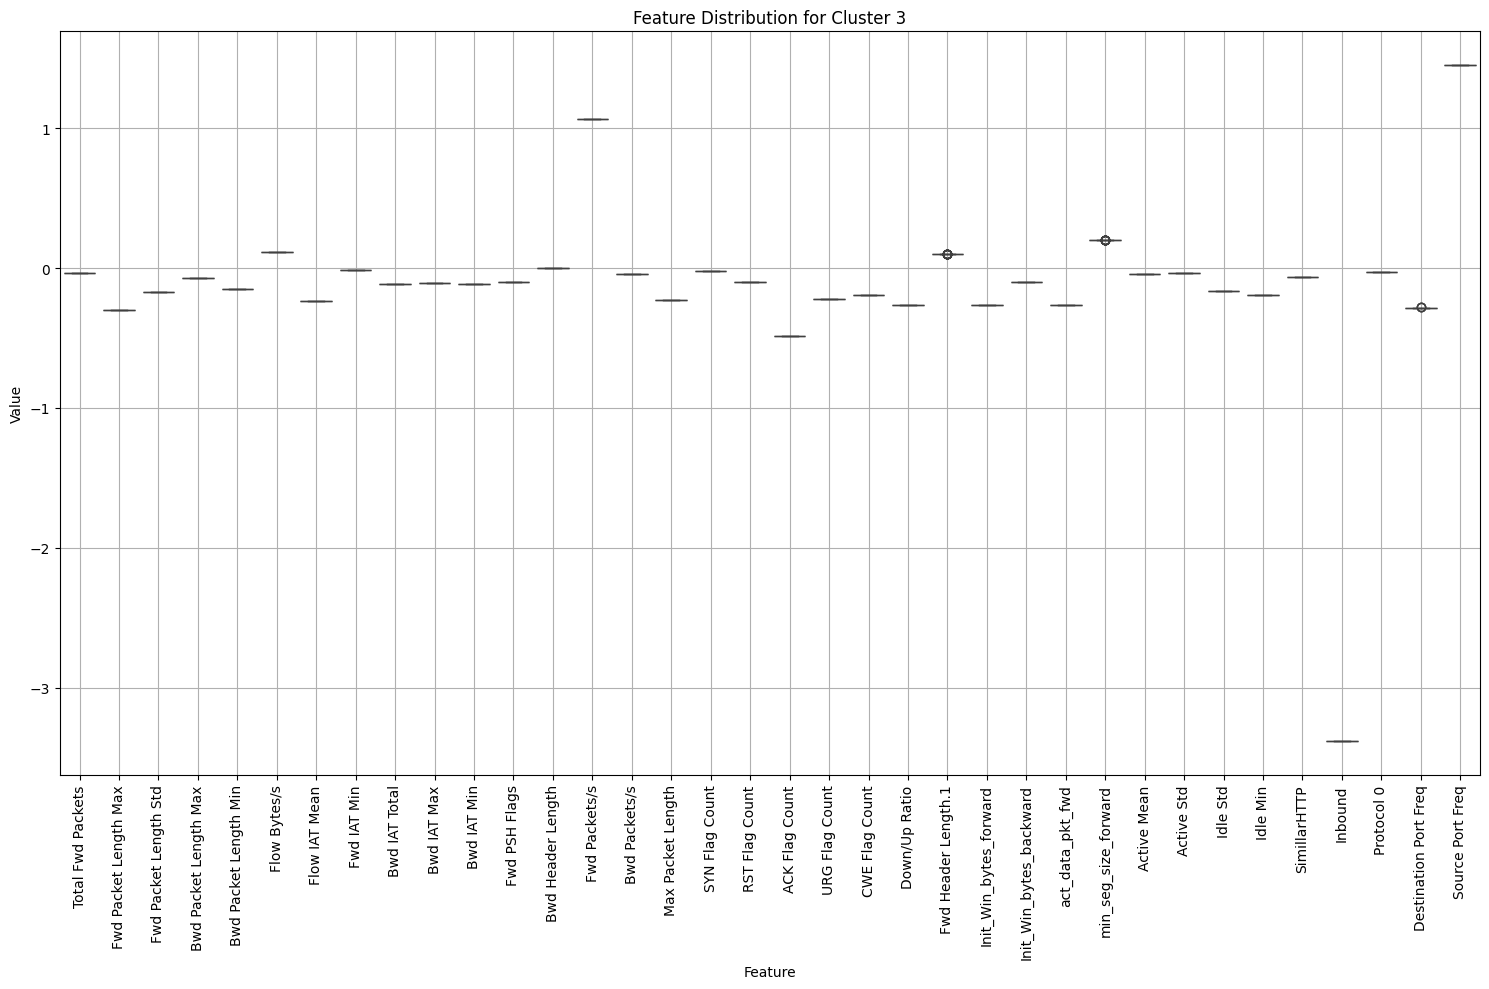

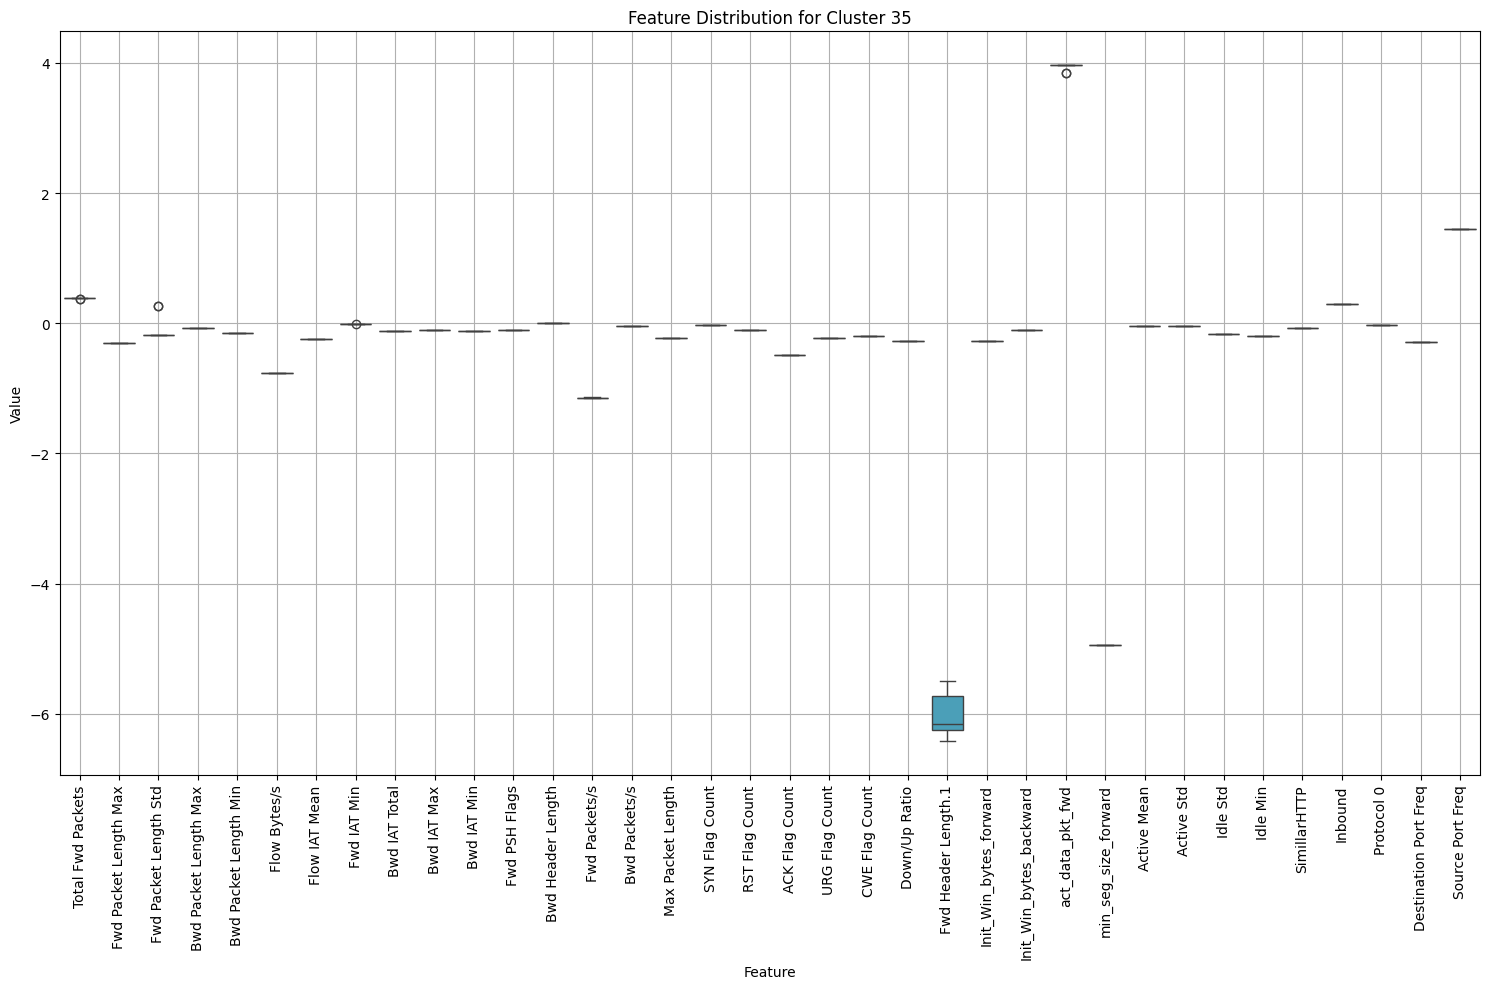

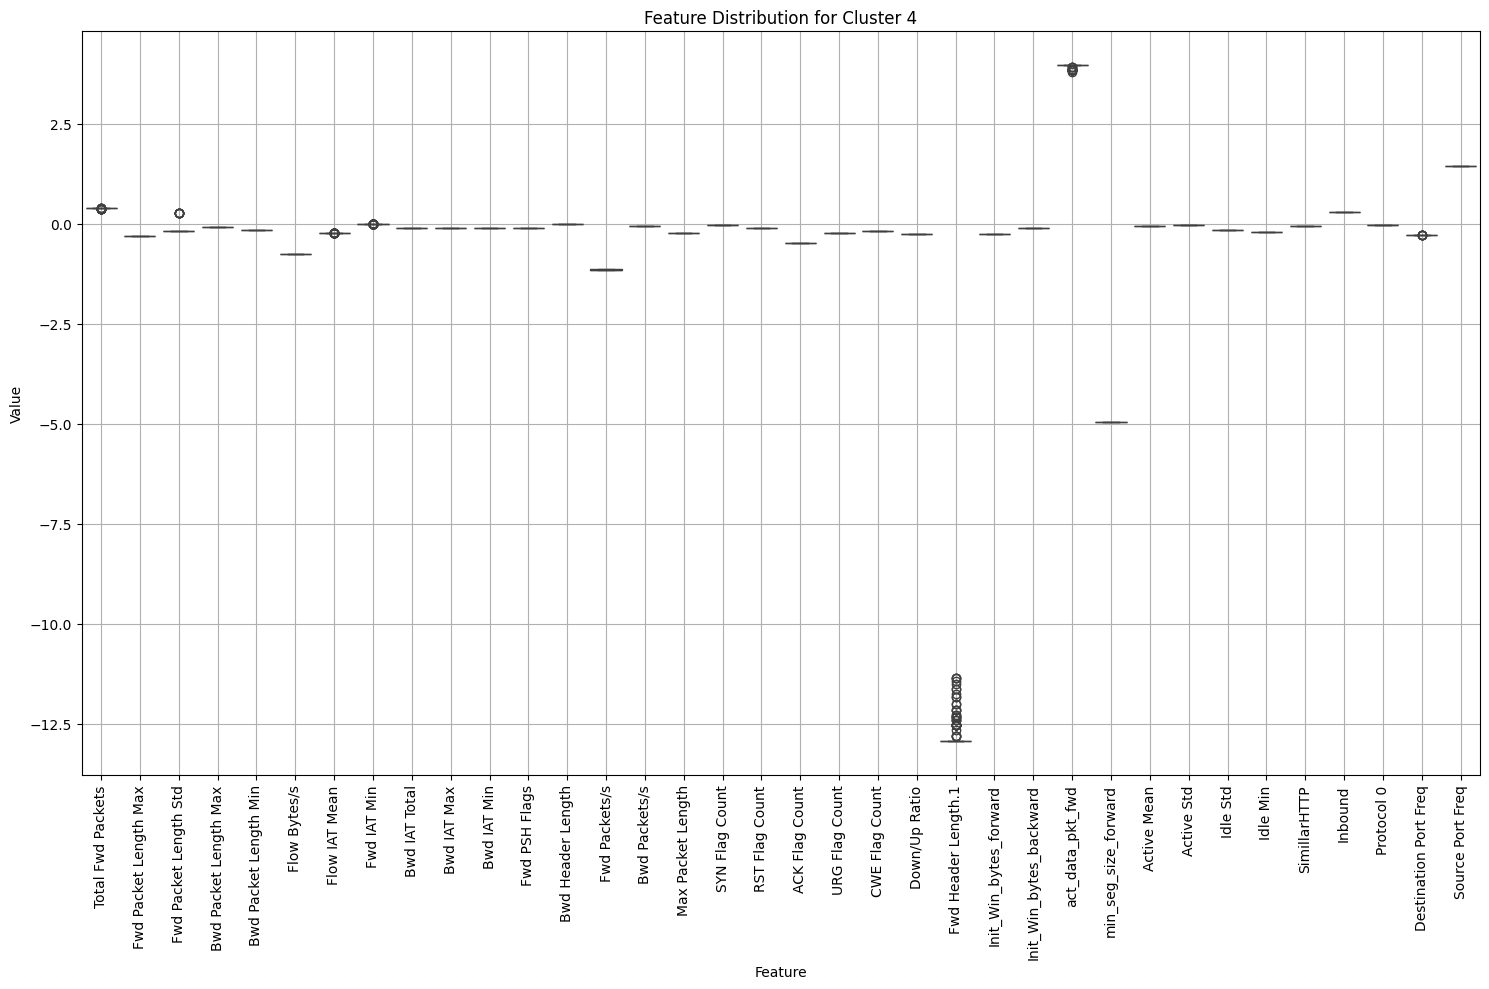

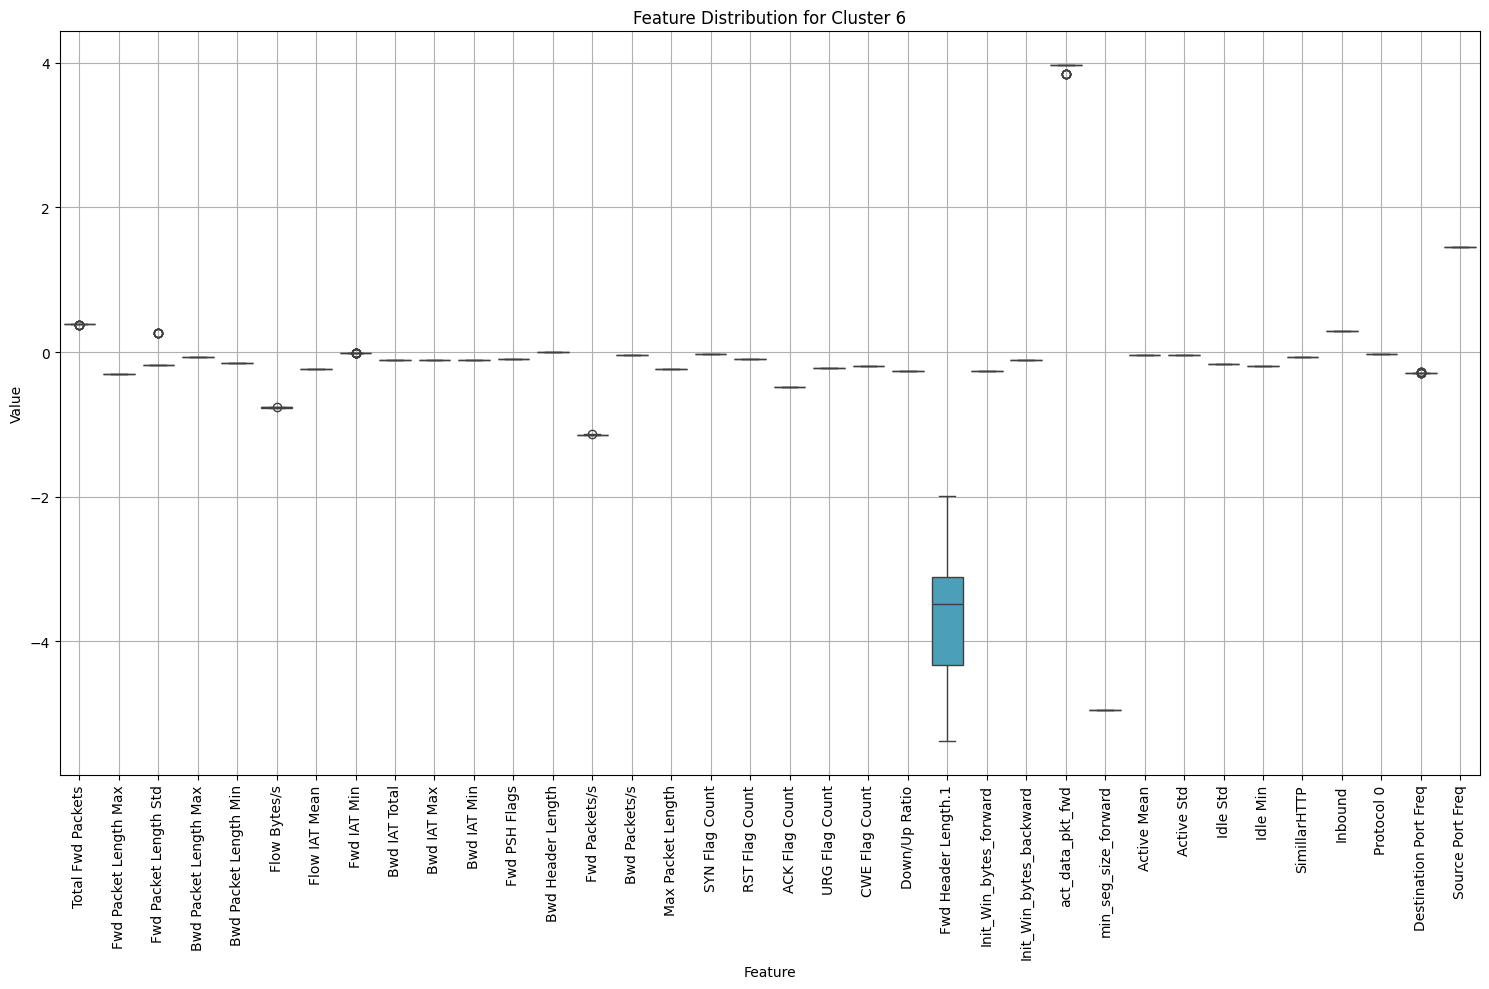

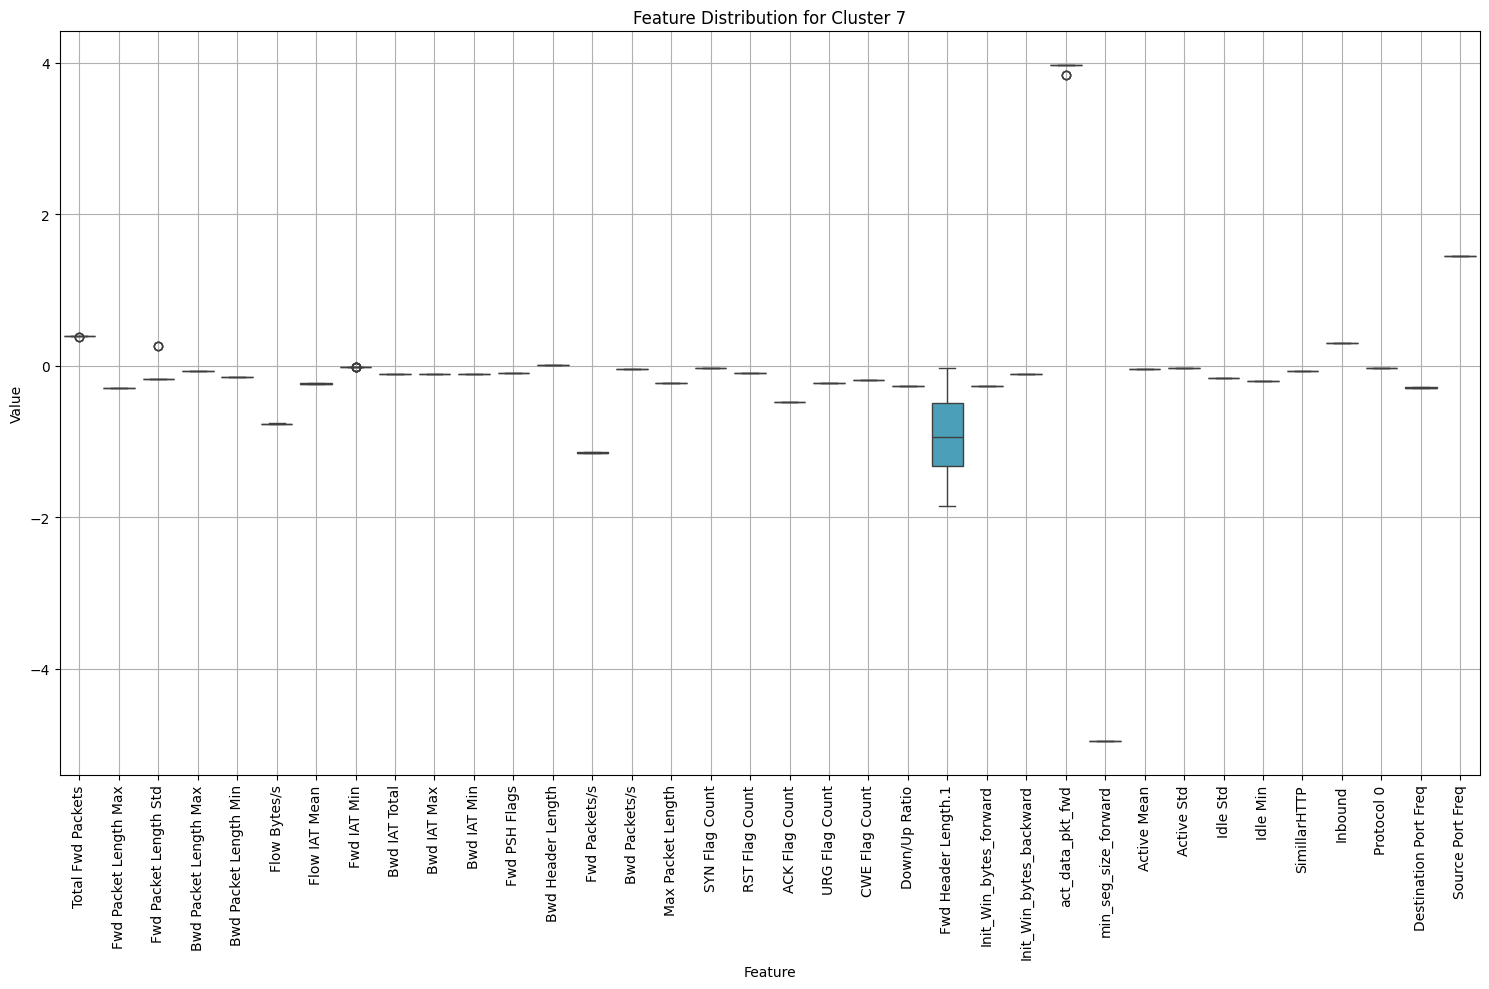

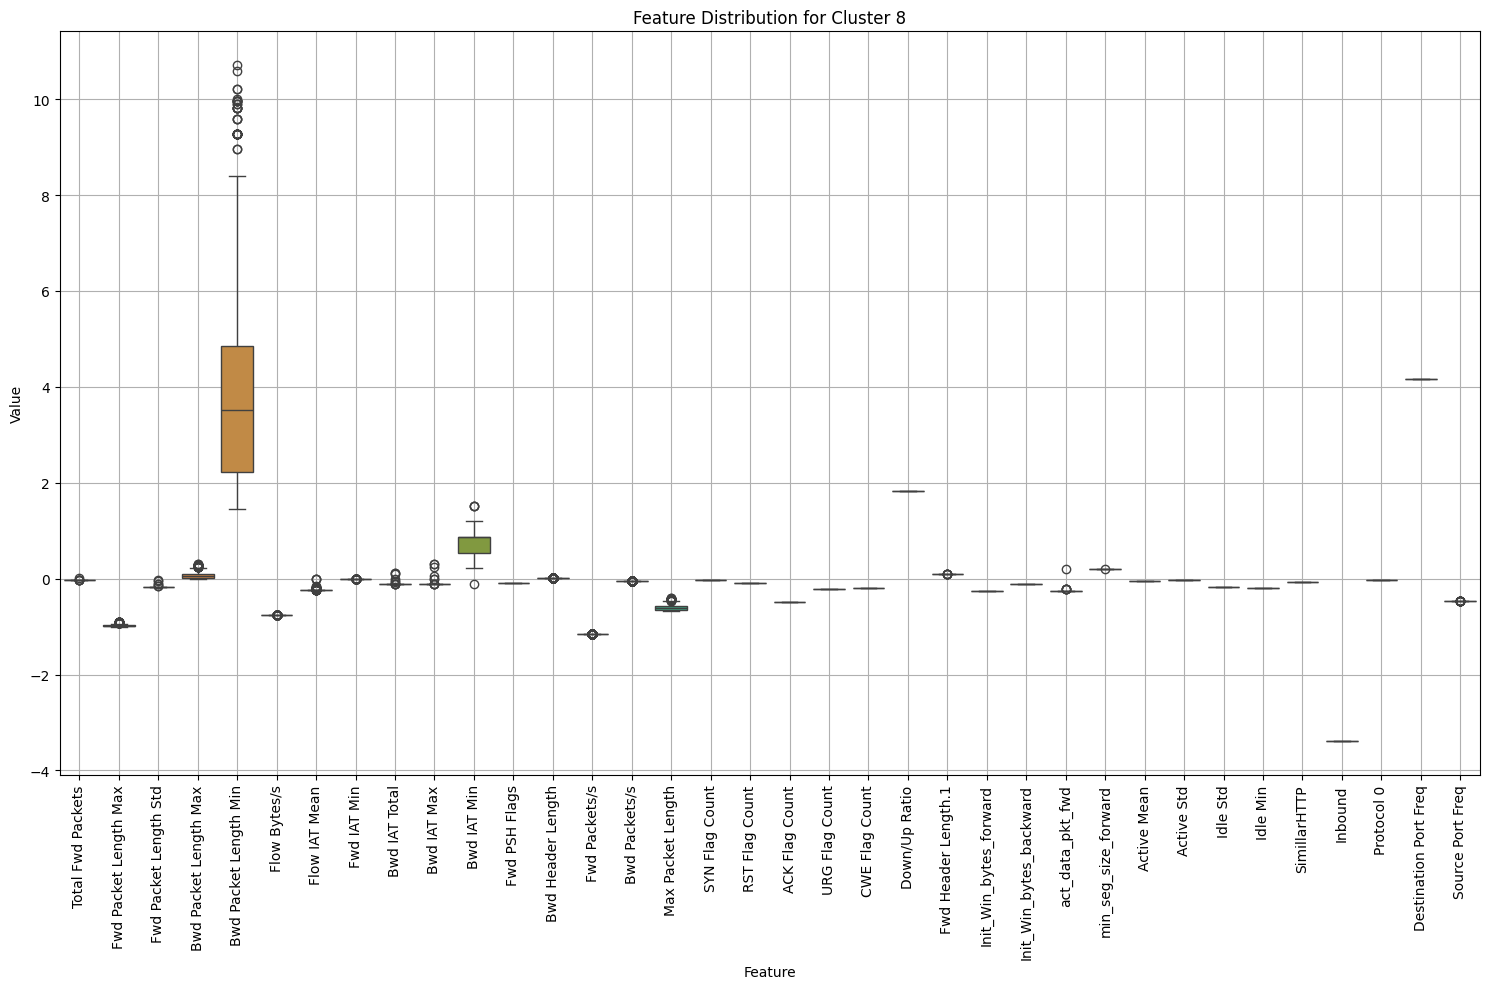

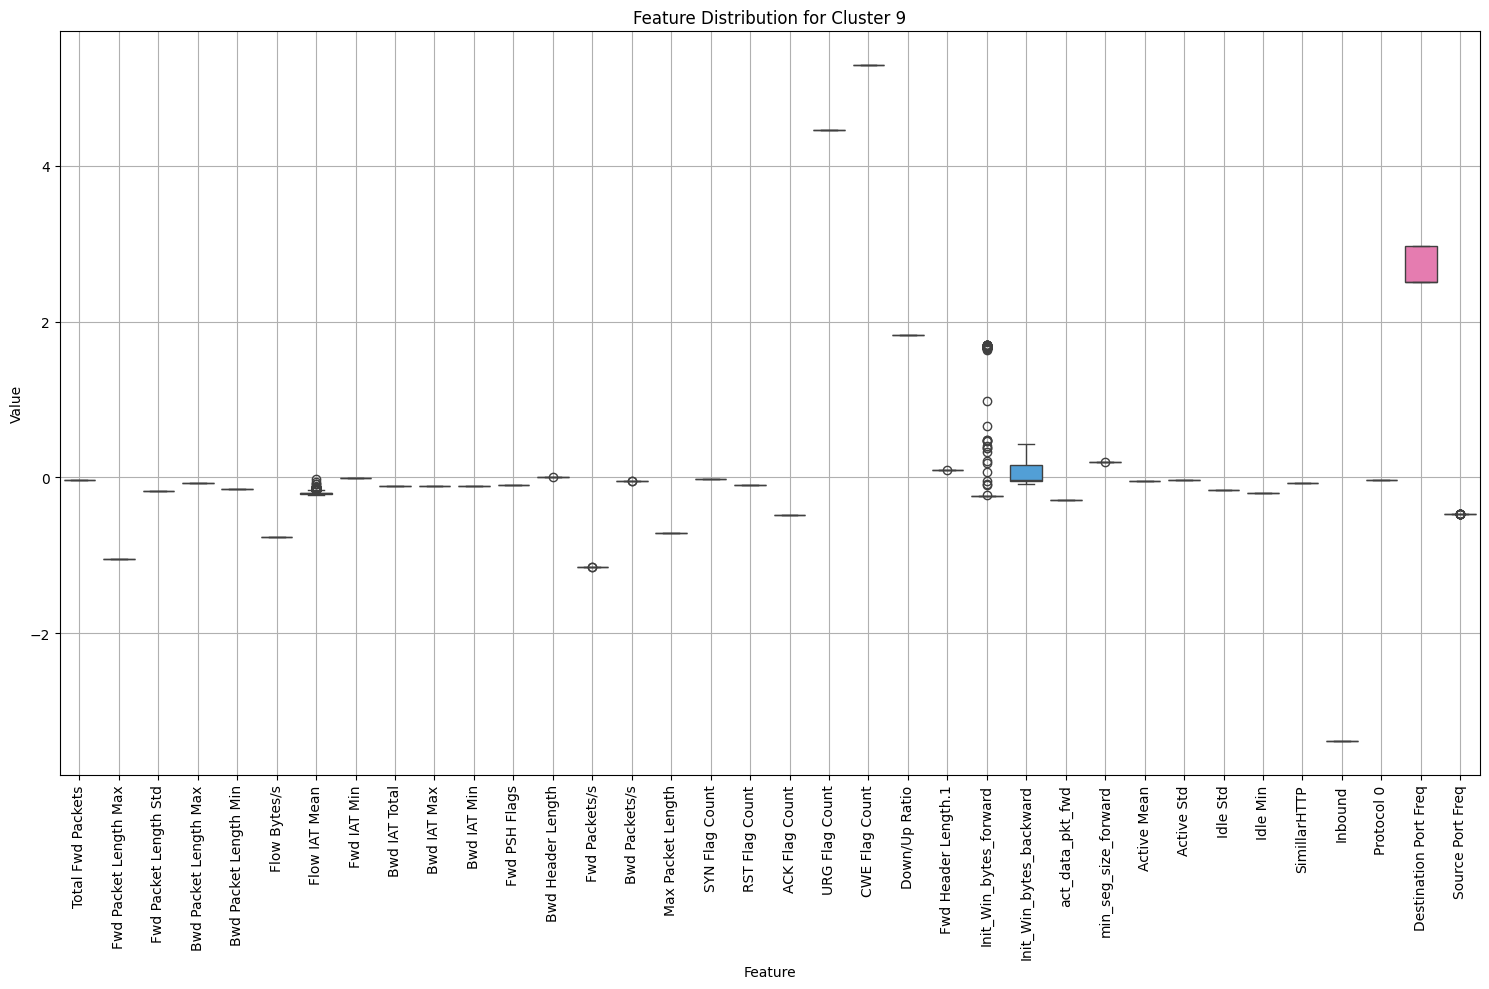

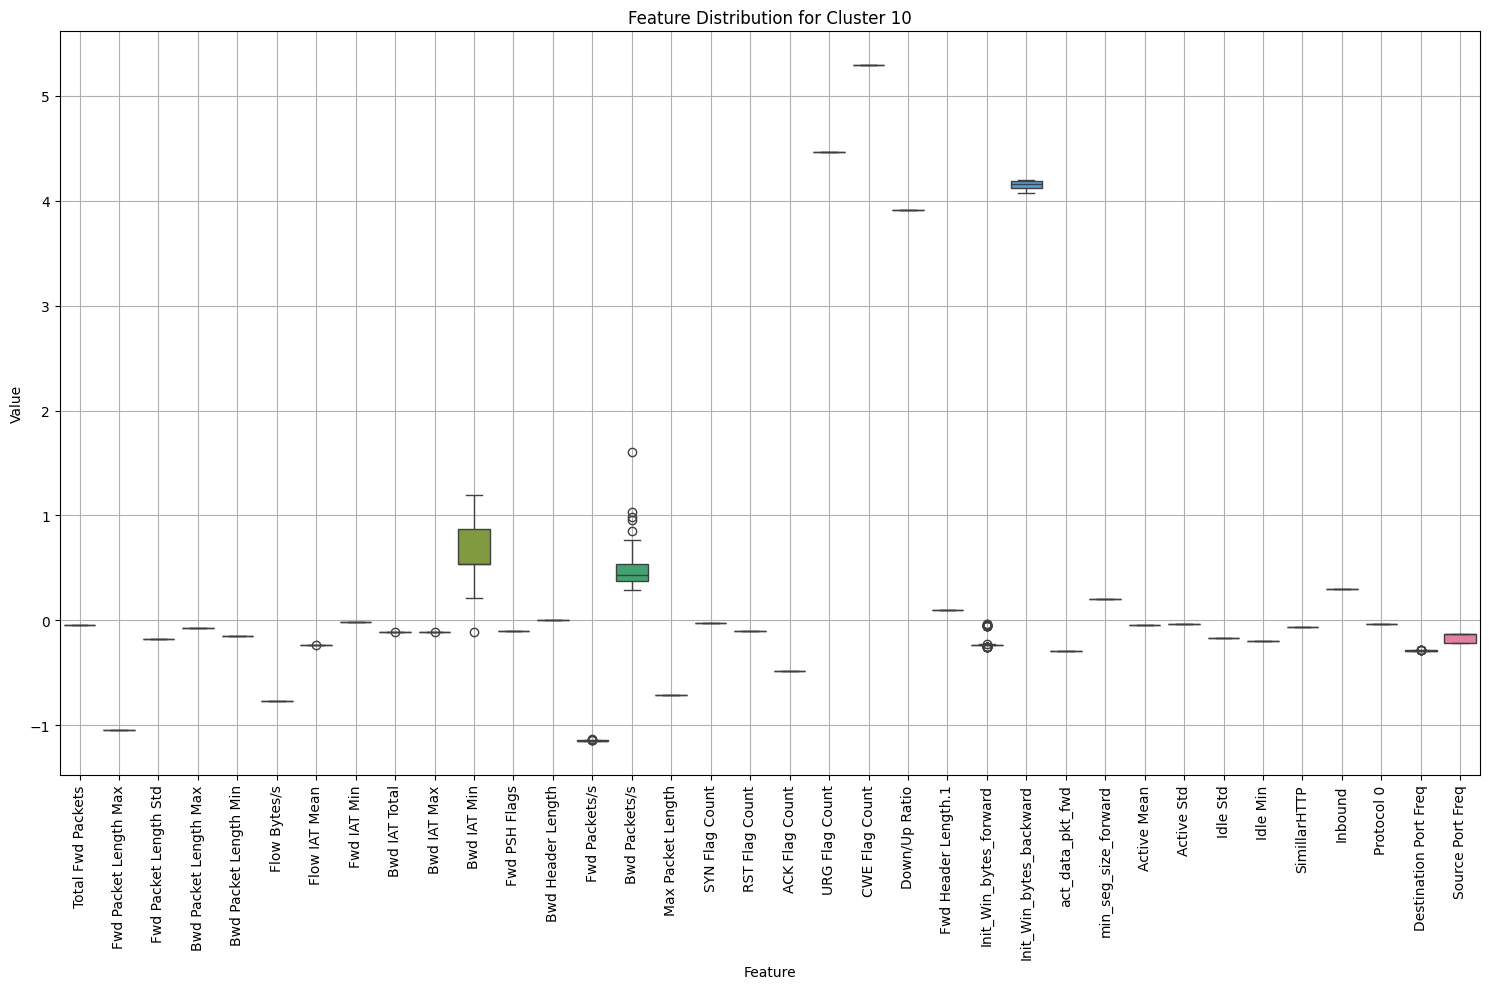

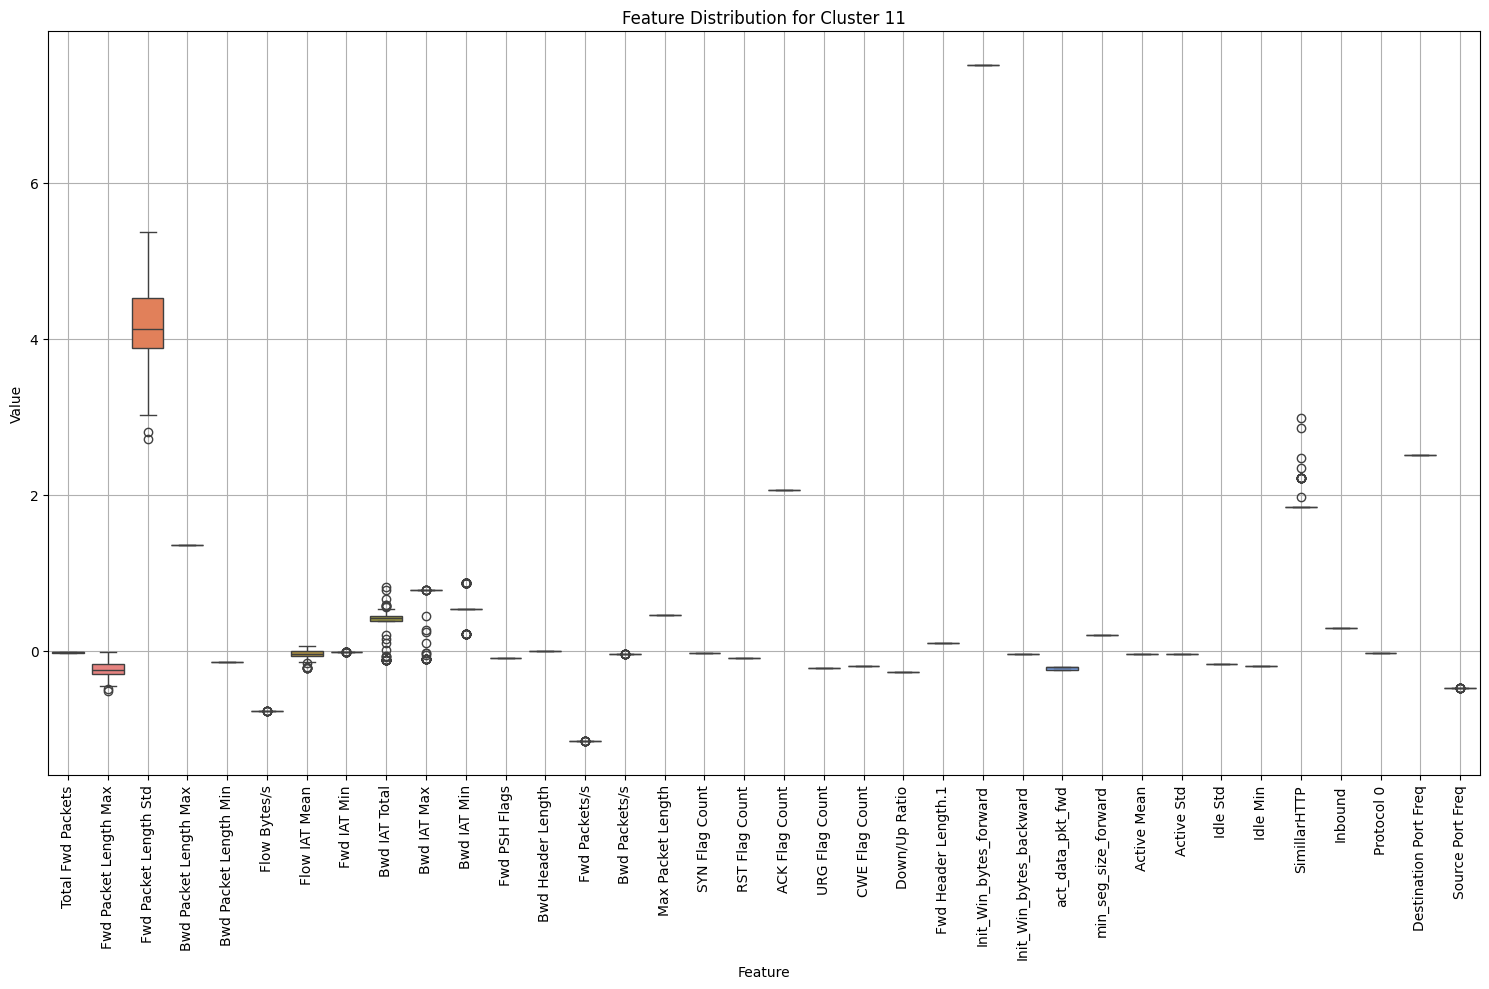

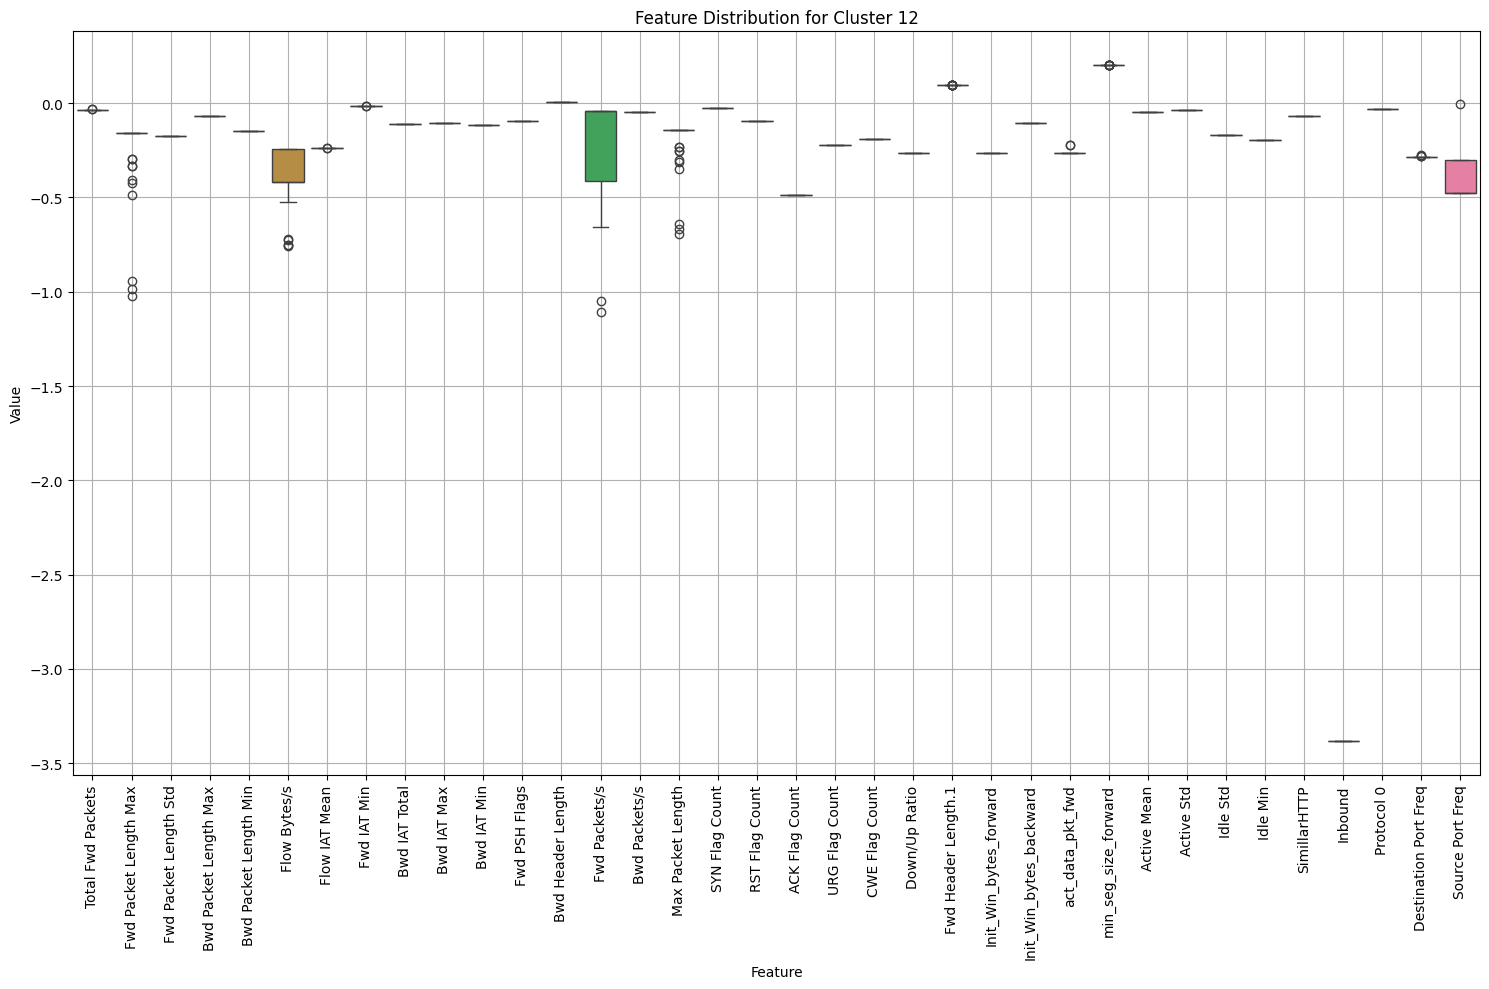

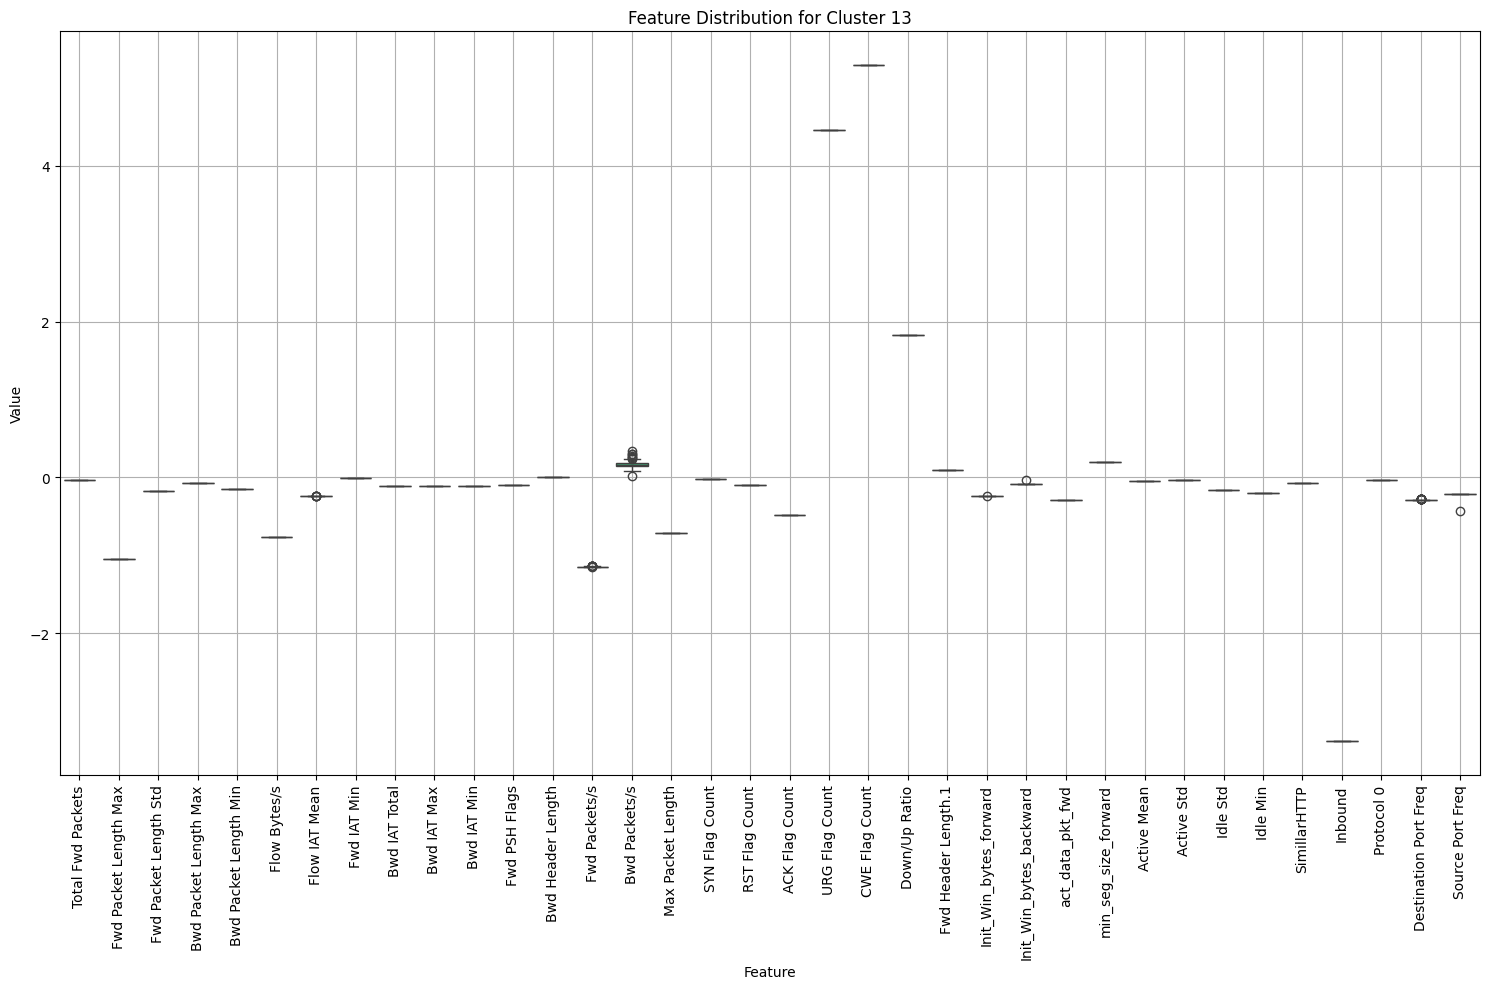

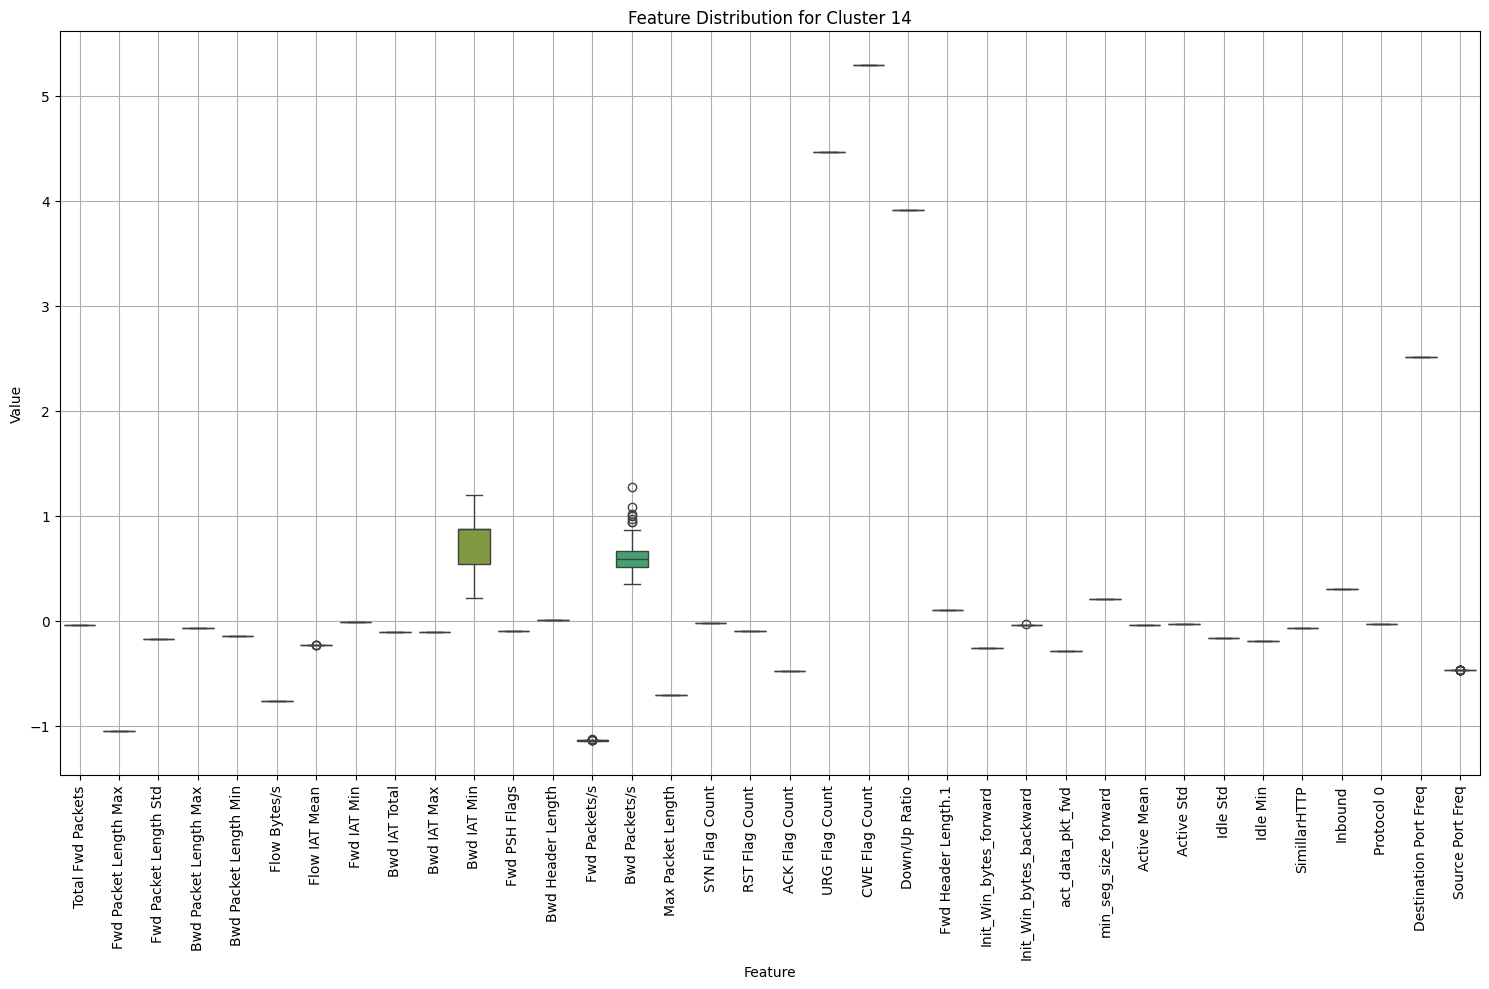

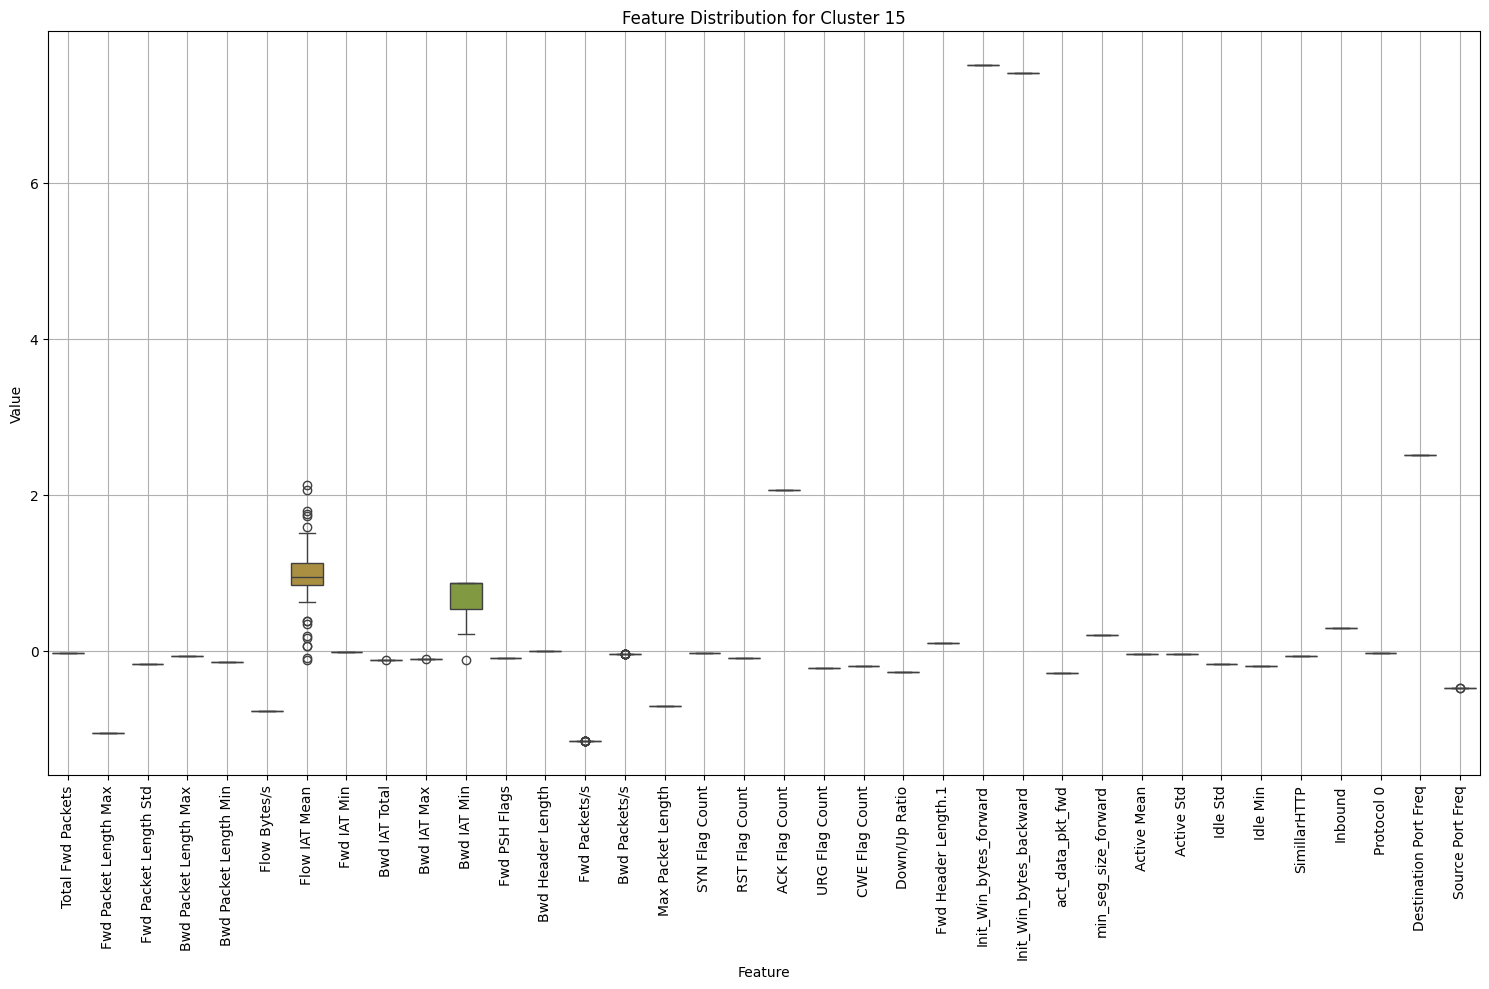

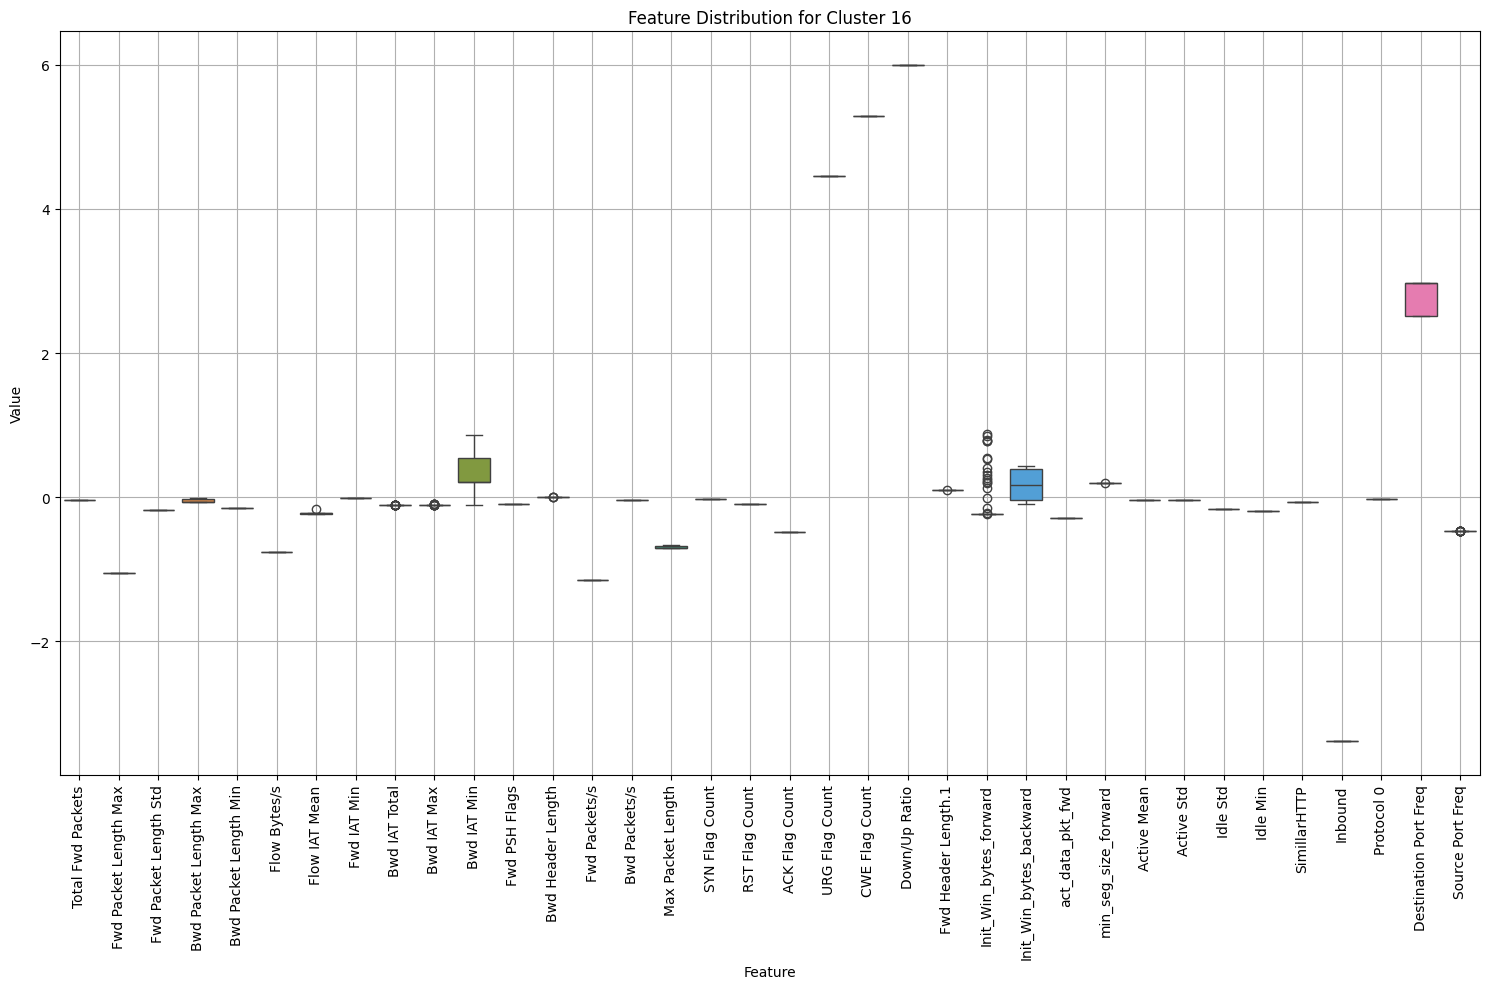

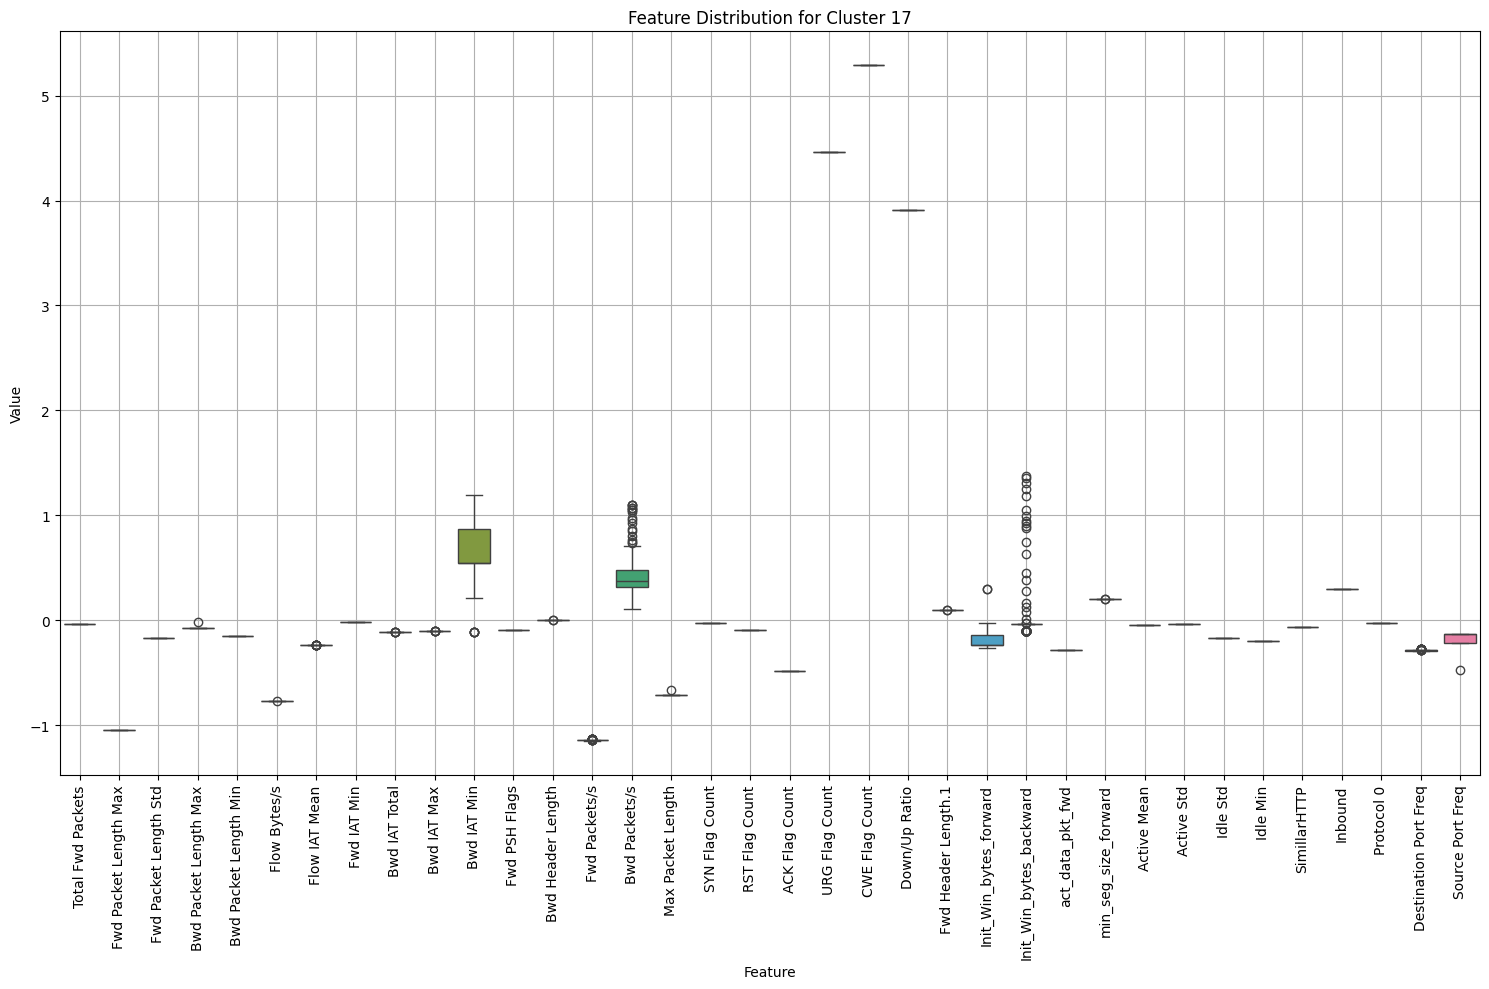

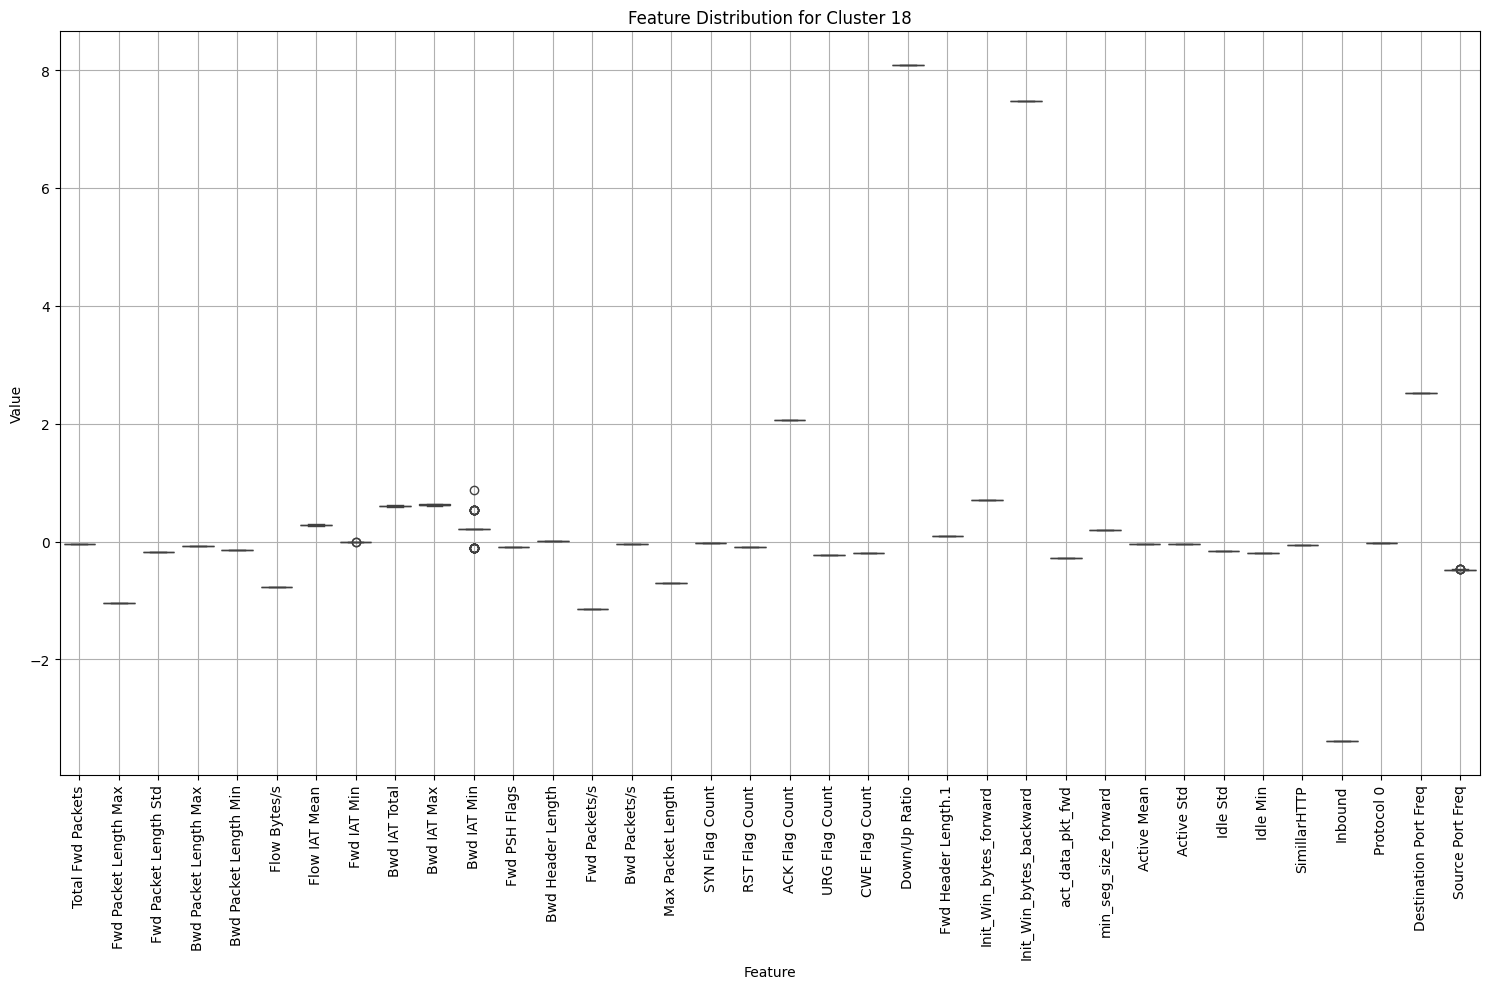

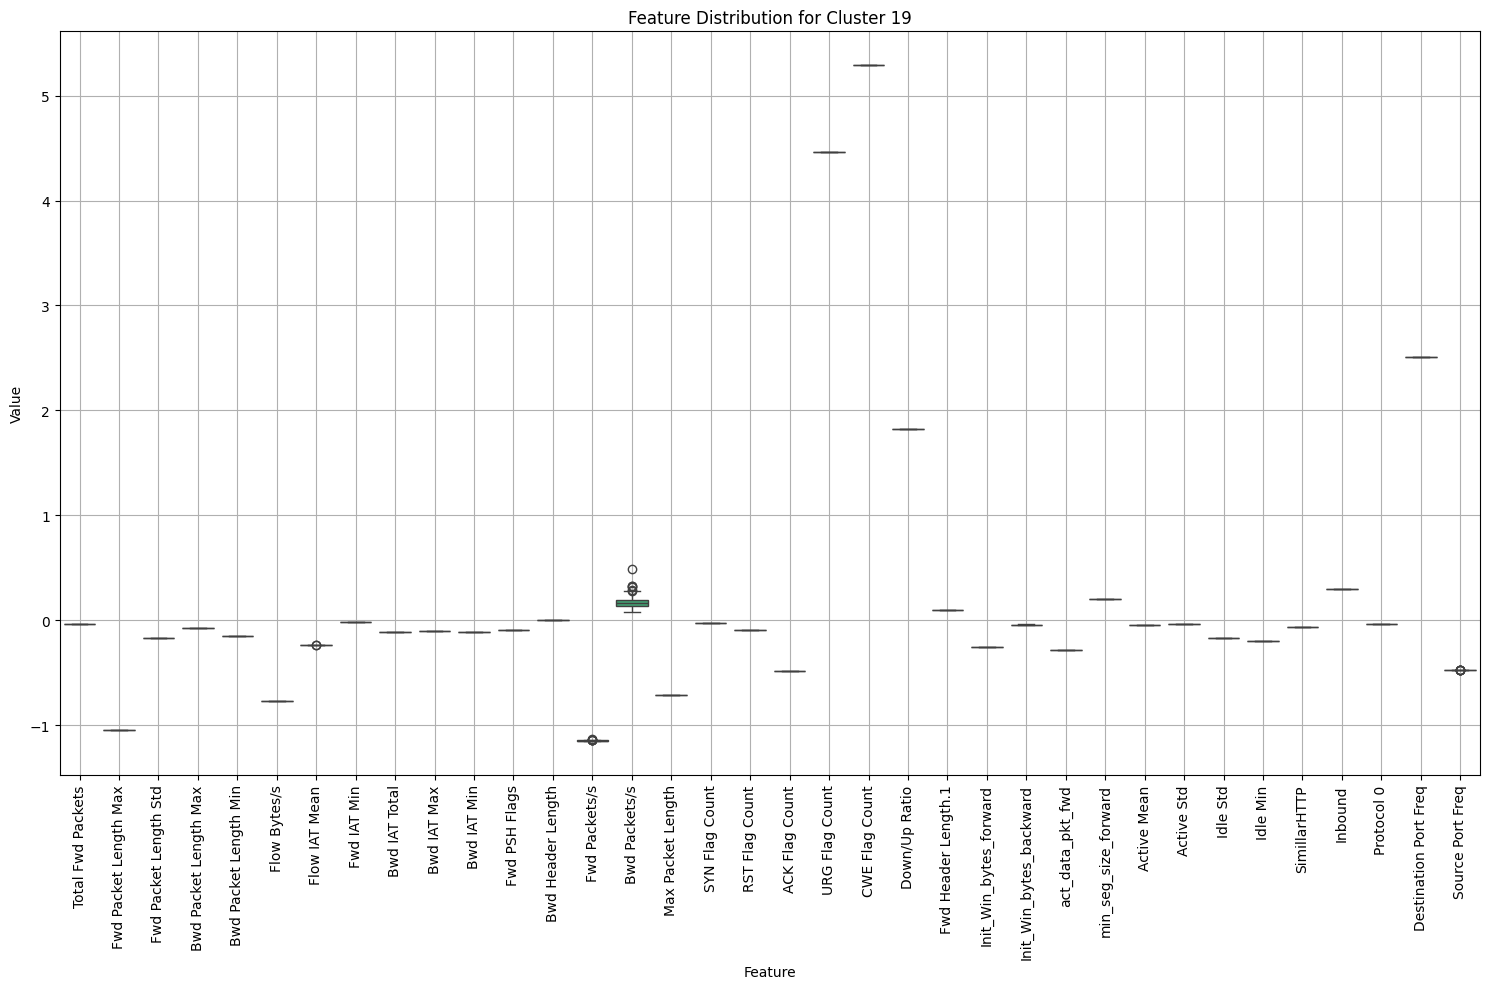

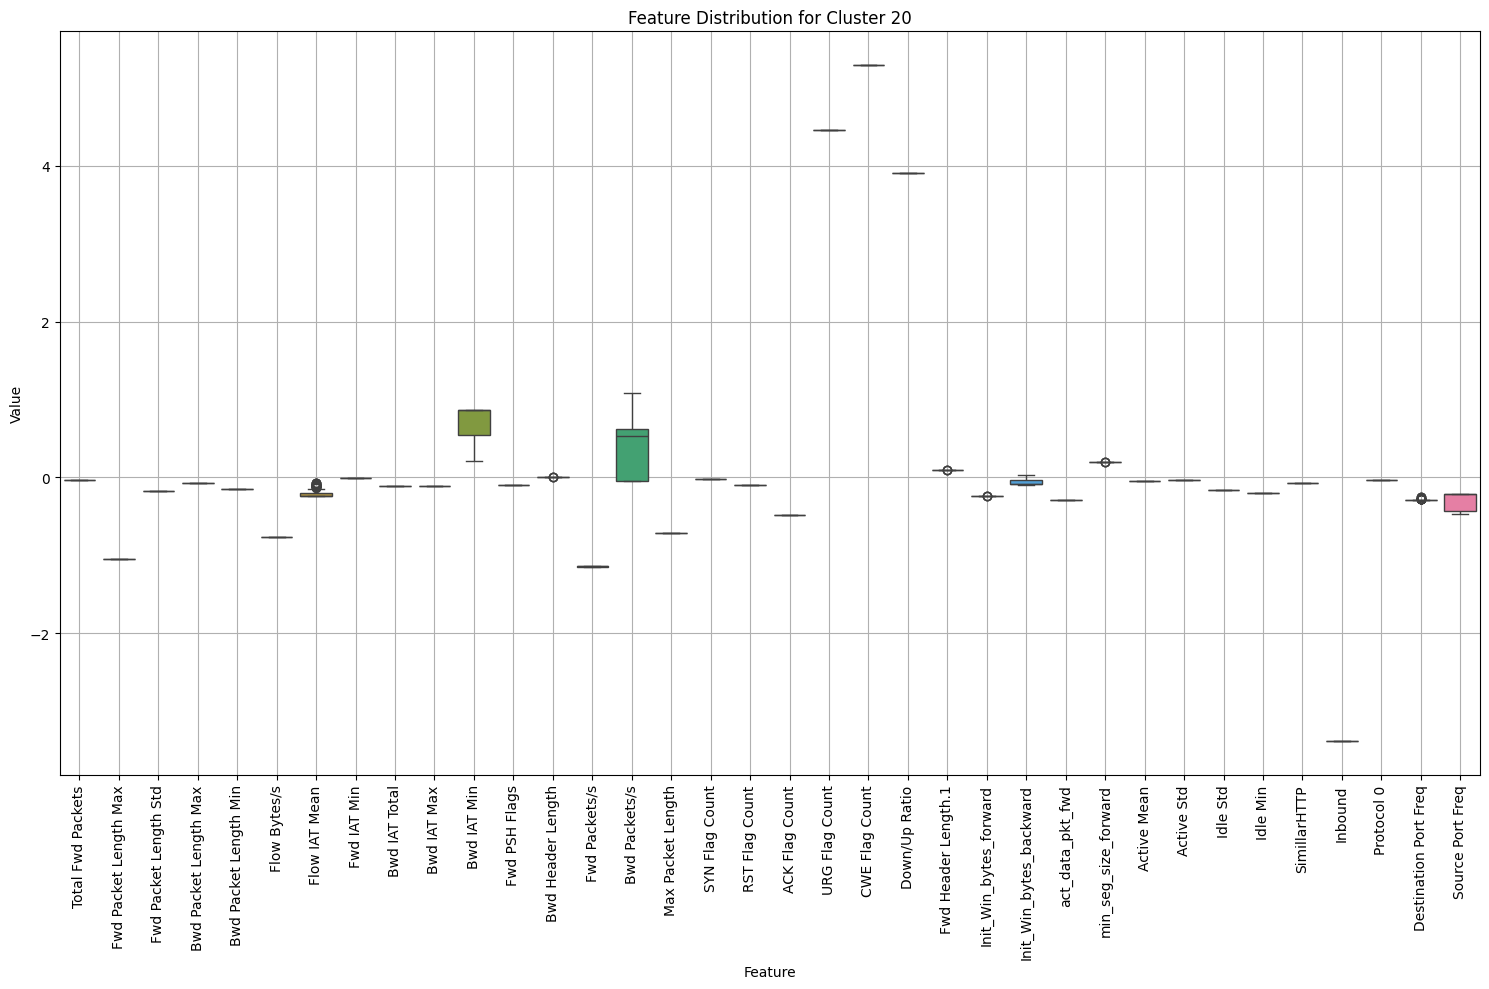

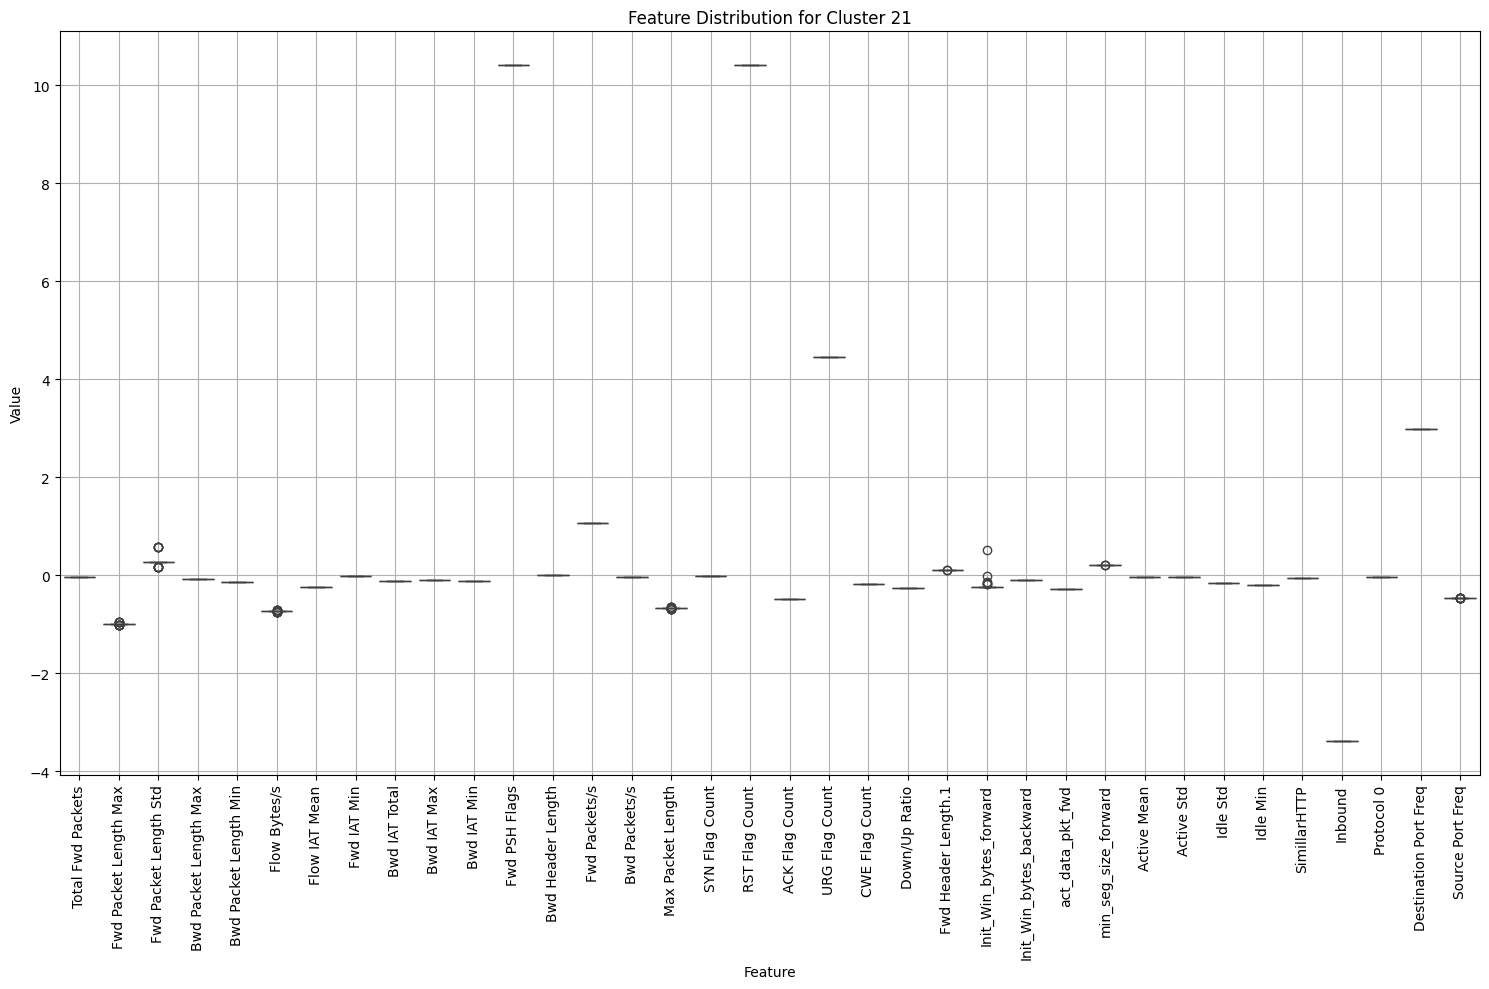

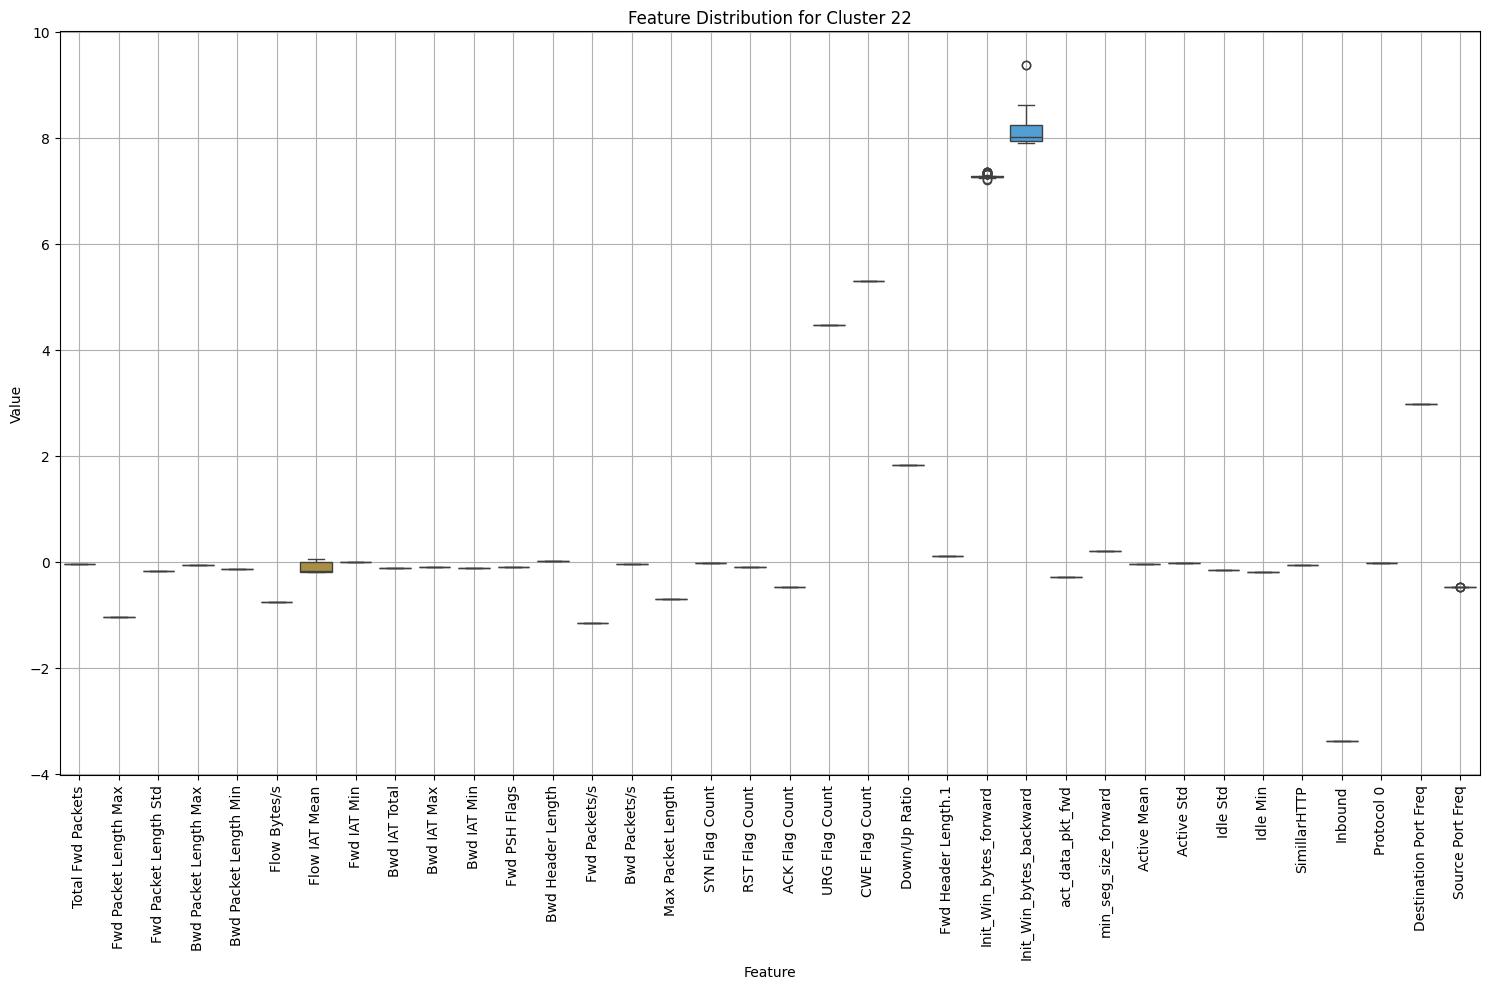

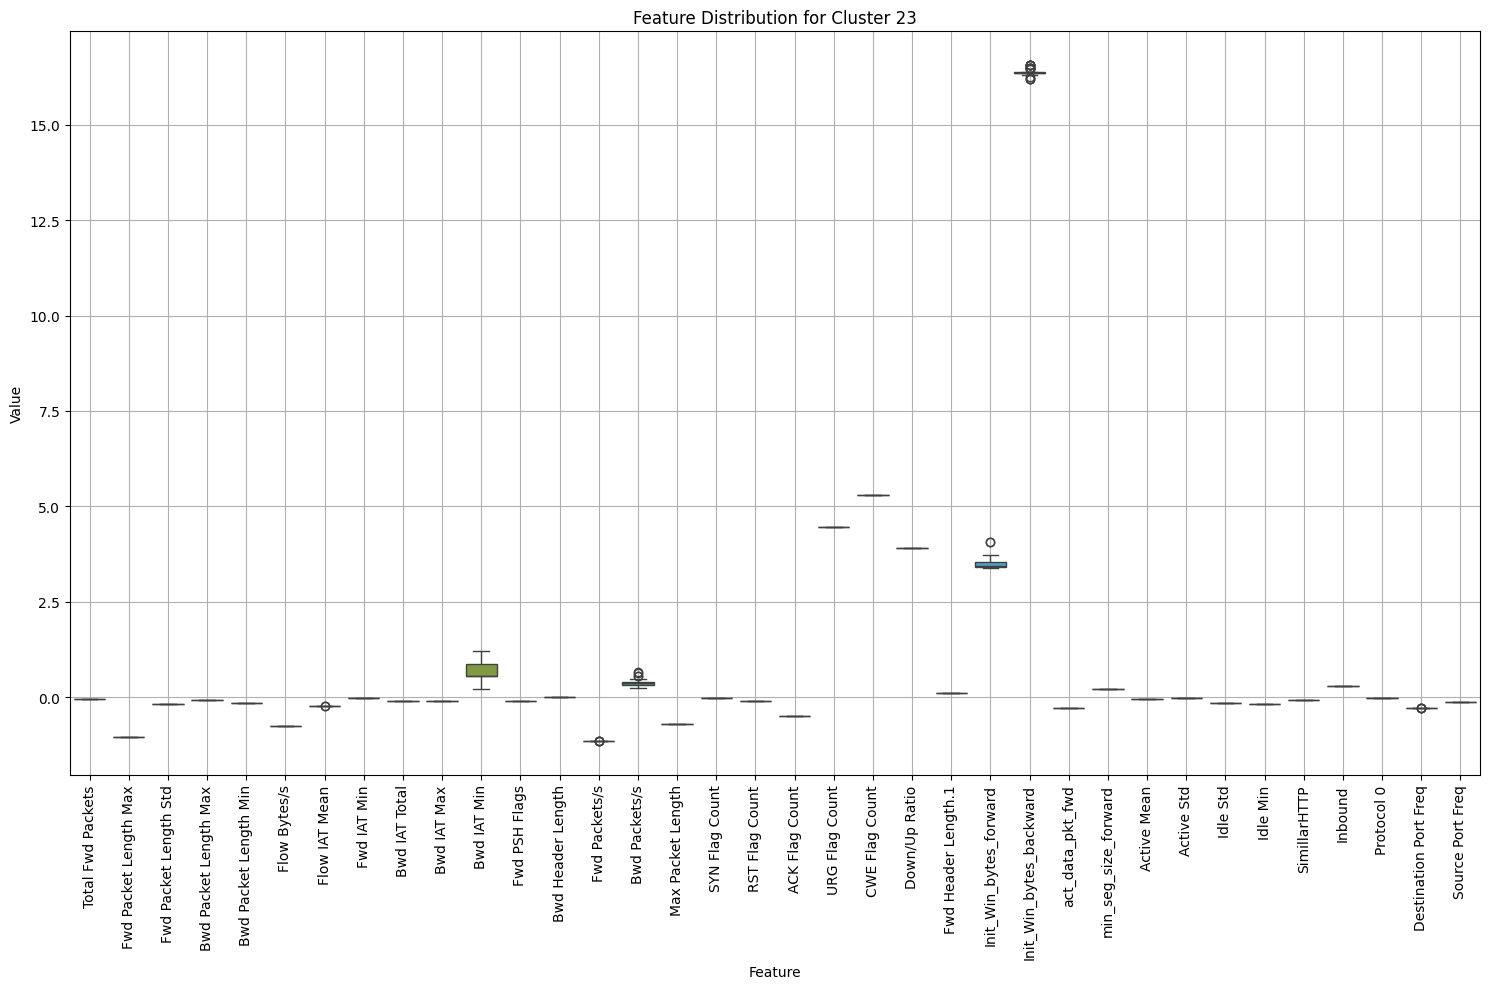

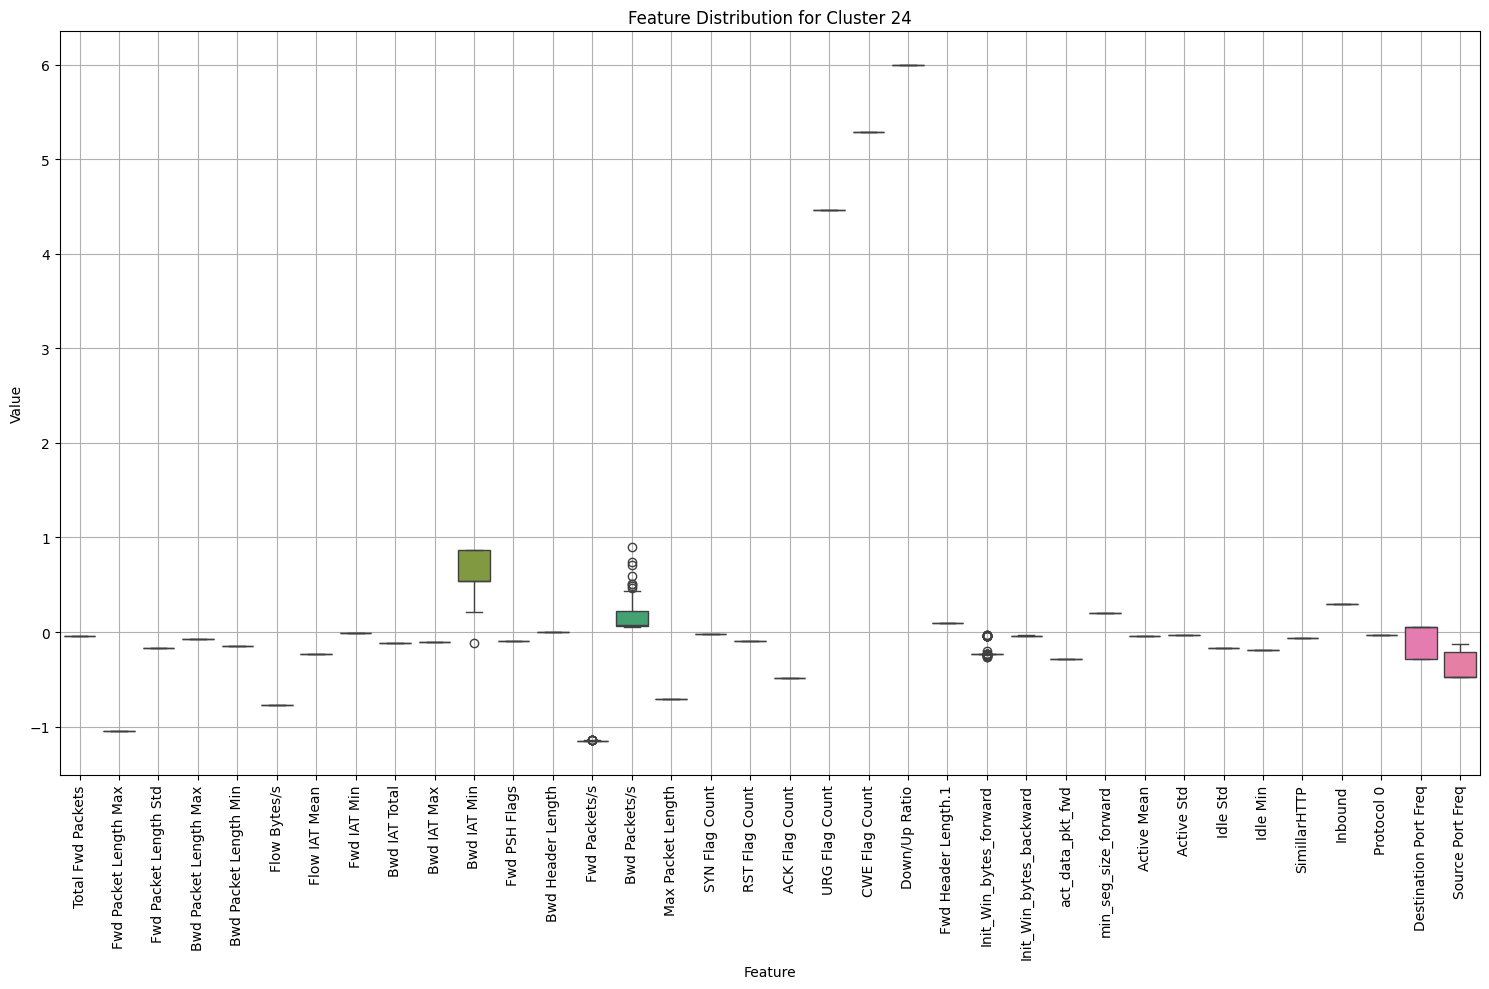

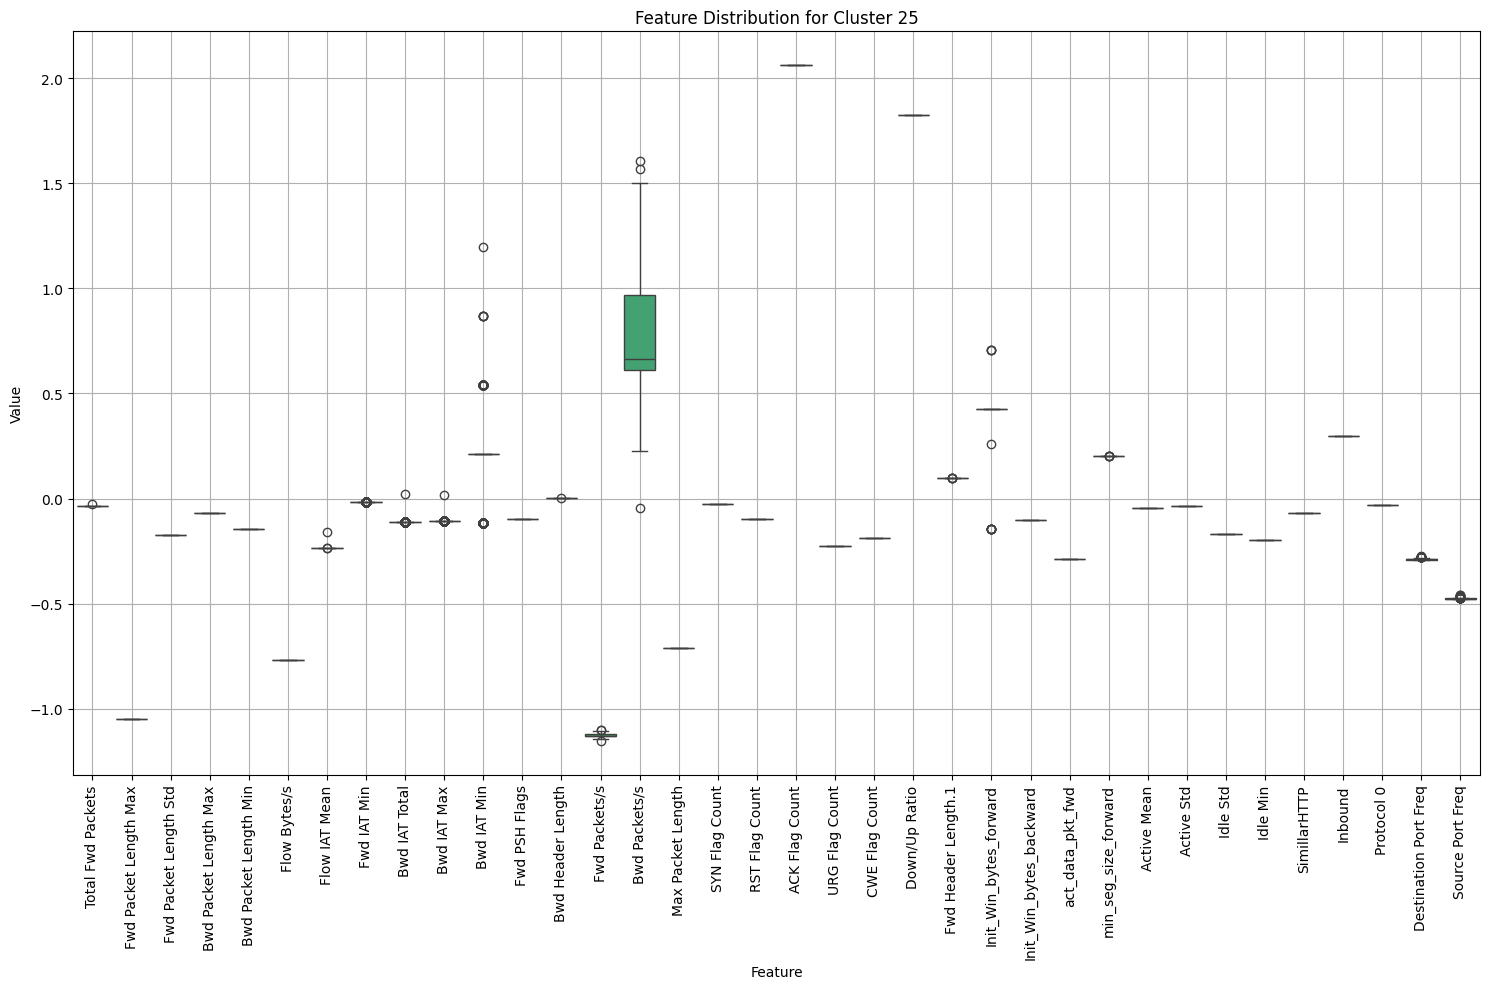

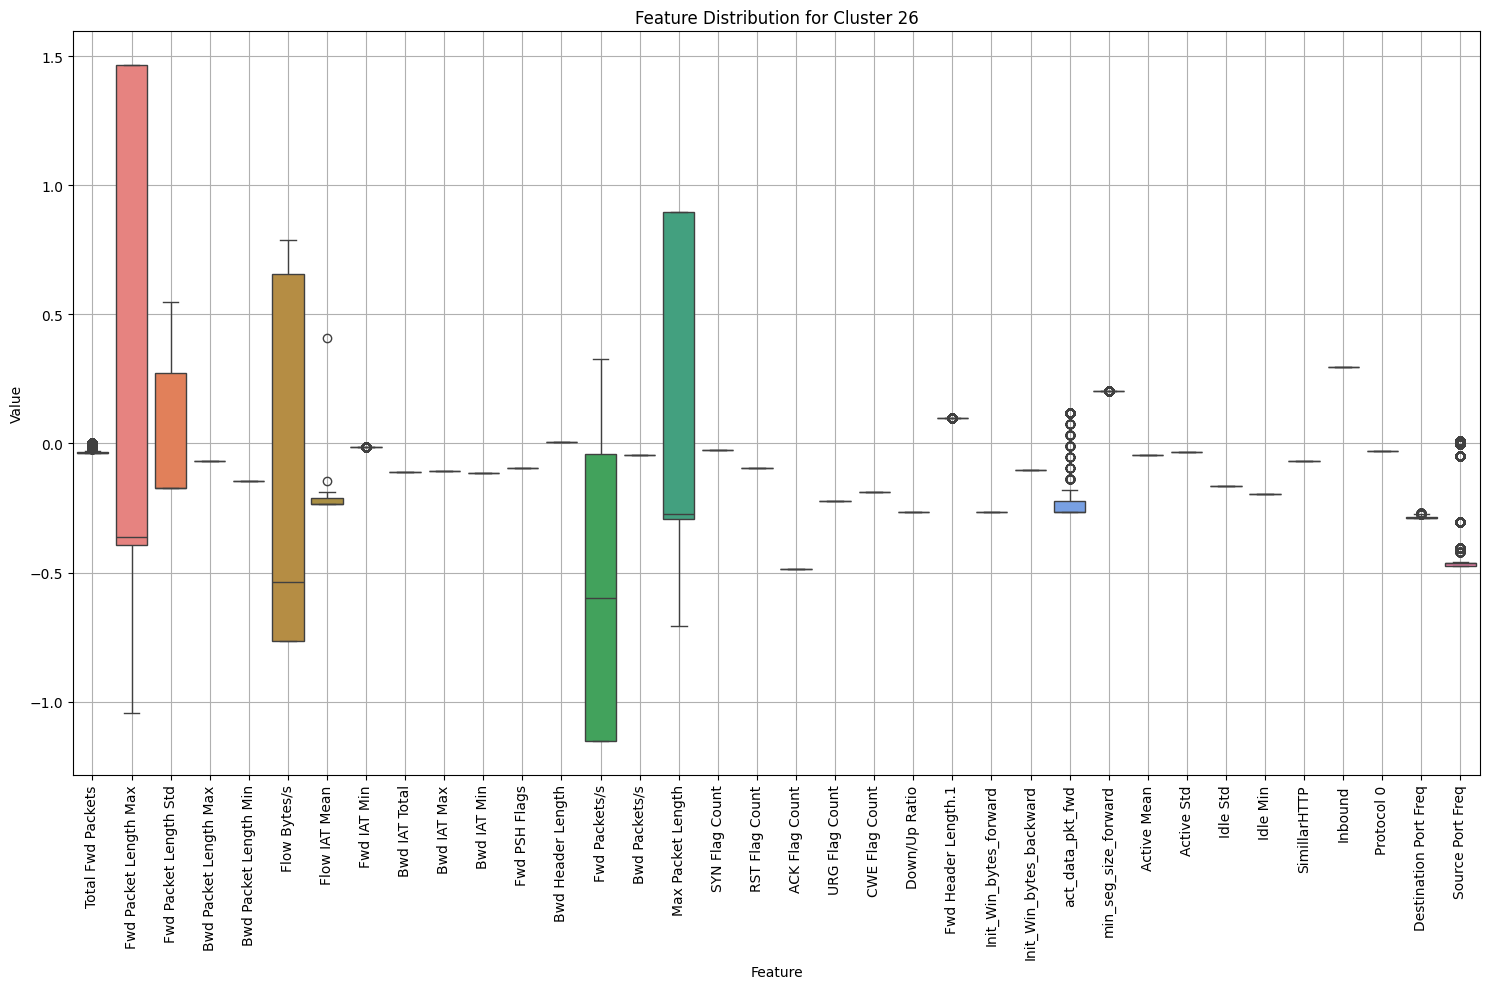

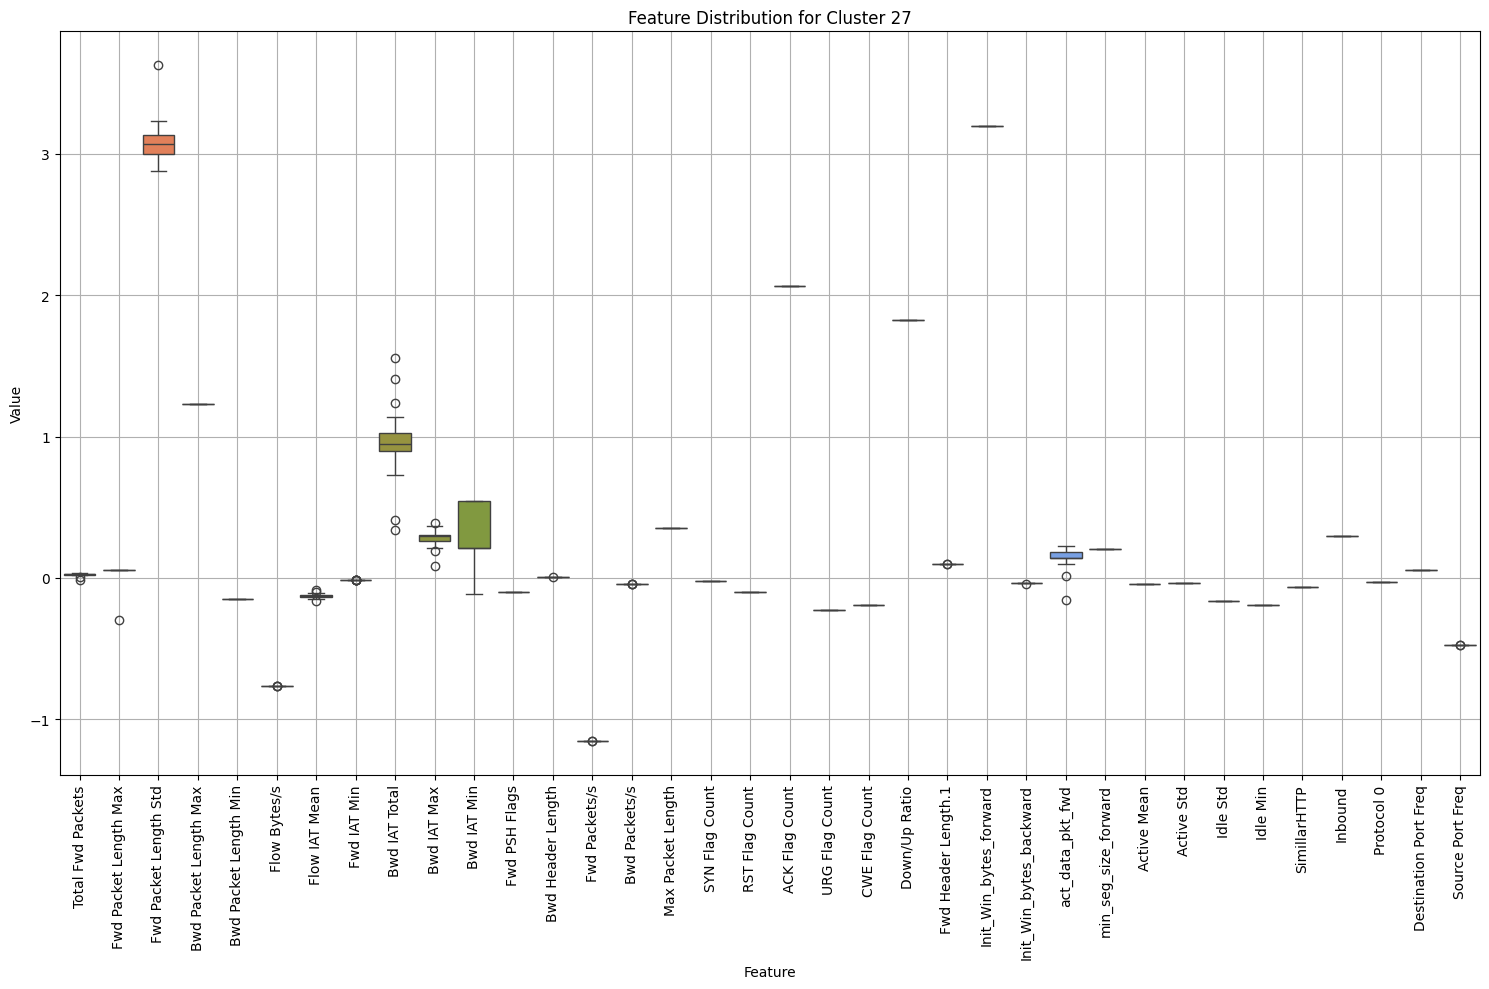

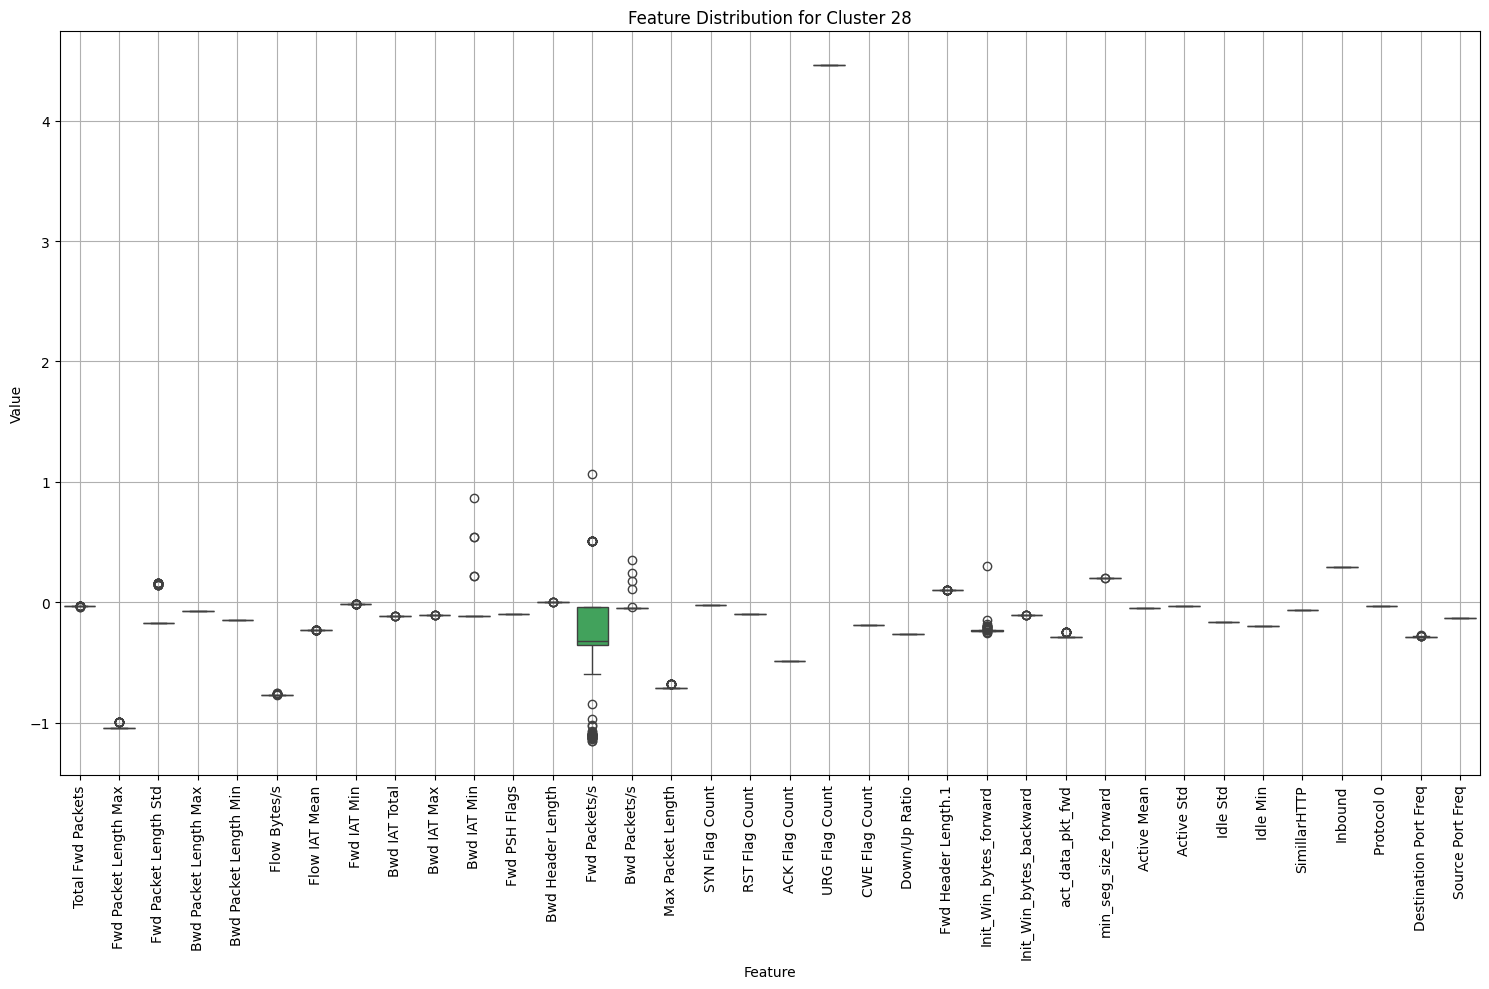

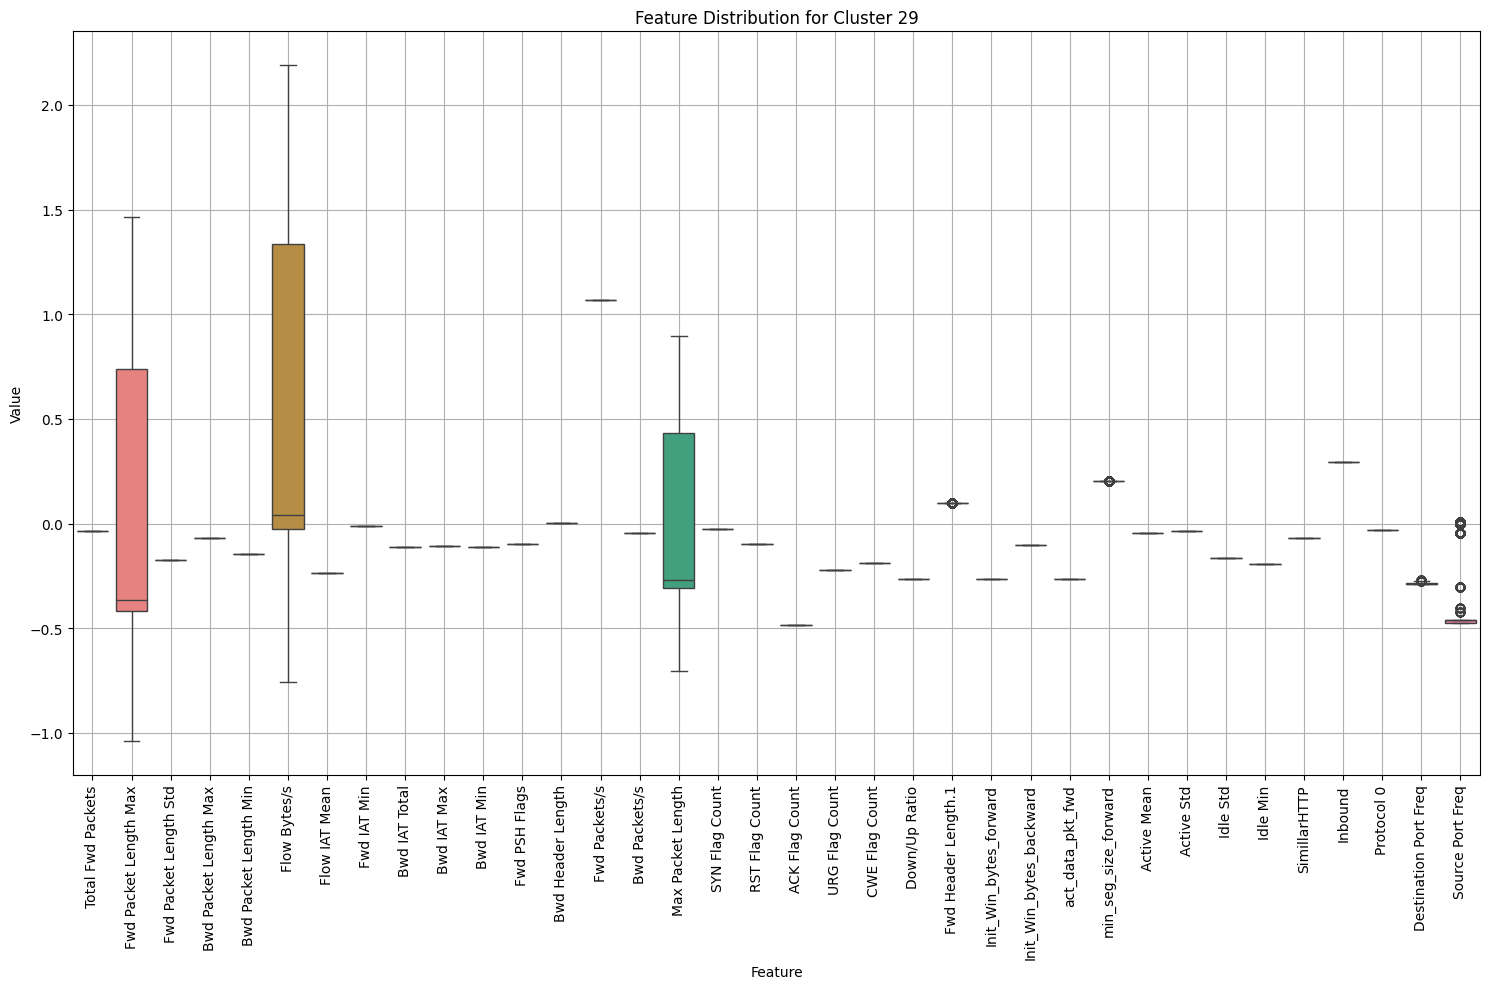

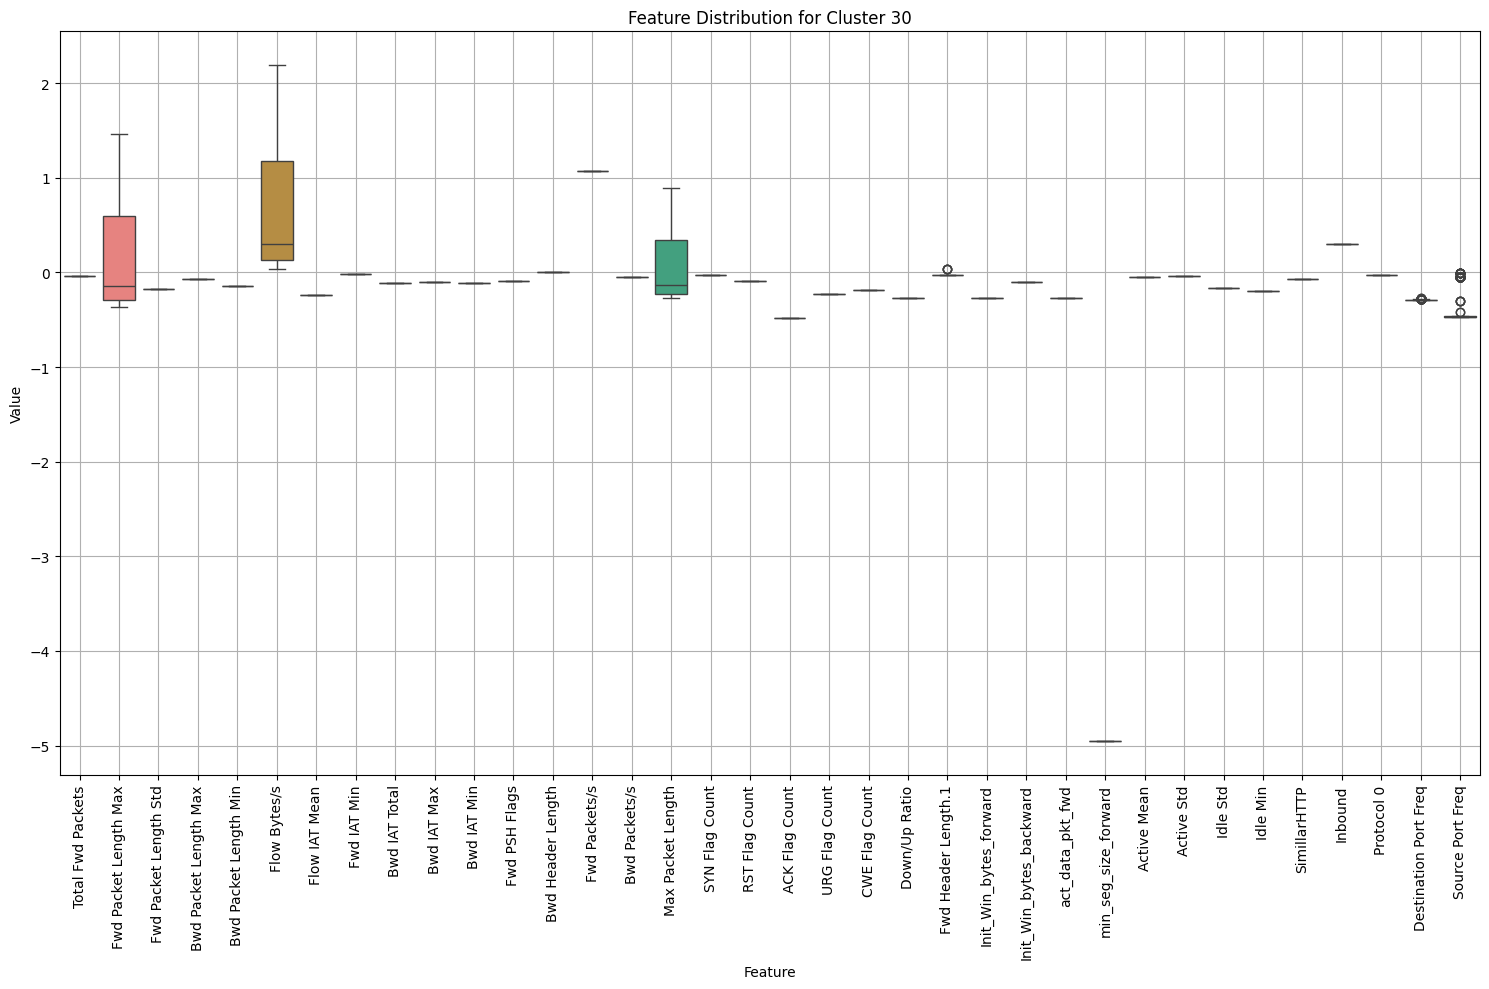

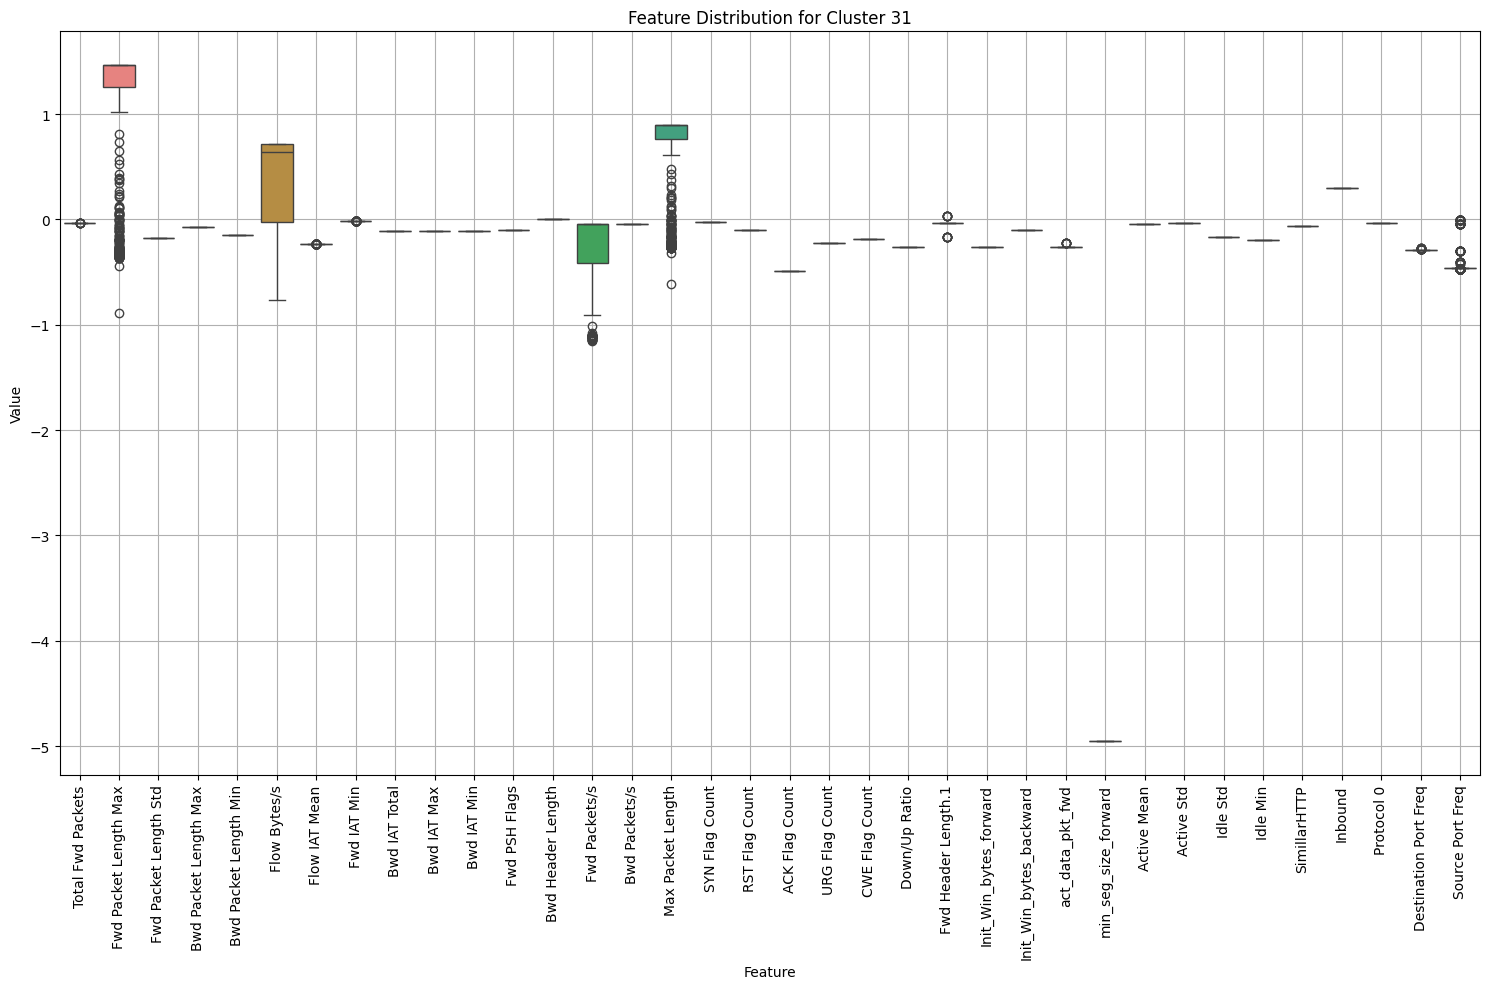

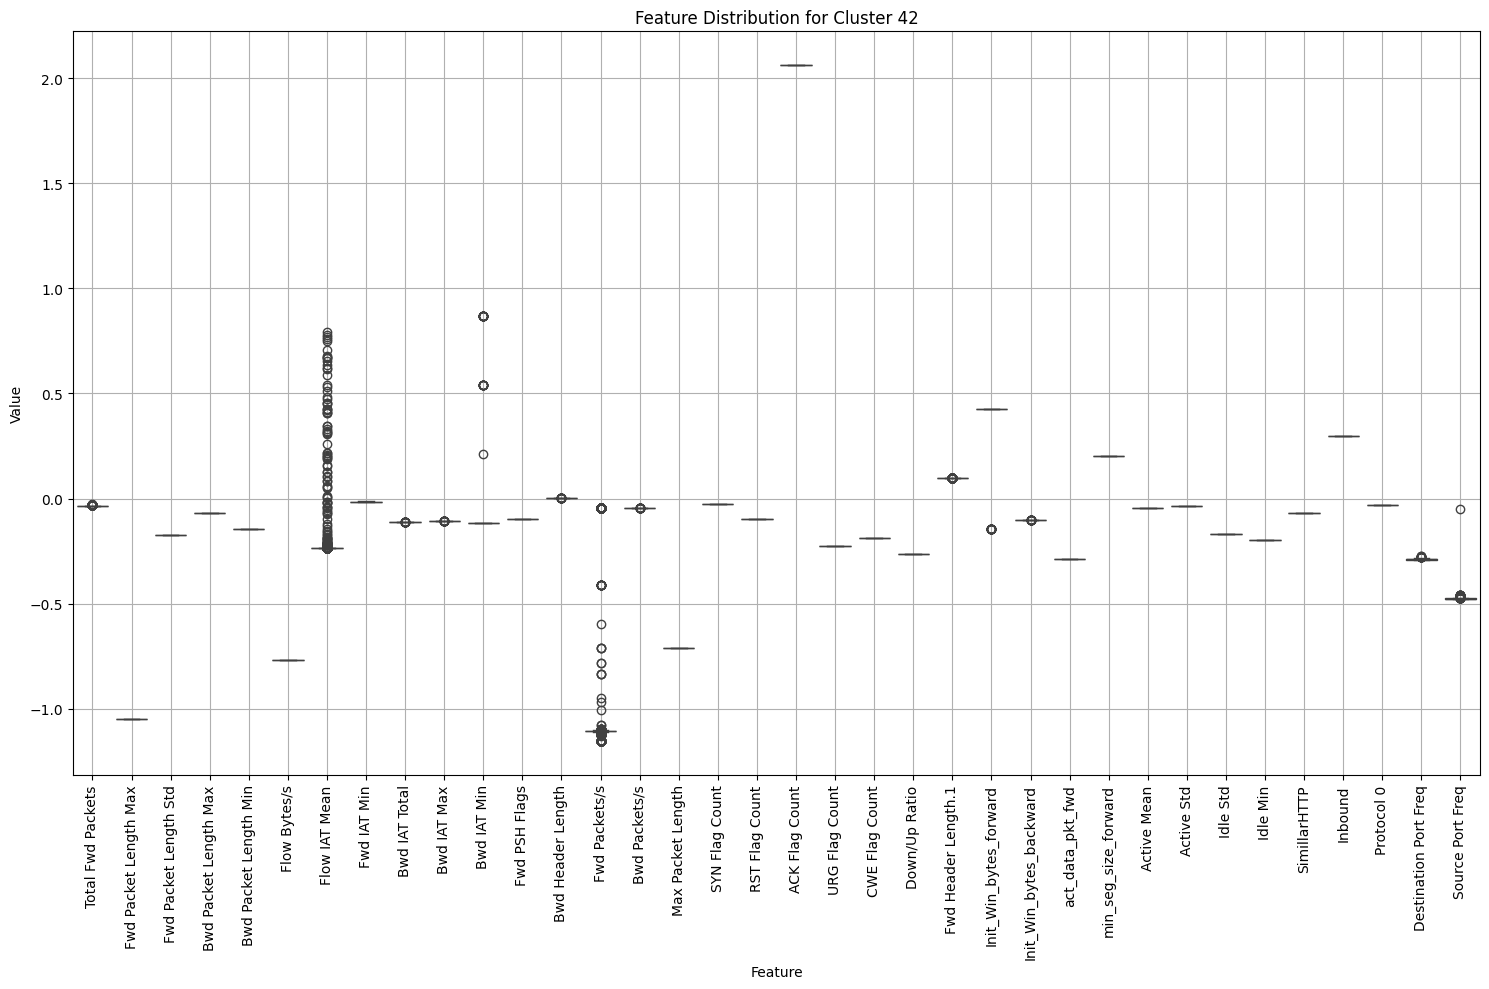

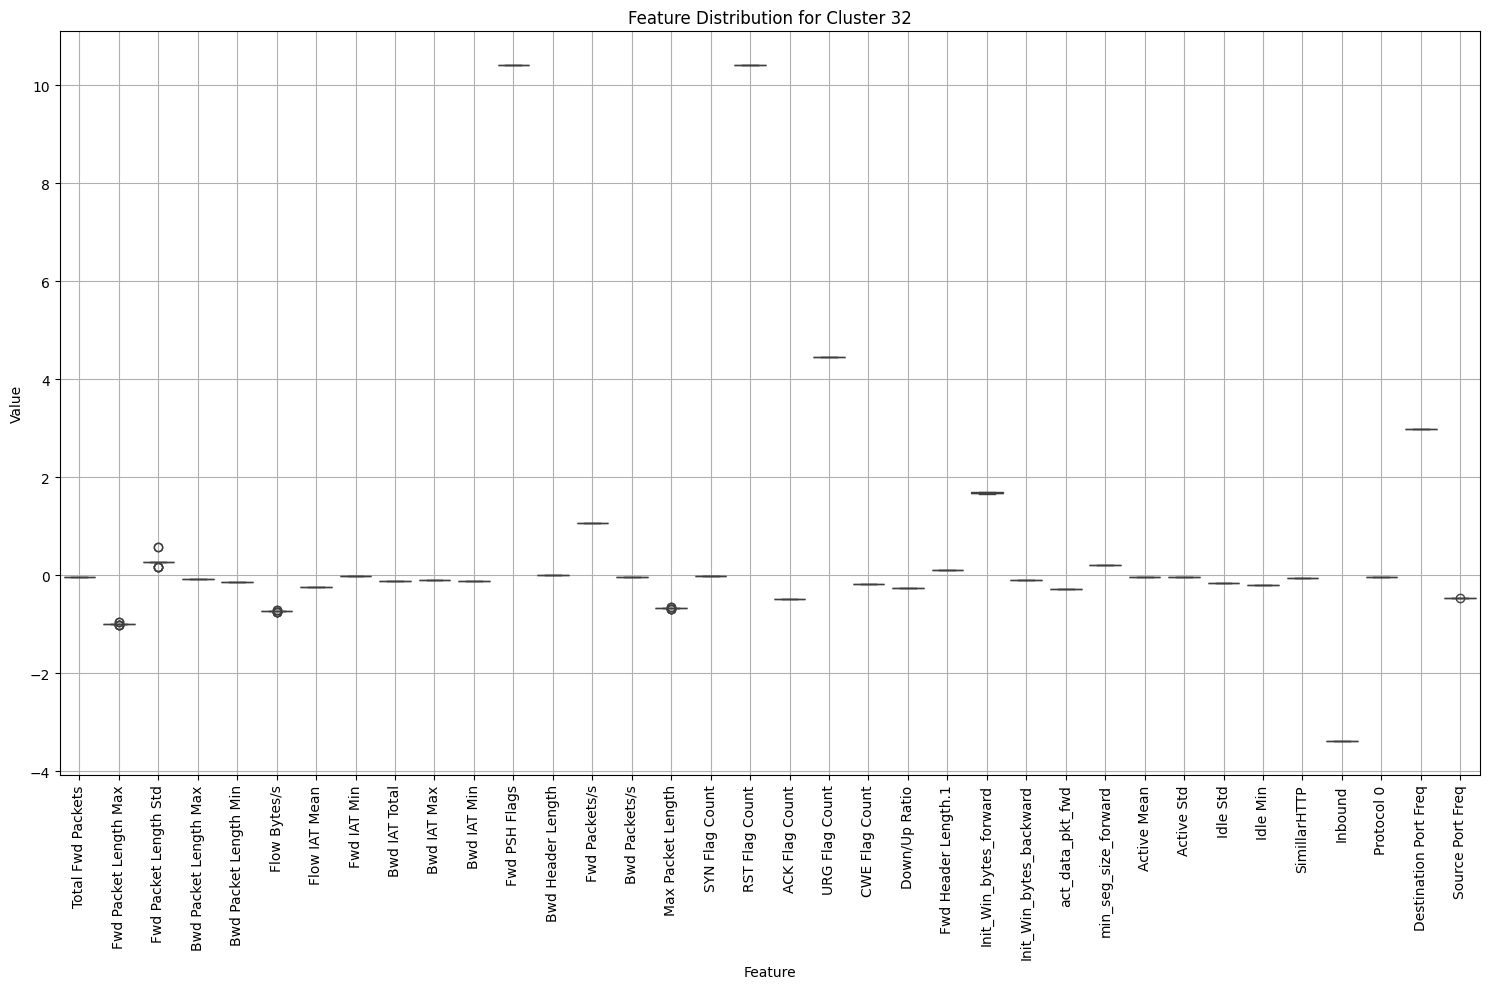

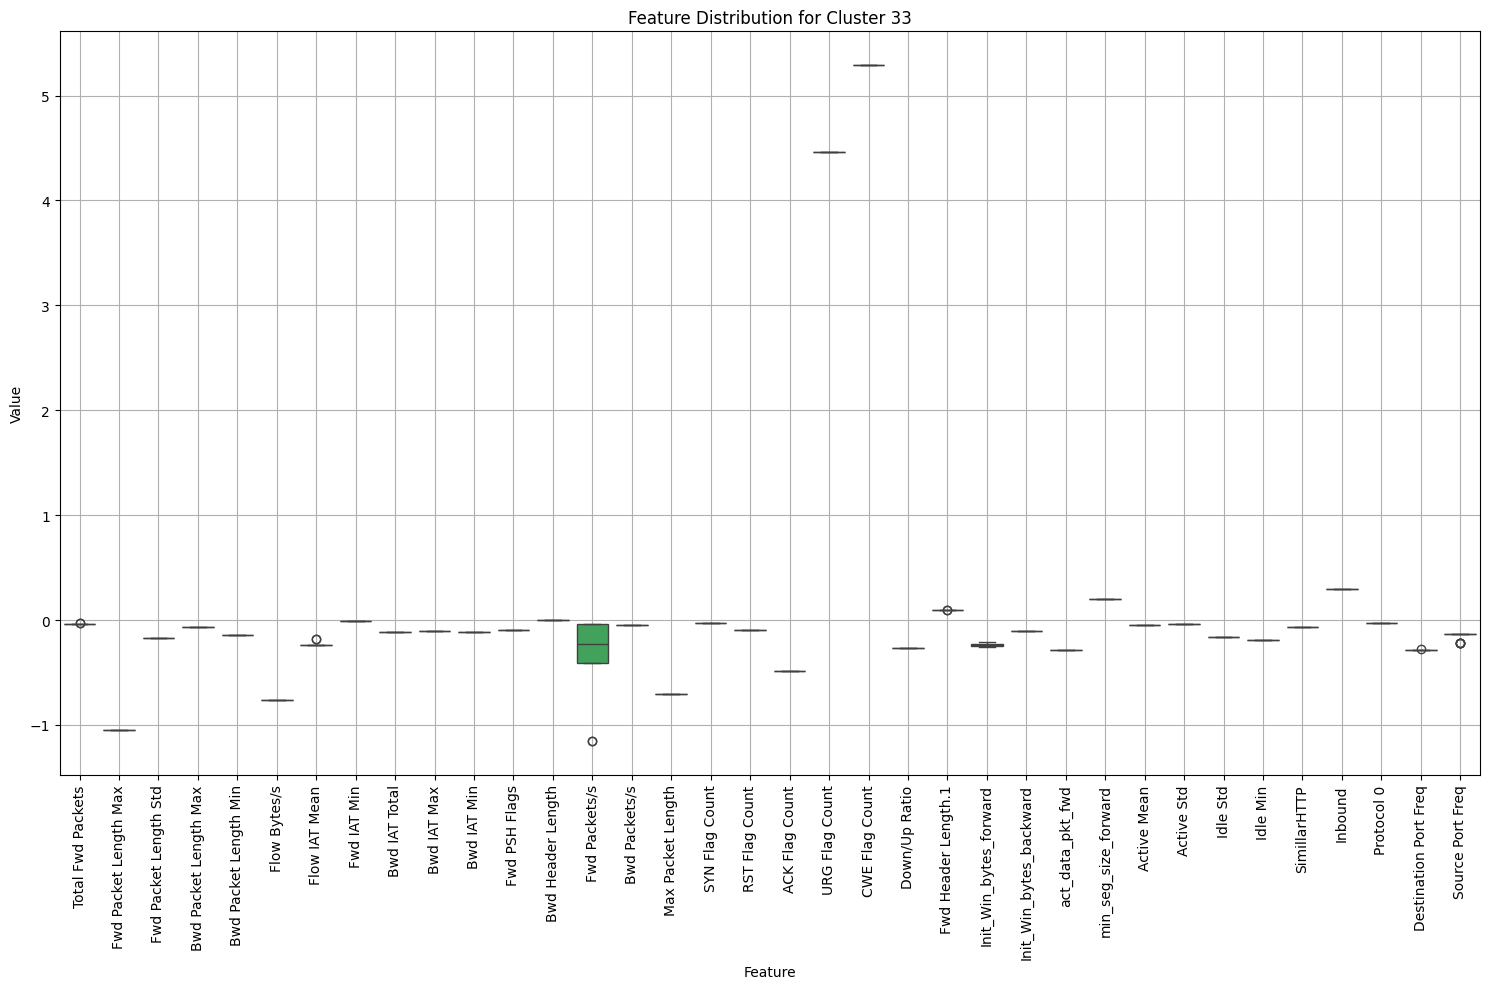

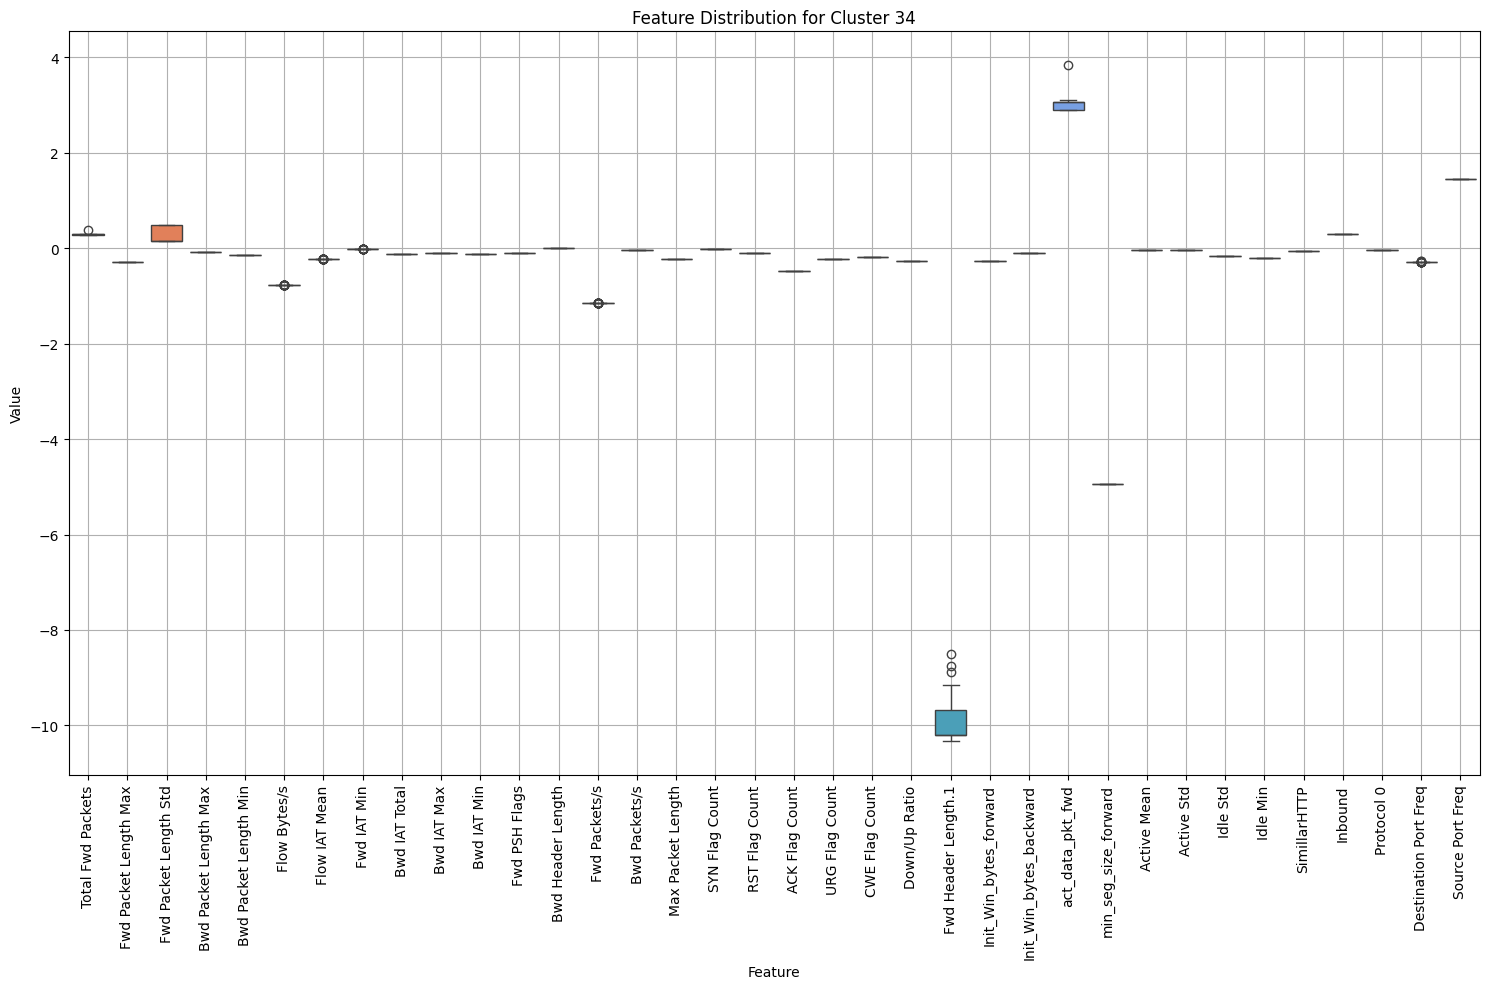

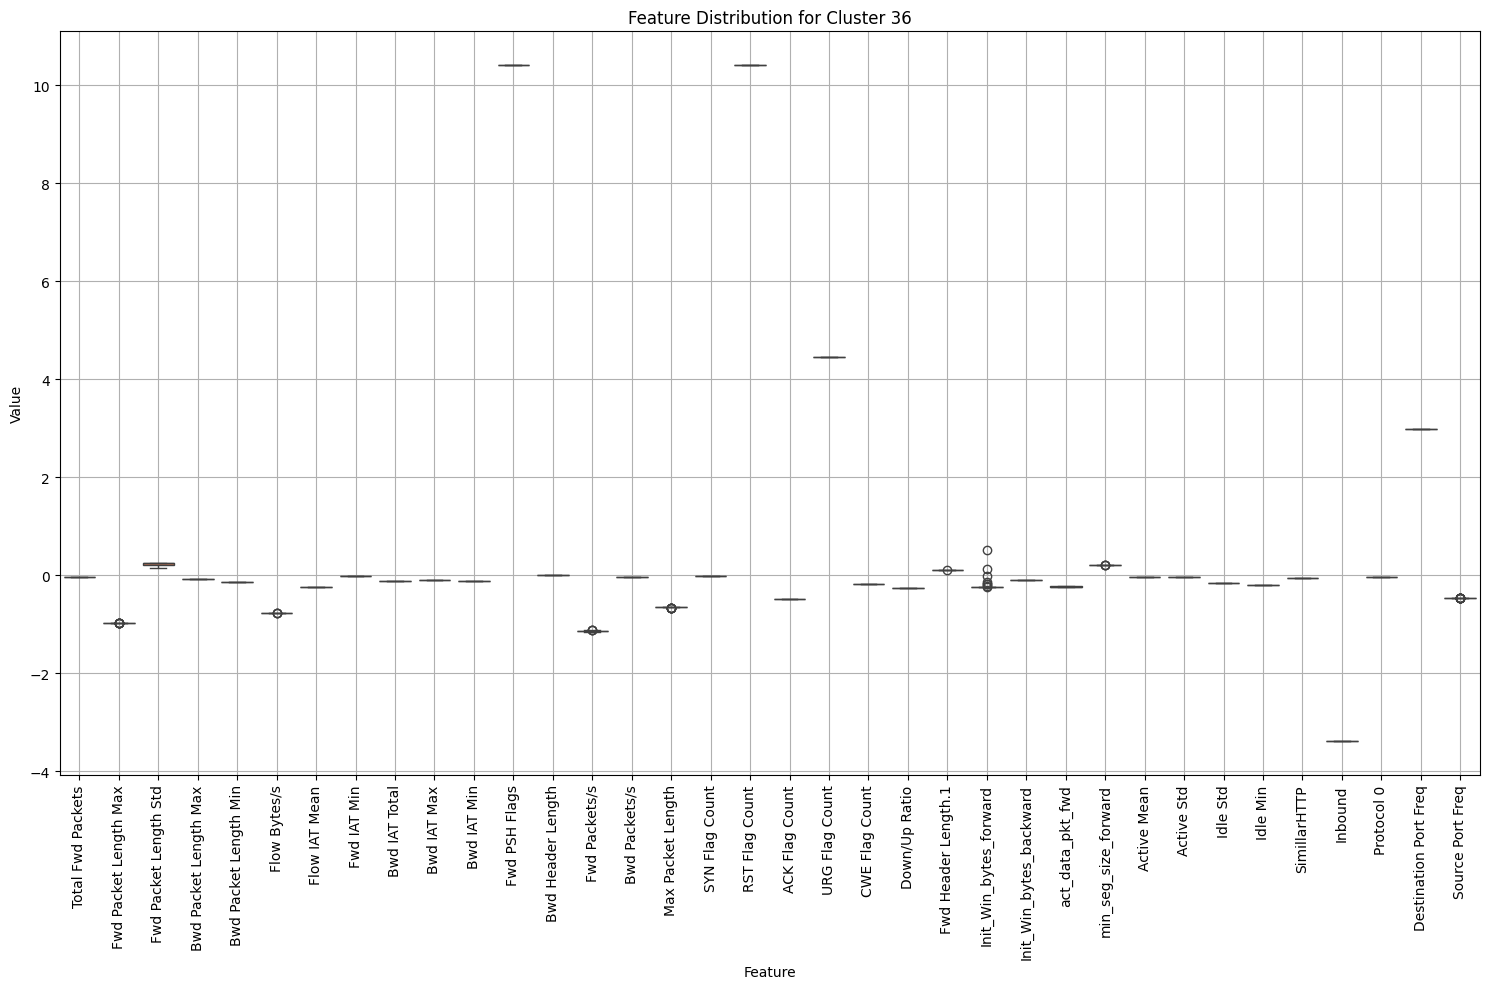

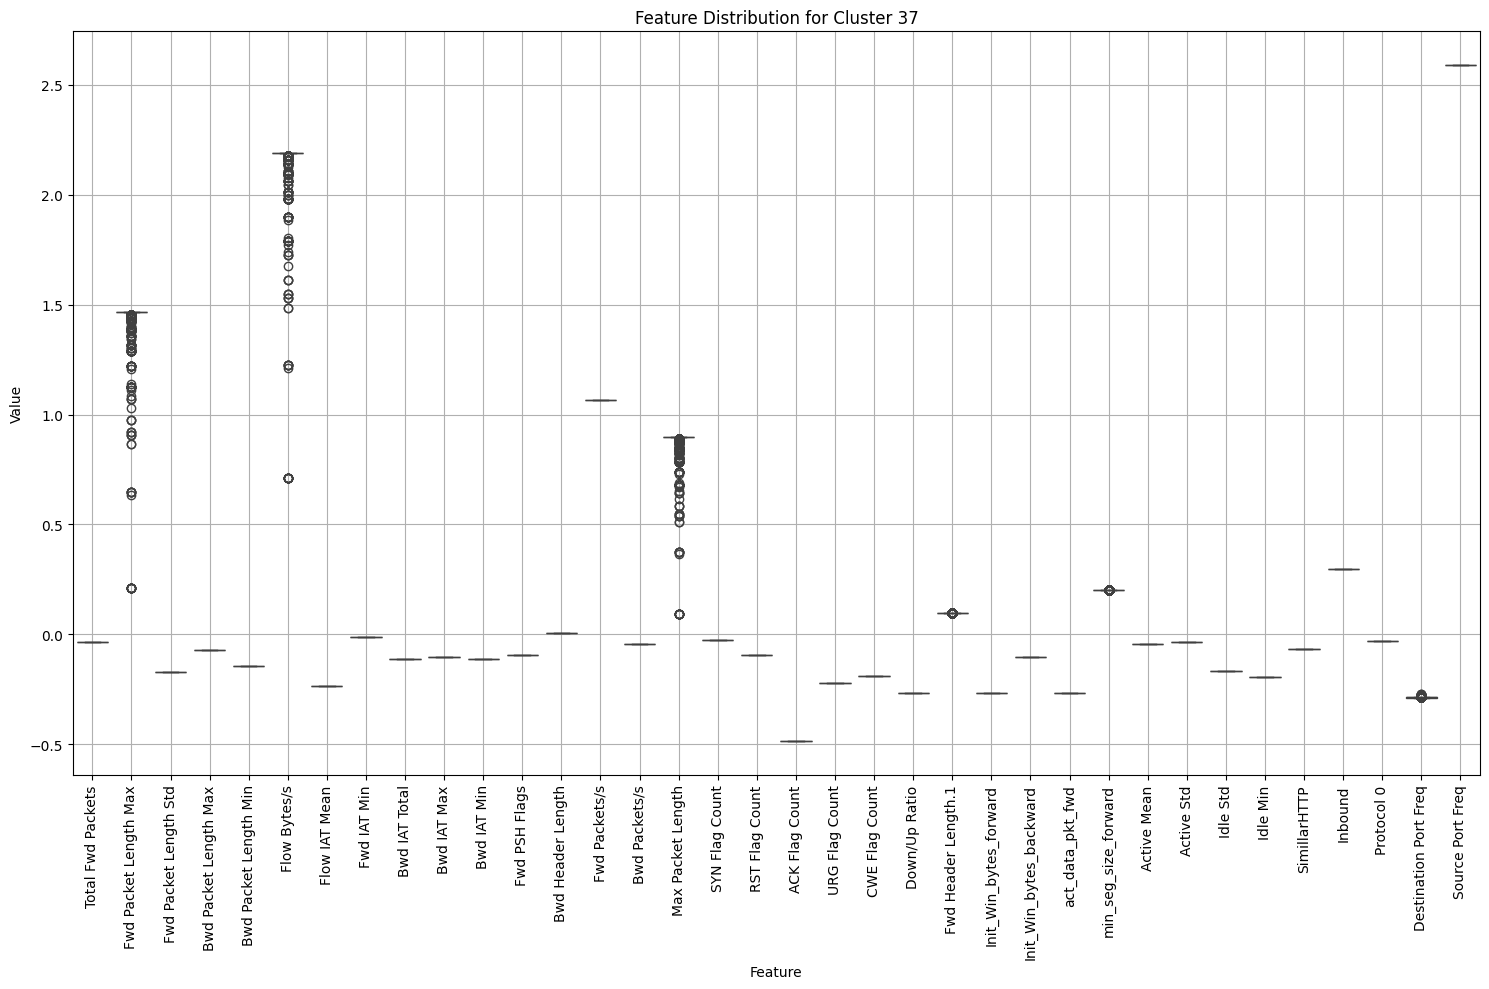

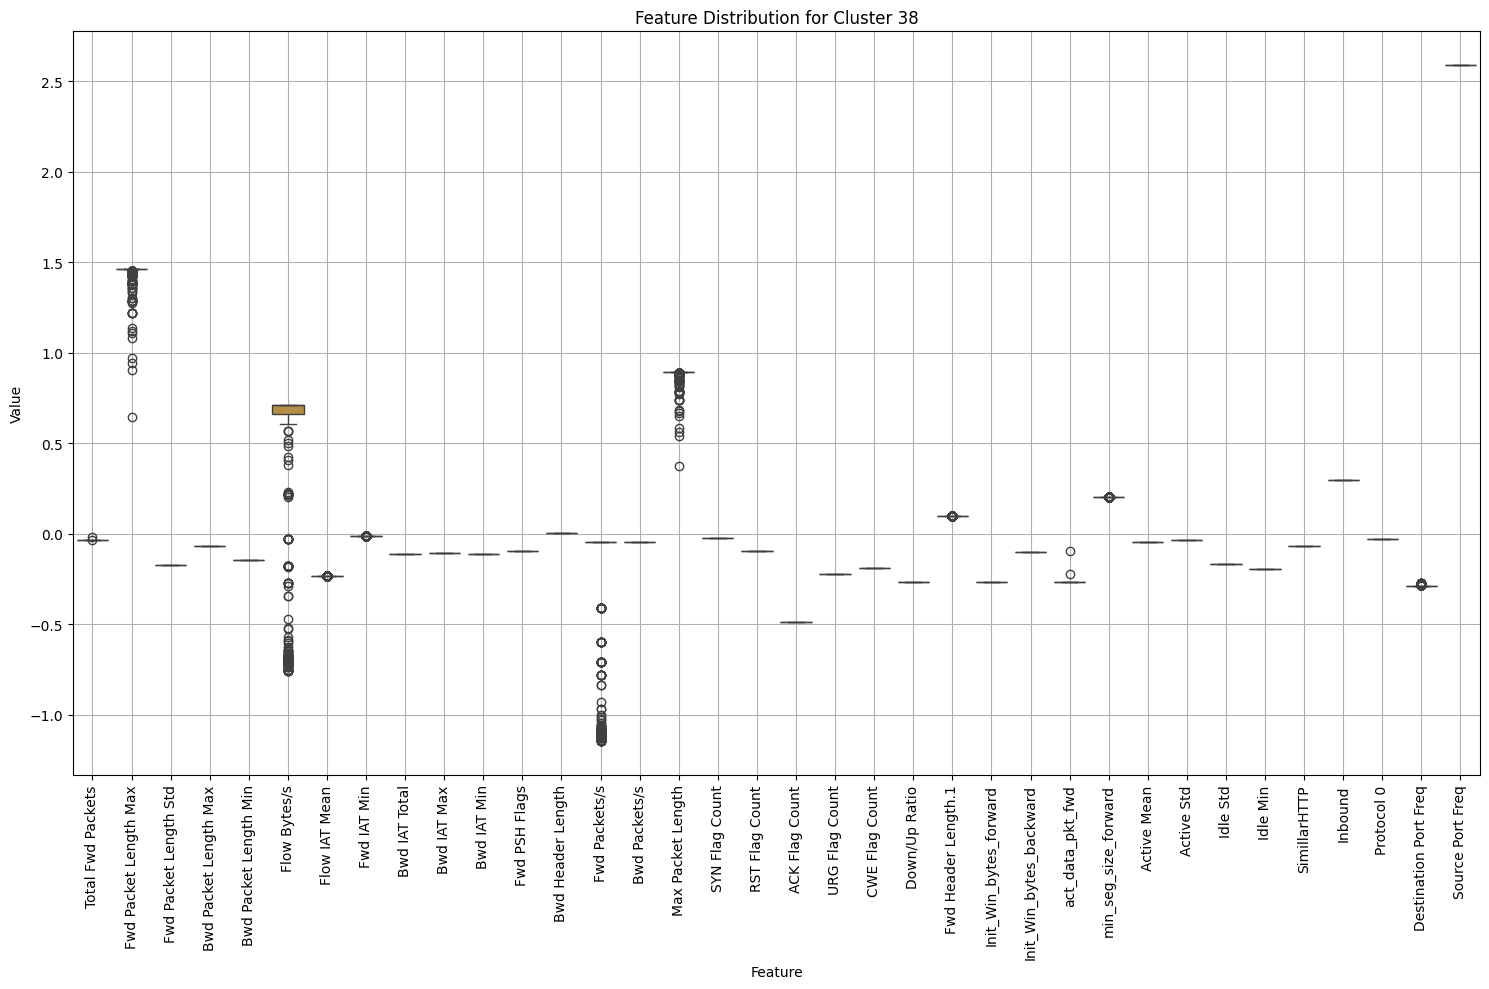

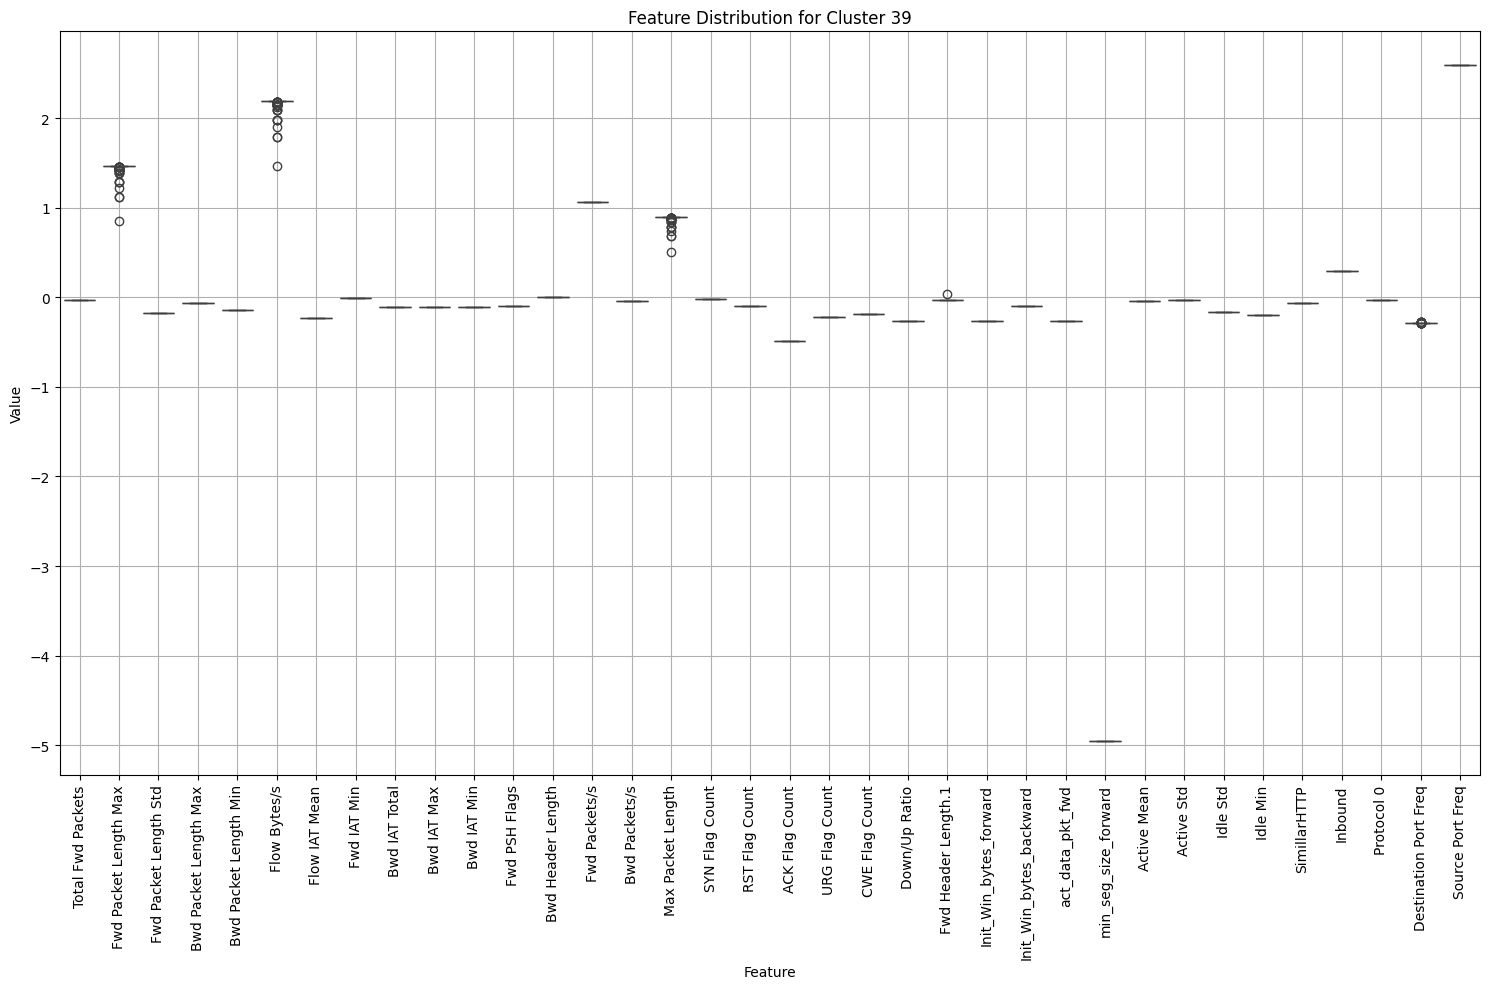

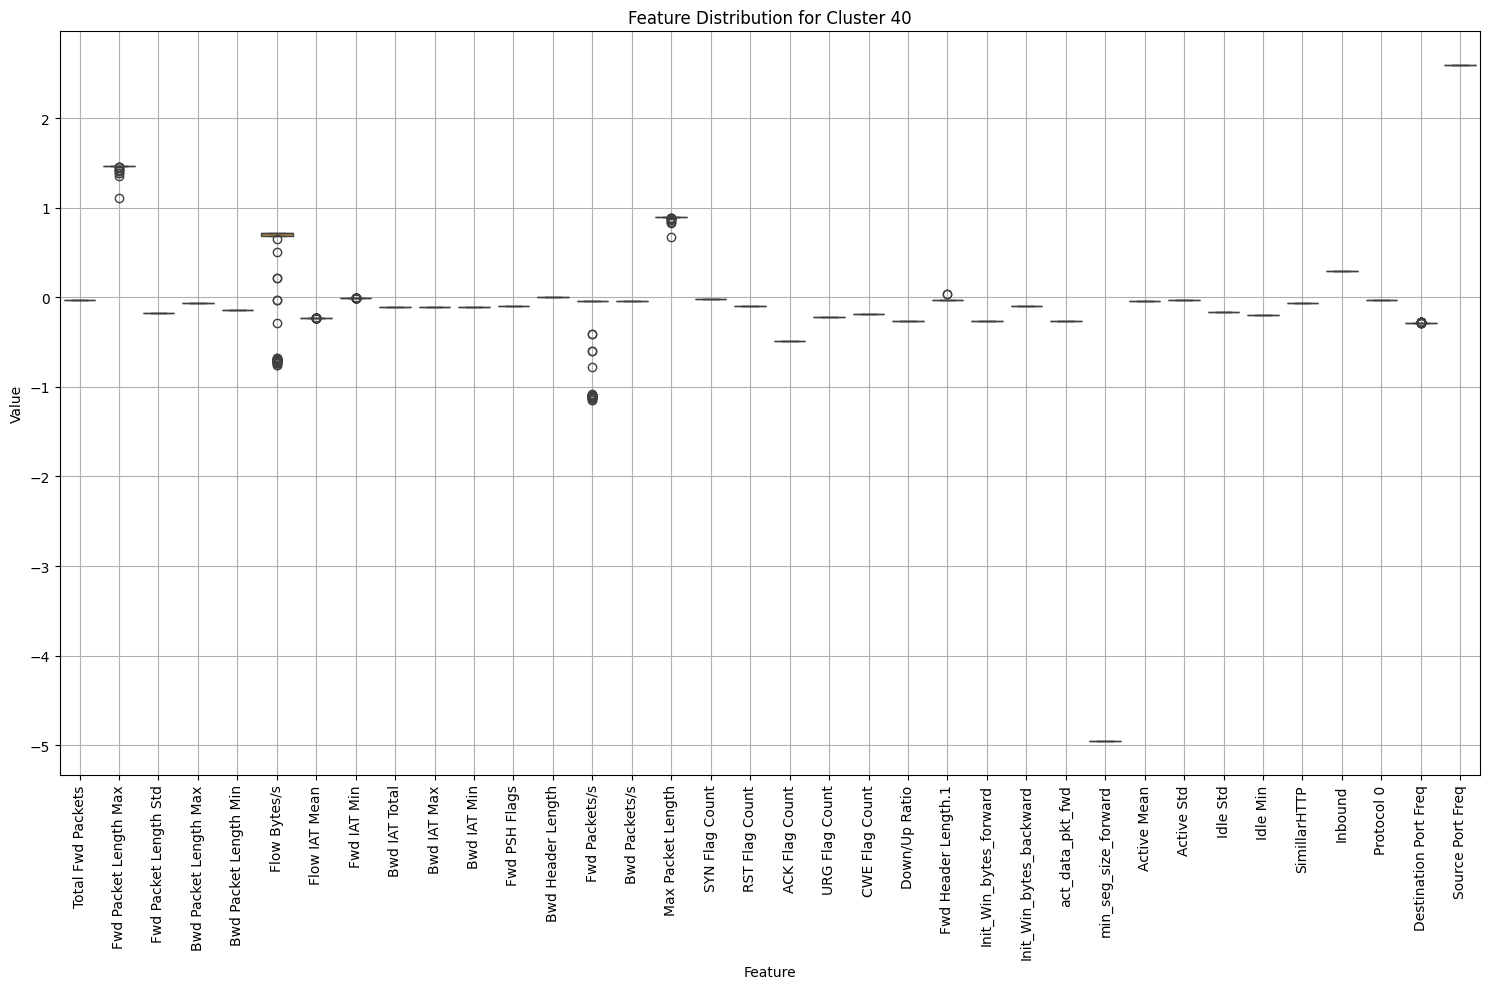

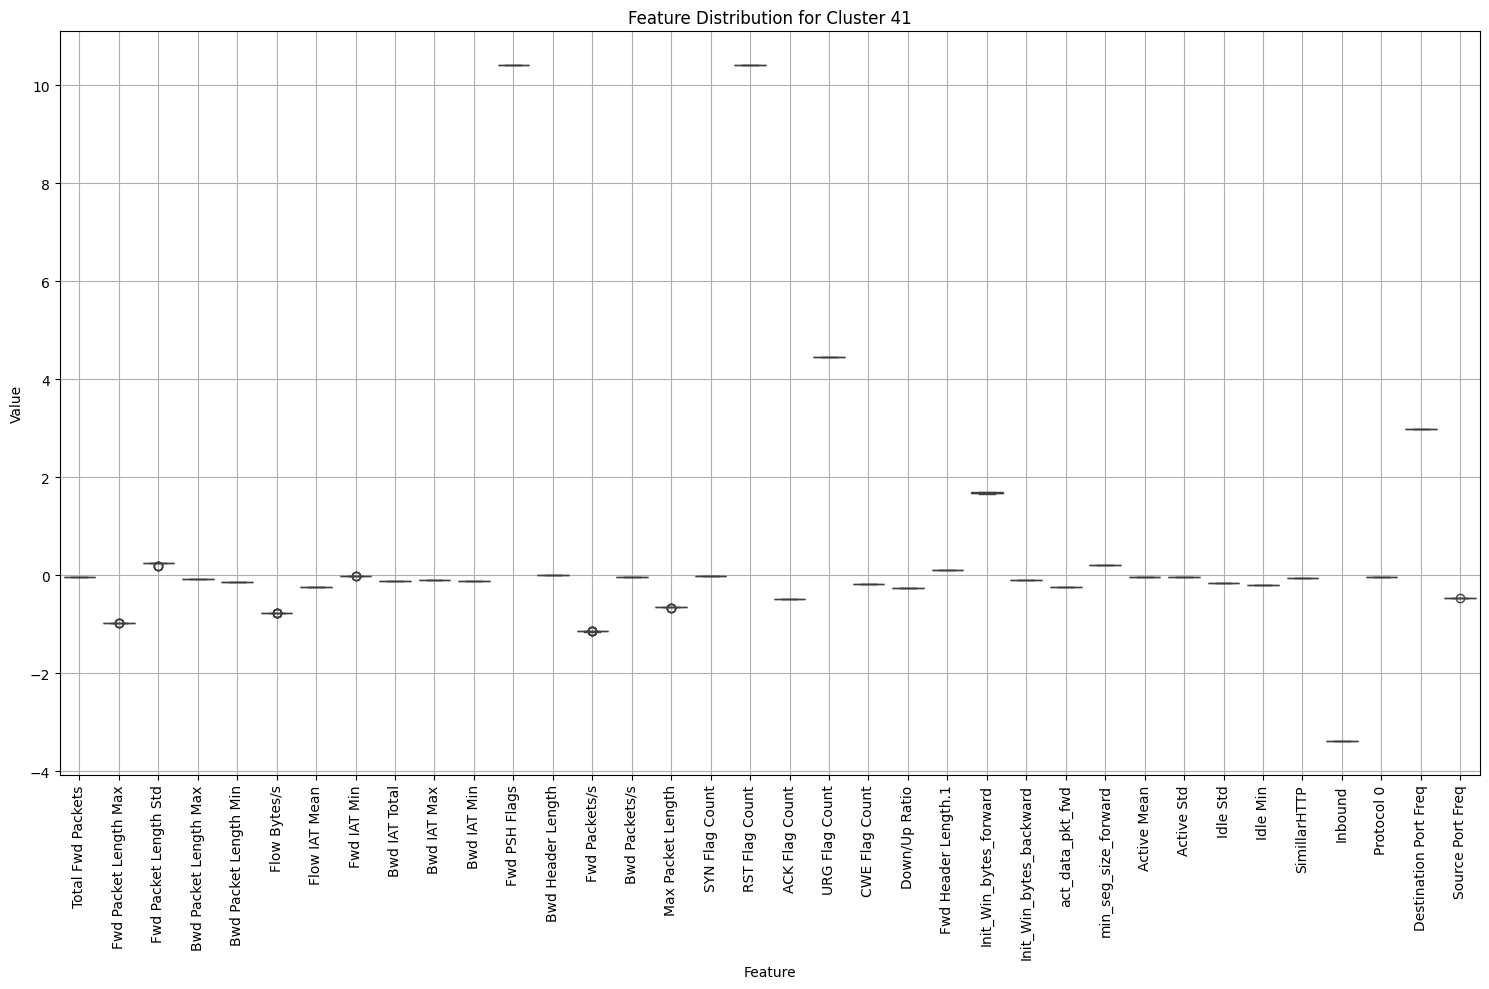

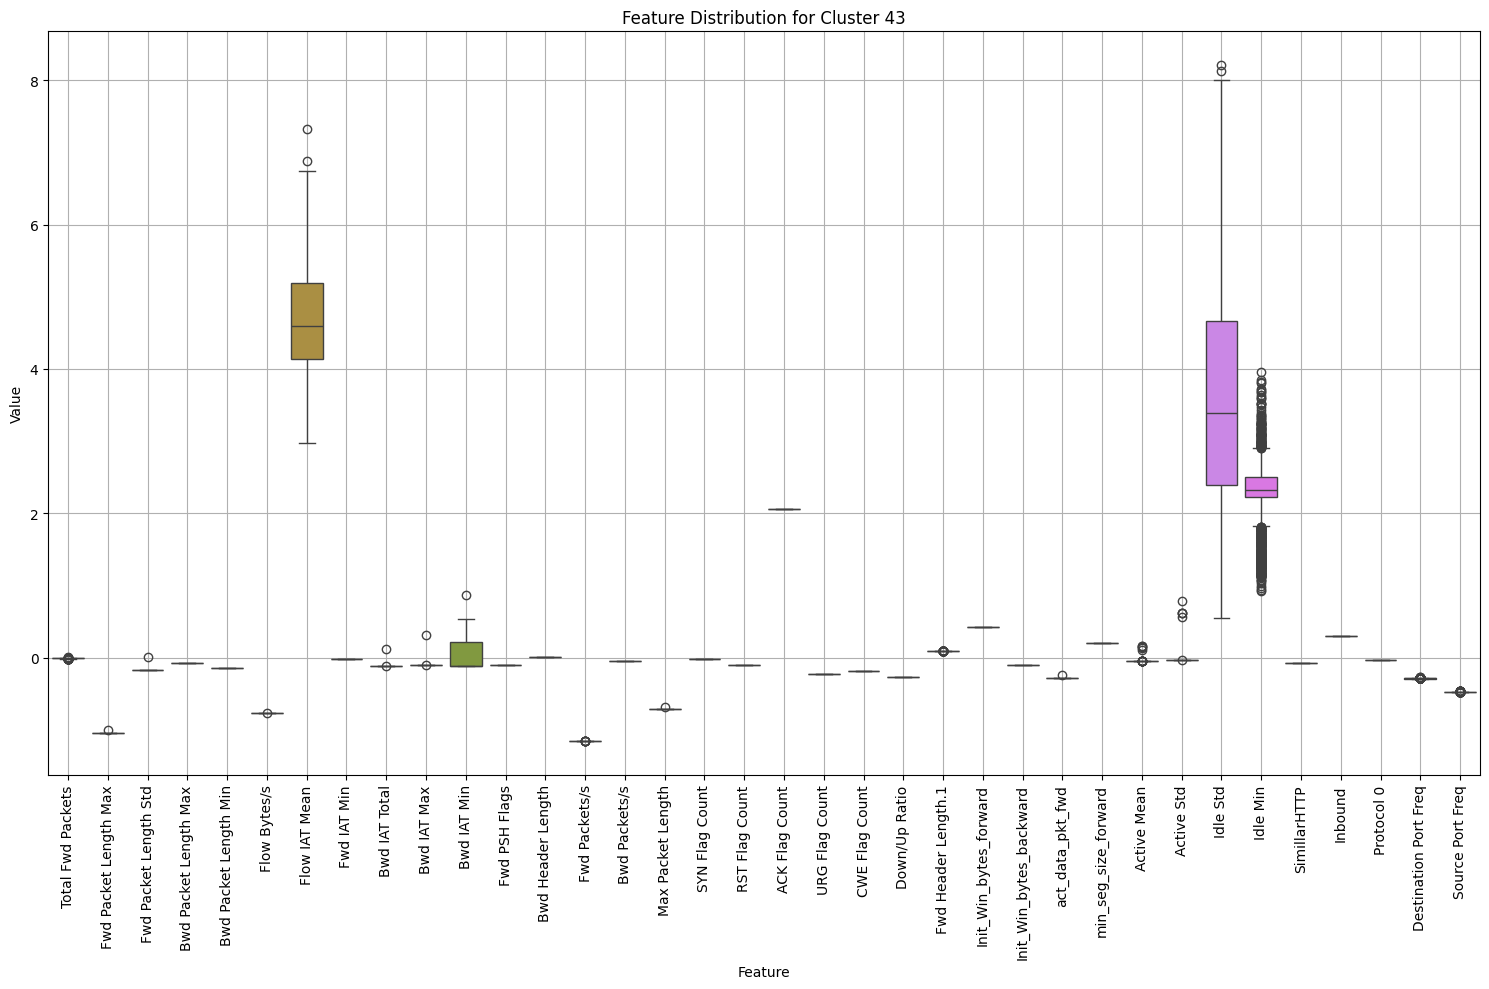

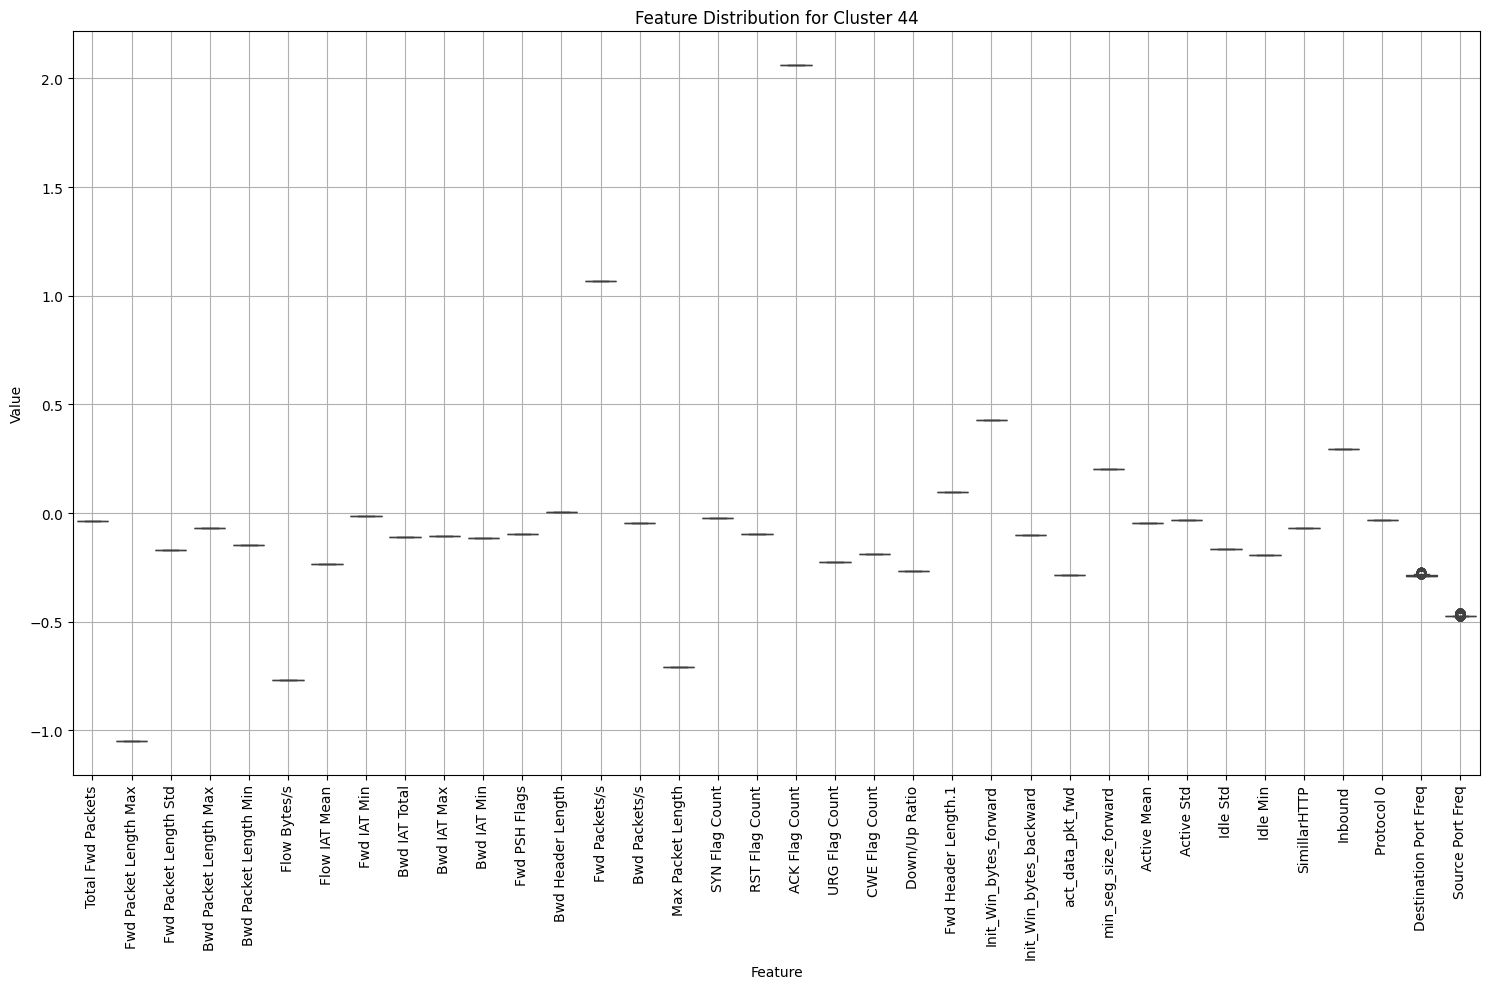

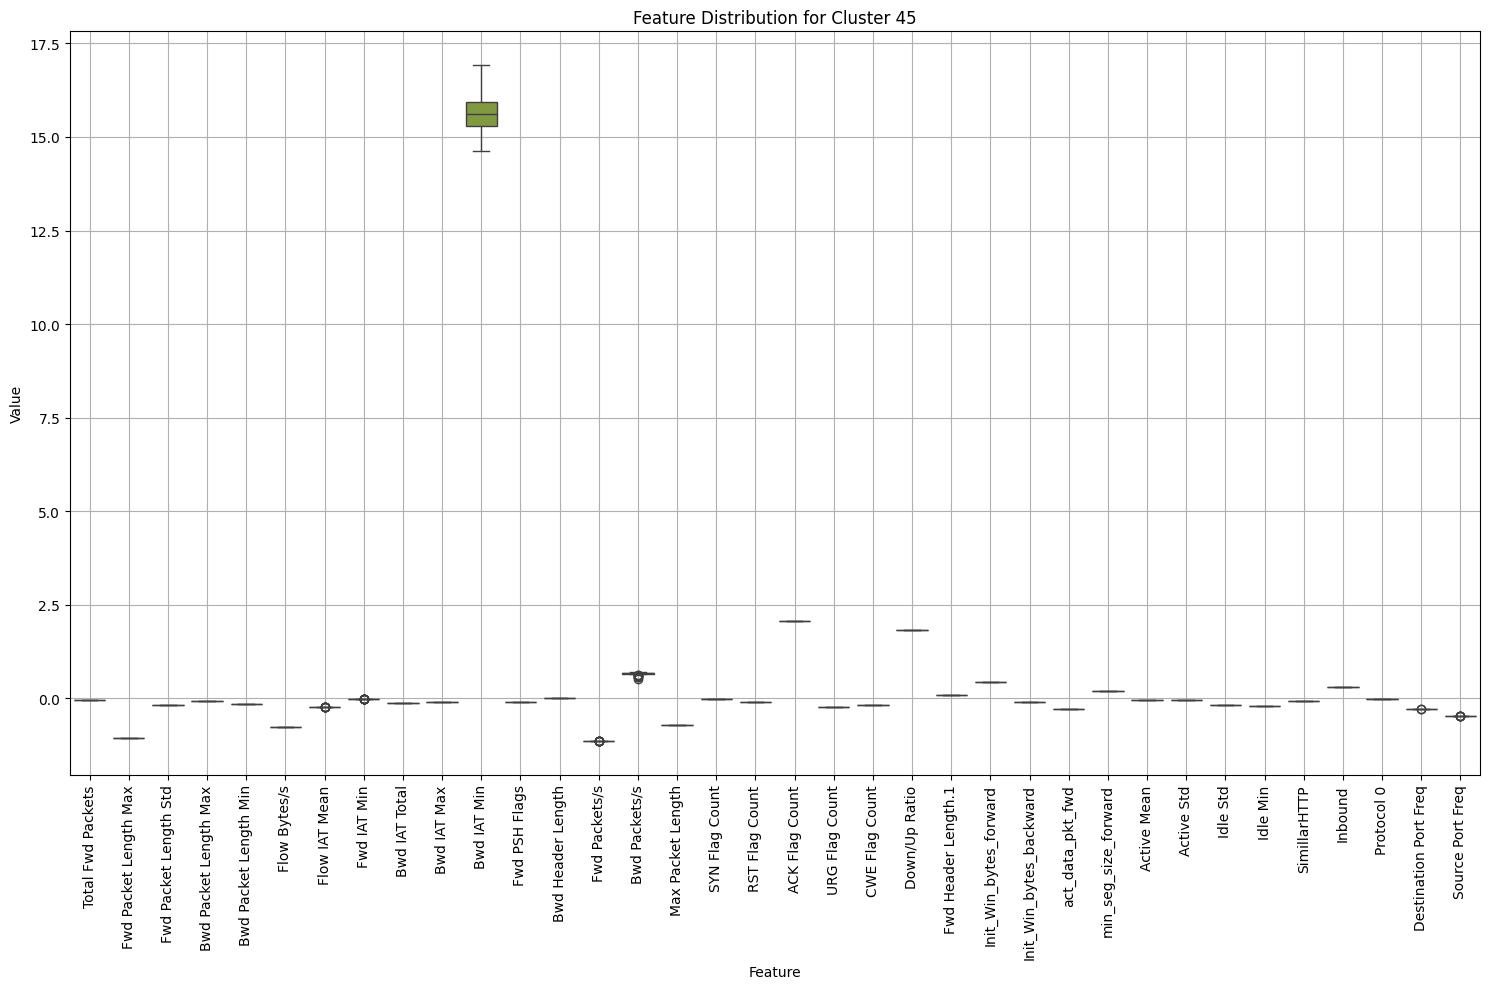

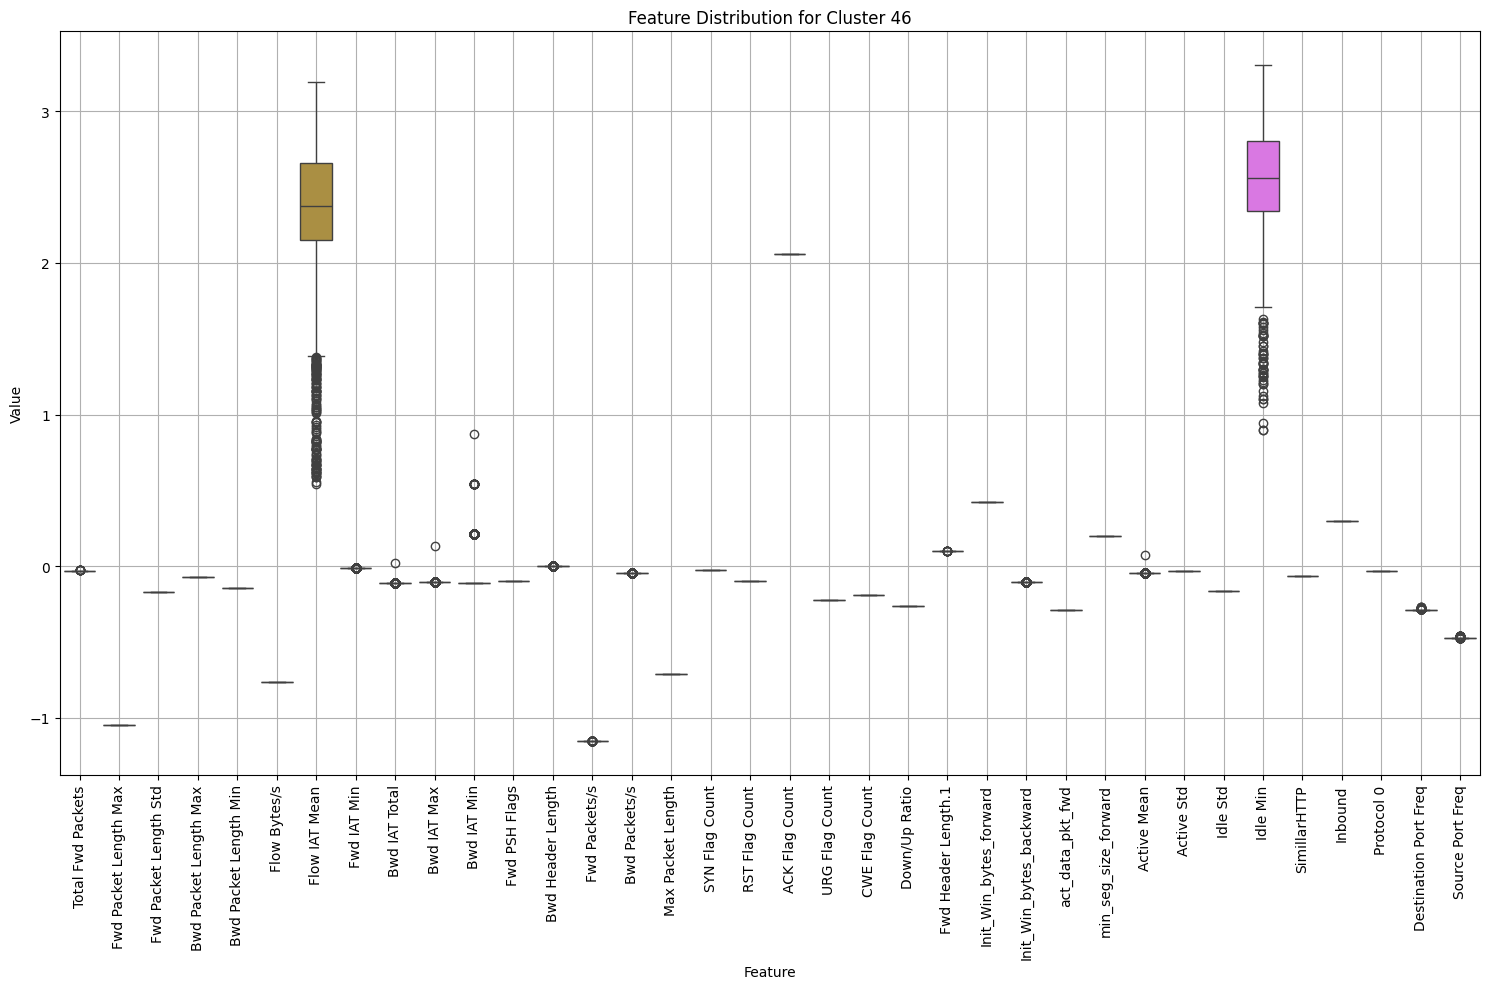

In [ ]:
import pandas as pd
from scipy import stats

feature_names = ddos_data.drop(columns=["label"]).columns
print(len(feature_names.unique()))
df = pd.DataFrame(X_s, columns=feature_names)
df['cluster'] = cl_labels

# Filter out noise points (cluster label -1)
df = df[df['cluster'] != -1]

# Calculate mean and standard deviation for each feature in each cluster
cluster_stats = df.groupby('cluster').agg(['mean', 'std'])

def plot_box_plots_by_cluster(df, feature_names):
    clusters = df['cluster'].unique()

    for cluster in clusters:
        fig, ax = plt.subplots(figsize=(15, 10))
        cluster_data = df[df['cluster'] == cluster][feature_names]
        sns.boxplot(data=cluster_data, orient='v', ax=ax)
        ax.set_title(f'Feature Distribution for Cluster {cluster}')
        ax.set_ylabel('Value')
        ax.set_xlabel('Feature')
        plt.xticks(rotation=90)
        plt.tight_layout()
        plt.grid()
        plt.show()


plot_box_plots_by_cluster(df, feature_names)

# TSNE

In [ ]:
!pip3 install scikit-learn

from sklearn.manifold import TSNE

# Perform t-SNE dimensionality reduction
tsne = TSNE(n_components=2, random_state=42)
X_tsne = tsne.fit_transform(X_s)


<ipython-input-94-1304879d31f5>:13: UserWarning: 
The palette list has fewer values (47) than needed (48) and will cycle, which may produce an uninterpretable plot.
  sns.scatterplot(x=X_tsne[:, 0], y=X_tsne[:, 1], hue=cl_labels, palette=palette, s=50, alpha=0.6)


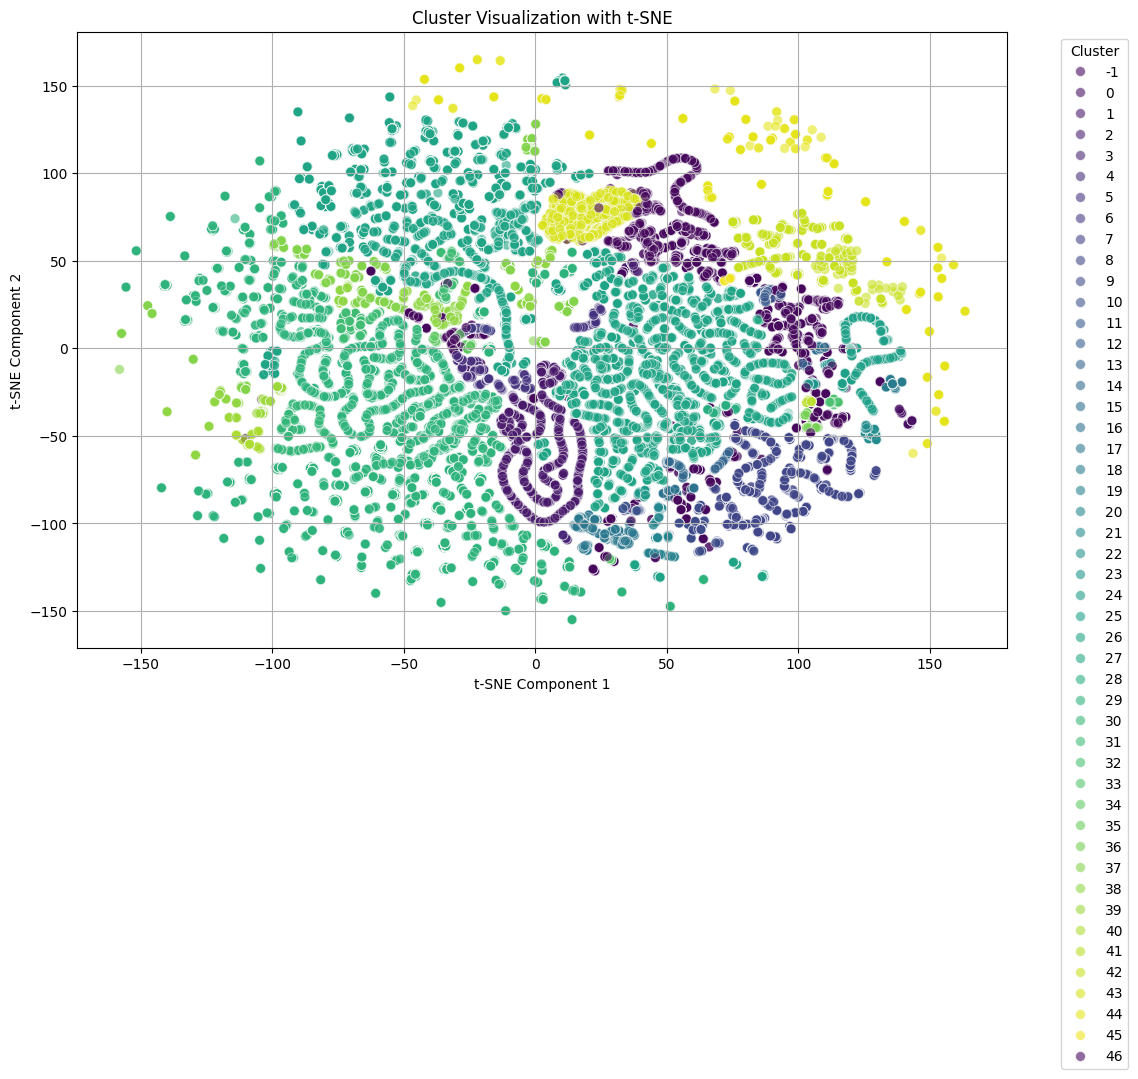

In [ ]:
best_n = 47

# Plot clusters in reduced space
plt.figure(figsize=(12, 8))
palette = sns.color_palette("viridis", best_n)  # Use a distinctive color palette

# Plot points
sns.scatterplot(x=X_tsne[:, 0], y=X_tsne[:, 1], hue=cl_labels, palette=palette, s=50, alpha=0.6)
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.legend(title='Cluster', loc='upper left', bbox_to_anchor=(1.05, 1))
plt.title('Cluster Visualization with t-SNE')
plt.grid(True)
plt.show()

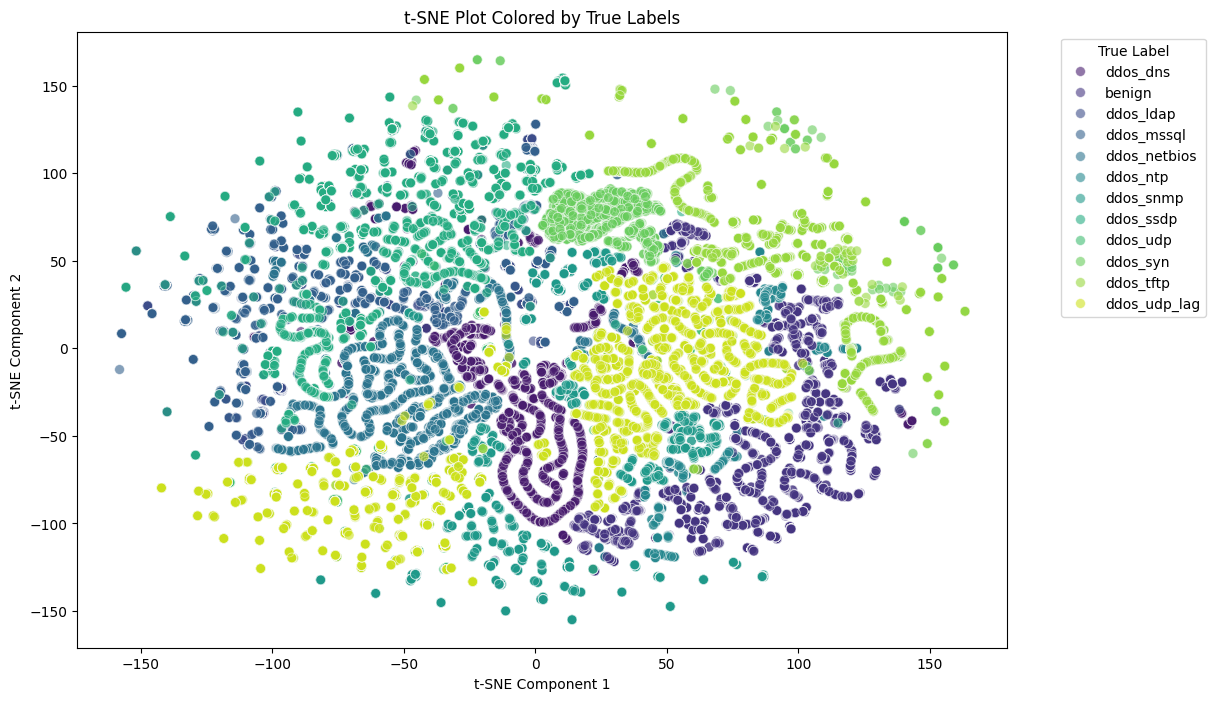

In [ ]:
# Plot t-SNE colored by true labels
plt.figure(figsize=(12, 8))
sns.scatterplot(x=X_tsne[:, 0], y=X_tsne[:, 1], hue=y.to_numpy().flatten(), palette="viridis", s=50, alpha=0.6)
plt.title('t-SNE Plot Colored by True Labels')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.legend(title='True Label', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()


['ddos_dns' 'ddos_dns' 'ddos_dns' ... 'ddos_mssql' 'ddos_udp' 'ddos_snmp']
['ddos_dns' 'ddos_dns' 'ddos_dns' ... 'ddos_udp_lag' 'ddos_udp_lag'
 'ddos_udp_lag']


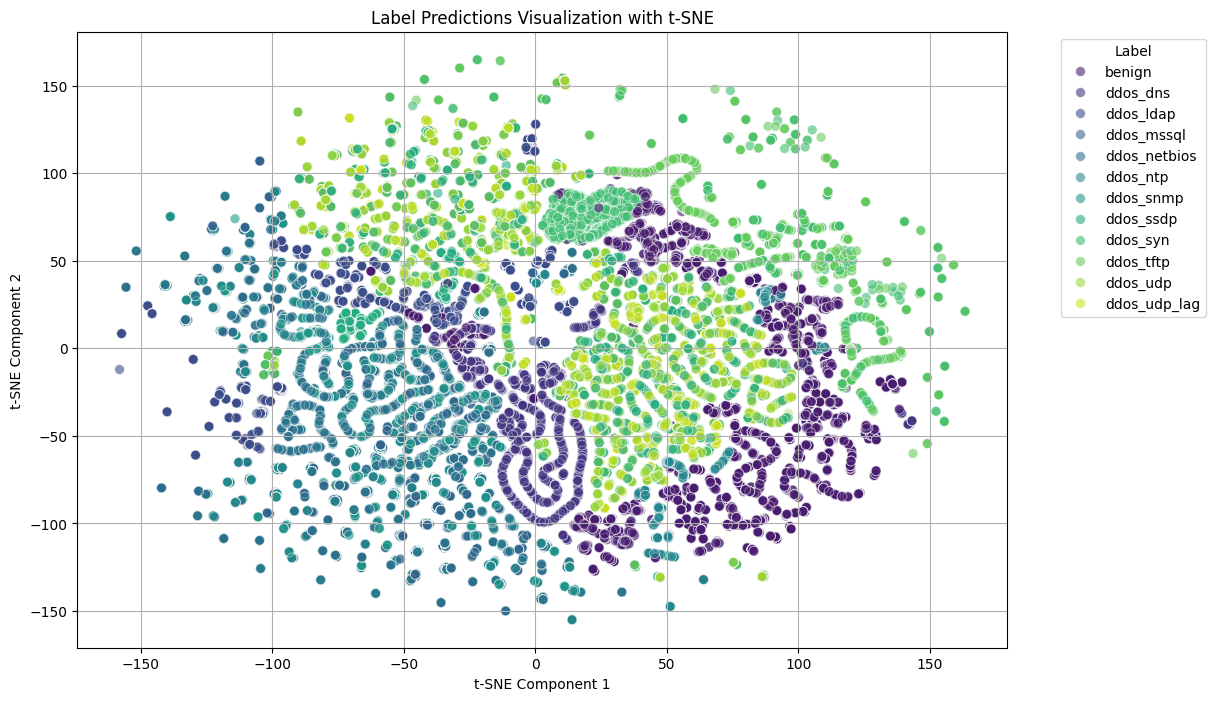

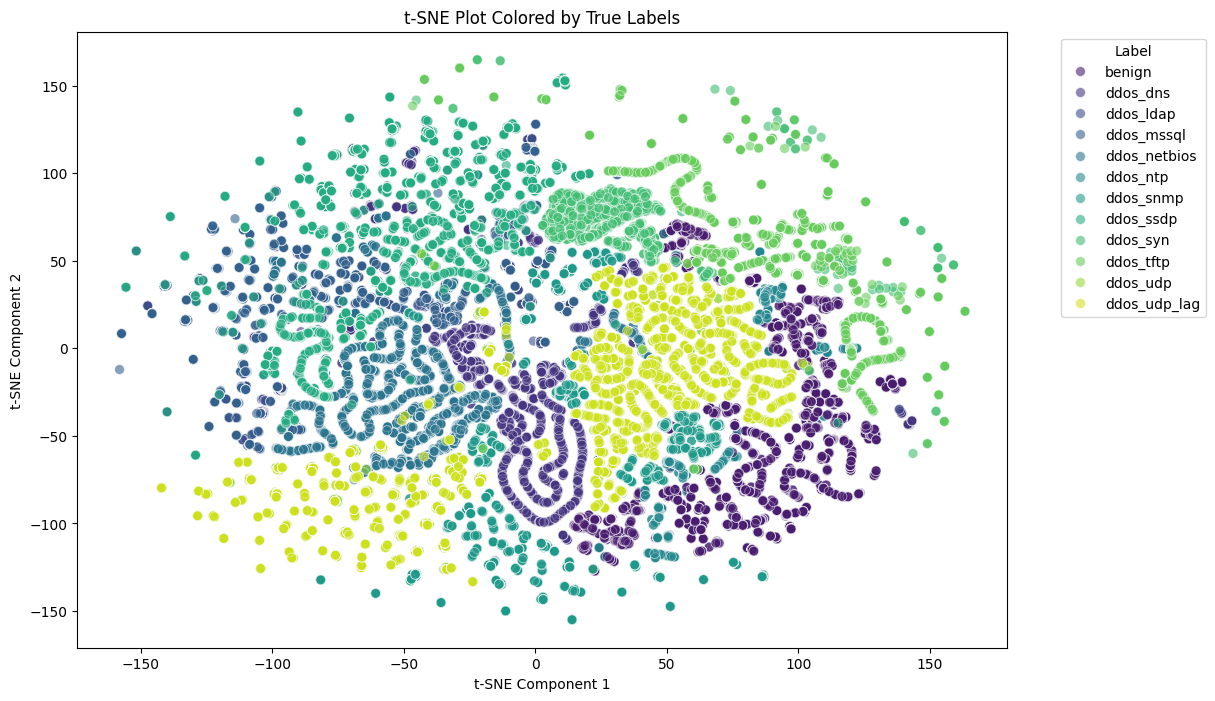

In [ ]:
# Prediction of cluster including noise, for t-SNE compatibility reason
cl_labels_str = cl_labels.astype(str)
y_str = y.to_numpy().flatten()
df = pd.DataFrame({'True Label': y_str, 'Cluster': cl_labels_str})

contingency_table = pd.crosstab(df['Cluster'], df['True Label'])
relative_frequencies = contingency_table.div(contingency_table.sum(axis=1), axis=0)
predicted_labels_noise = []
for cluster in df['Cluster']:
    assigned_label, filtered_labels, filtered_probabilities = assign_label_probabilistically(cluster)
    predicted_labels_noise.append(assigned_label)
predicted_labels_noise = np.array(predicted_labels_noise)

# Creating a distinctive color palette.
print(predicted_labels_noise.astype(str))
print(y.to_numpy().flatten())
unique_labels = np.unique(np.concatenate((predicted_labels_noise.astype(str),y_str)))
palette = sns.color_palette("viridis", len(unique_labels))
color_mapping = {label: palette[i] for i, label in enumerate(unique_labels)}

# Function to map labels to colors.
def map_colors(labels, color_mapping):
    return [color_mapping[label] for label in labels]

# Plot of clusters in the reduced space using t-SNE.
plt.figure(figsize=(12, 8))
scatter = sns.scatterplot(x=X_tsne[:, 0], y=X_tsne[:, 1], hue=predicted_labels_noise.astype(str), palette=color_mapping, s=50, alpha=0.6)
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
handles, labels = scatter.get_legend_handles_labels()
order = sorted(range(len(labels)), key=lambda k: labels[k])
plt.legend([handles[idx] for idx in order], [labels[idx] for idx in order], title='Label', loc='upper left', bbox_to_anchor=(1.05, 1))
plt.title('Label Predictions Visualization with t-SNE')
plt.grid(True)
plt.show()

# Plot t-SNE colored by the true labels.
plt.figure(figsize=(12, 8))
scatter = sns.scatterplot(x=X_tsne[:, 0], y=X_tsne[:, 1], hue=y_str, palette=color_mapping, s=50, alpha=0.6)
plt.title('t-SNE Plot Colored by True Labels')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
handles, labels = scatter.get_legend_handles_labels()
order = sorted(range(len(labels)), key=lambda k: labels[k])
plt.legend([handles[idx] for idx in order], [labels[idx] for idx in order], title='Label', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()




## SHAP


***For more convenience, shap charts will be displayed and saved as png instead of shown as output on the notebook***

In [ ]:
!pip install shap
!pip install xgboost
import shap
import xgboost as xgb
import os

# Filter cluster_labels and corresponding rows in X_s.
mask = cl_labels != -1
filtered_cluster_labels = cl_labels[mask]
ddos_data_s = pd.DataFrame(X_s[mask], columns=ddos_data.drop(columns=['label']).columns)

# Train a classifier with xgboost
model = xgb.XGBClassifier(random_state=42)
model.fit(ddos_data_s, filtered_cluster_labels)

# Create an object explainer SHAP and calculate the SHAP values
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(ddos_data_s)

# Create directory for storing individual SHAP plot images
output_dir = "shap_plots1"
os.makedirs(output_dir, exist_ok=True)

# Save each SHAP summary plot as an image
for i in range(model.n_classes_):
    shap.summary_plot(shap_values[i], ddos_data_s, show=False)
    plt.title(f"Cluster {i}")
    plt.savefig(f"{output_dir}/shap_summary_cluster_{i}.png", dpi = 600)
    plt.close()